In [1]:
import pandas as pd
import numpy as np

import ruptures as rpt
from ruptures.metrics import precision_recall
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

import lightgbm as lgb
import seaborn as sns

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 9]

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
df = pd.read_csv('/Users/estyle-150/github/my_signage/data/processed/processed20240826.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df

,y,client,close,price_am,price_pm,is_train,price,year,month,weekday,...,price_am_lag_7,price_am_lag_365,price_pm_lag_1,price_pm_lag_7,price_pm_lag_365,price_am_moving_avg_7,price_am_moving_avg_30,price_pm_moving_avg_7,price_pm_moving_avg_30,day
datetime,,,,,,,,,,,,,,,,,,,,,
2010-07-01,17,0,0,0.192308,0.076923,1,0.134615,2010,7,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2010-07-02,18,0,0,0.692308,0.423077,1,0.557692,2010,7,4,...,NaN,NaN,0.076923,NaN,NaN,NaN,NaN,NaN,NaN,2
2010-07-03,20,0,0,1.807692,1.192308,1,1.500000,2010,7,5,...,NaN,NaN,0.423077,NaN,NaN,NaN,NaN,NaN,NaN,3
2010-07-04,20,0,0,1.407407,0.925926,1,1.166667,2010,7,6,...,NaN,NaN,1.192308,NaN,NaN,NaN,NaN,NaN,NaN,4
2010-07-05,14,0,0,0.346154,0.192308,1,0.269231,2010,7,0,...,NaN,NaN,0.925926,NaN,NaN,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-27,0,0,0,5.000000,4.000000,0,4.500000,2017,3,0,...,3.0,5.0,4.000000,4.0,4.0,3.857143,2.166667,4.000000,2.166667,27
2017-03-28,0,0,0,4.000000,4.000000,0,4.000000,2017,3,1,...,4.0,4.0,4.000000,4.0,4.0,3.857143,2.233333,4.000000,2.233333,28
2017-03-29,0,0,0,3.000000,3.000000,0,3.000000,2017,3,2,...,2.0,4.0,4.000000,4.0,4.0,4.000000,2.266667,3.857143,2.266667,29


In [5]:
# 使用するカラム
list_no = [0, 2, 3, 4, 5, 6, 7, 8, 9]
use_list = [df.columns[i] for i in list_no]

In [6]:
#df = df[my_bkps[0]:]
df_use = df[use_list]
df_use

,y,close,price_am,price_pm,is_train,price,year,month,weekday
datetime,,,,,,,,,
2010-07-01,17,0,0.192308,0.076923,1,0.134615,2010,7,3
2010-07-02,18,0,0.692308,0.423077,1,0.557692,2010,7,4
2010-07-03,20,0,1.807692,1.192308,1,1.500000,2010,7,5
2010-07-04,20,0,1.407407,0.925926,1,1.166667,2010,7,6
2010-07-05,14,0,0.346154,0.192308,1,0.269231,2010,7,0
...,...,...,...,...,...,...,...,...,...
2017-03-27,0,0,5.000000,4.000000,0,4.500000,2017,3,0
2017-03-28,0,0,4.000000,4.000000,0,4.000000,2017,3,1
2017-03-29,0,0,3.000000,3.000000,0,3.000000,2017,3,2


In [7]:
train_data = df_use[df_use['is_train']==1].copy()
test_data = df_use[df_use['is_train']==0].copy()

train_data.drop(['is_train'], axis=1, inplace=True)
test_data.drop(['y', 'is_train'], axis=1, inplace=True)

In [8]:
y = train_data['y']

In [9]:
def make_sequence_data(y, num_sequence):
  num_data = len(y)
  seq_data = []
  target_data = []
  for i in range(num_data - num_sequence):
    seq_data.append(y[i : i + num_sequence])
    target_data.append(y[i+num_sequence : i+num_sequence+1])
  seq_arr = np.array(seq_data)
  target_arr = np.array(target_data)
  return seq_arr, target_arr

In [10]:
seq_length = 40
y_seq, y_target = make_sequence_data(y, seq_length)

In [11]:
num_valid = 365
y_seq_train = y_seq[:-num_valid]
y_seq_valid = y_seq[-num_valid:]
y_target_train = y_target[:-num_valid]
y_target_valid = y_target[-num_valid:]

In [ ]:
y_seq_t = torch.FloatTensor(y_seq_train)
y_target_t = torch.FloatTensor(y_target_train)

In [19]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size)
    self.linear = nn.Linear(self.hidden_size, 1)

  def forward(self, x):
    x, _ = self.lstm(x)
    x_last = x[-1]
    x = self.linear(x_last)
    return x

In [4]:
class Predictor(nn.Module):
    def __init__(self, inputDim, hiddenDim, OutputDim):
        super(Predictor, self).__init__()

        self.rnn = nn.LSTM(input_size=inputDim, 
                           hidden_size=hiddenDim,
                           batch_first=True)
        self.output_layer = nn.Liniar(hiddenDim, outputDim)

    def forward(self, inputs, hidden0=None):
        output, (hidden, cell) = self.rnn(inputs, hidden0)
        output = self.output_layer(output[:, -1, :])
        return output

In [5]:
class PredictSimpleFormulaNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, batch_first):
        super(PredictSimpleFormulaNet, self).__init__()
        self.rnn = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            batch_first = batch_first)
        self.output_layer = nn.Linear(hidden_size, output_size)

        nn.init.xavier_normal_(self.rnn.weight_ih_l0)
        nn.init.orthogonal_(self.rnn.weight_hh_l0)

    def forward(self, inputs):
        h, _= self.rnn(inputs)
        output = self.output_layer(h[:, -1])

        return output


In [6]:
class Train():
    def __init__(self, input_size, output_size, hidden_size, batch_first, lr):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("device：", self.device)
        self.net = PredictSimpleFormulaNet(input_size, output_size, hidden_size, batch_first).to(self.device)
        self.criterion = nn.MSELoss(reduction='mean')
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr, betas=(0.9, 0.999), amsgrad=True)

    def set_formula_const_arg(self, sin_a, cos_a, sin_t, cos_t):
        self.f = SimpleFormula(sin_a, cos_a, sin_t, cos_t)

    def make_dataset(self, dataset_num, sequence_length, t_start, calc_mode="sin"):
        dataset_inputs = []
        dataset_labels = []
        dataset_times = []
        for t in range(dataset_num):
            if calc_mode == "sin":
                dataset_inputs.append([self.f.sin(t_start + t + i) for i in range(sequence_length)])
                dataset_labels.append([self.f.sin(t_start + t + sequence_length)])
            elif calc_mode == "cos":
                dataset_inputs.append([self.f.cos(t_start + t + i) for i in range(sequence_length)])
                dataset_labels.append([self.f.cos(t_start + t + sequence_length)])
            dataset_times.append(t_start + t + sequence_length)
        print("test = {}, {}, {}".format(np.array(dataset_inputs).shape,  np.array(dataset_labels).shape, np.array(dataset_times).shape))
        return np.array(dataset_inputs),  np.array(dataset_labels), np.array(dataset_times)

    def train_step(self, inputs, labels):
        inputs = torch.Tensor(inputs).to(self.device)
        labels = torch.Tensor(labels).to(self.device)
        self.net.train()
        preds = self.net(inputs)
        loss = self.criterion(preds, labels)
        self.optimizer.zero_grad()
        loss.backward()
        # 勾配が大きくなりすぎると計算が不安定になるので、clipで最大でも勾配2.0に留める
        nn.utils.clip_grad_value_(self.net.parameters(), clip_value=2.0)
        self.optimizer.step()

        return loss, preds

    def test_step(self, inputs, labels):
        inputs = torch.Tensor(inputs).to(self.device)
        labels = torch.Tensor(labels).to(self.device)
        self.net.eval()
        preds = self.net(inputs)
        loss = self.criterion(preds, labels)

        return loss, preds

    def train(self, train_inputs, train_labels, test_inputs, test_labels, epochs, batch_size, sequence_length, input_size):
        torch.backends.cudnn.benchmark = True   # ネットワークがある程度固定であれば、高速化させる

        n_batches_train = int(train_inputs.shape[0] / batch_size)
        n_batches_test = int(test_inputs.shape[0] / batch_size)
        for epoch in range(epochs):
            print('-------------')
            print('Epoch {}/{}'.format(epoch+1, epochs))
            print('-------------')
            train_loss = 0.
            test_loss = 0.
            train_inputs_shuffle, train_labels_shuffle = shuffle(train_inputs, train_labels)
            for batch in range(n_batches_train):
                start = batch * batch_size
                end = start + batch_size
                loss, _ = self.train_step(np.array(train_inputs_shuffle[start:end]).reshape(-1, sequence_length, input_size), np.array(train_labels_shuffle[start:end]).reshape(-1, input_size))
                train_loss += loss.item()

            for batch in range(n_batches_test):
                start = batch * batch_size
                end = start + batch_size
                loss, _ = self.test_step(np.array(test_inputs[start:end]).reshape(-1, sequence_length, input_size), np.array(test_labels[start:end]).reshape(-1, input_size))
                test_loss += loss.item()

            train_loss /= float(n_batches_train)
            test_loss /= float(n_batches_test)
            print('loss: {:.3}, test_loss: {:.3}'.format(train_loss, test_loss))

    def pred_result_plt(self, test_inputs, test_labels, test_times, sequence_length, input_size):
        print('-------------')
        print("start predict test!!")
        self.net.eval()
        preds = []
        for i in range(len(test_inputs)):
            input = np.array(test_inputs[i]).reshape(-1, sequence_length, input_size)
            input = torch.Tensor(input).to(self.device)
            pred = self.net(input).data.cpu().numpy()
            preds.append(pred[0].tolist())
        preds = np.array(preds)
        test_labels = np.array(test_labels)
        pred_epss = np.abs(test_labels - preds)
        print("pred_epss_max = {}".format(pred_epss.max()))
        #以下グラフ描画
        plt.plot(test_times, preds)
        plt.plot(test_times, test_labels, c='#00ff00')
        plt.xlabel('t')
        plt.ylabel('y')
        plt.legend(['label', 'pred'])
        plt.title('compare label and pred')
        plt.show()

    def confirm_input_and_label_plot(self, calc_mode, inputs, labels, times):
        #この関数はinputとlabelを可視化するためのコードで基本的に使う必要のない関数です
        print('-------------')
        print("confirm_input_and_label!!")
        re_inputs = inputs[:, -1]
        #以下グラフ描画
        plt.plot(times[:-3], re_inputs[:-3], marker="o")
        plt.plot(times[-3:], re_inputs[-3:], marker="o")
        plt.plot(times[-1]+1.0, labels[-1], marker="o")
        plt.xlabel('t')
        plt.ylabel('y')
        plt.legend([calc_mode, 'input', 'label'])
        plt.title('confirm input and label')
        plt.show()



In [ ]:
if __name__ == '__main__':
    '''
    定数
    '''
    dataset_num = 250
    sequence_length = 3
    t_start = -100.0
    sin_a = 2.0
    cos_a = 2.0
    sin_t = 25.0
    cos_t = 25.0
    calc_mode = "sin"
    # model pram
    input_size = 1
    output_size = 1
    hidden_size = 64
    batch_first = True
    # train pram
    lr = 0.001
    epochs = 15
    batch_size = 4
    test_size = 0.2
    '''
    学習用の関数を呼び出す
    '''
    train = Train(input_size, output_size, hidden_size, batch_first, lr)
    train.set_formula_const_arg(sin_a, cos_a, sin_t, cos_t)
    dataset_inputs, dataset_labels, dataset_times = train.make_dataset(dataset_num, sequence_length, t_start, calc_mode=calc_mode)
    print("dataset_inputs = {}, dataset_labels = {}".format(dataset_inputs.shape, dataset_labels.shape))
    train_inputs, test_inputs, train_labels, test_labels = train_test_split(dataset_inputs, dataset_labels, test_size=test_size, shuffle=False)
    train_times, test_times = train_test_split(dataset_times, test_size=test_size, shuffle=False)
    print("train_inputs = {}, train_labels = {}, test_inputs = {}, test_labels = {}".format(train_inputs.shape, train_labels.shape, test_inputs.shape, test_labels.shape))
    # train.confirm_input_and_label_plot(calc_mode, test_inputs, test_labels, test_times)
    train.train(train_inputs, train_labels, test_inputs, test_labels, epochs, batch_size, sequence_length, input_size)
    train.pred_result_plt(test_inputs, test_labels, test_times, sequence_length, input_size)



In [5]:
df = pd.read_csv('/Users/estyle-150/github/my_signage/data/processed/processed20240826.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df

,y,client,close,price_am,price_pm,is_train,price,year,month,weekday,...,price_am_lag_7,price_am_lag_365,price_pm_lag_1,price_pm_lag_7,price_pm_lag_365,price_am_moving_avg_7,price_am_moving_avg_30,price_pm_moving_avg_7,price_pm_moving_avg_30,day
datetime,,,,,,,,,,,,,,,,,,,,,
2010-07-01,17,0,0,0.192308,0.076923,1,0.134615,2010,7,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2010-07-02,18,0,0,0.692308,0.423077,1,0.557692,2010,7,4,...,NaN,NaN,0.076923,NaN,NaN,NaN,NaN,NaN,NaN,2
2010-07-03,20,0,0,1.807692,1.192308,1,1.500000,2010,7,5,...,NaN,NaN,0.423077,NaN,NaN,NaN,NaN,NaN,NaN,3
2010-07-04,20,0,0,1.407407,0.925926,1,1.166667,2010,7,6,...,NaN,NaN,1.192308,NaN,NaN,NaN,NaN,NaN,NaN,4
2010-07-05,14,0,0,0.346154,0.192308,1,0.269231,2010,7,0,...,NaN,NaN,0.925926,NaN,NaN,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-27,0,0,0,5.000000,4.000000,0,4.500000,2017,3,0,...,3.0,5.0,4.000000,4.0,4.0,3.857143,2.166667,4.000000,2.166667,27
2017-03-28,0,0,0,4.000000,4.000000,0,4.000000,2017,3,1,...,4.0,4.0,4.000000,4.0,4.0,3.857143,2.233333,4.000000,2.233333,28
2017-03-29,0,0,0,3.000000,3.000000,0,3.000000,2017,3,2,...,2.0,4.0,4.000000,4.0,4.0,4.000000,2.266667,3.857143,2.266667,29


In [6]:
pd.DataFrame(df.columns)

,0
0,y
1,client
2,close
3,price_am
4,price_pm
5,is_train
6,price
7,year
8,month
9,weekday


In [7]:
# 使用するカラム
list_no = [0, 2, 3, 4, 5, 6, 7, 8, 9]
use_list = [df.columns[i] for i in list_no]

In [8]:
################
### 変化点検知 ###
################

# コスト関数の設定
#model = "l2"
# アルゴの設定と学習
#algo = rpt.Dynp(model=model).fit(df[['y']])
# 変化点の検出
#my_bkps = algo.predict(n_bkps=3)
# 結果のプロット
#rpt.show.display(df[['y']], my_bkps, figsize=(12, 9))
#plt.show()
# 検出された変化点
#print(my_bkps)


In [9]:
#df = df[my_bkps[0]:]
df = df[use_list]
df

,y,close,price_am,price_pm,is_train,price,year,month,weekday
datetime,,,,,,,,,
2010-07-01,17,0,0.192308,0.076923,1,0.134615,2010,7,3
2010-07-02,18,0,0.692308,0.423077,1,0.557692,2010,7,4
2010-07-03,20,0,1.807692,1.192308,1,1.500000,2010,7,5
2010-07-04,20,0,1.407407,0.925926,1,1.166667,2010,7,6
2010-07-05,14,0,0.346154,0.192308,1,0.269231,2010,7,0
...,...,...,...,...,...,...,...,...,...
2017-03-27,0,0,5.000000,4.000000,0,4.500000,2017,3,0
2017-03-28,0,0,4.000000,4.000000,0,4.000000,2017,3,1
2017-03-29,0,0,3.000000,3.000000,0,3.000000,2017,3,2


In [158]:
train_data = df[df['is_train']==1].copy()
test_data = df[df['is_train']==0].copy()

train_data.drop(['is_train'], axis=1, inplace=True)
test_data.drop(['y', 'is_train'], axis=1, inplace=True)

In [159]:
# 開店日のみのデータ作成
train_data_open = train_data[train_data['close']==0].drop(['close'], axis=1, inplace=False)

In [160]:
test_data_open = test_data.drop(['close'],axis=1, inplace=False)

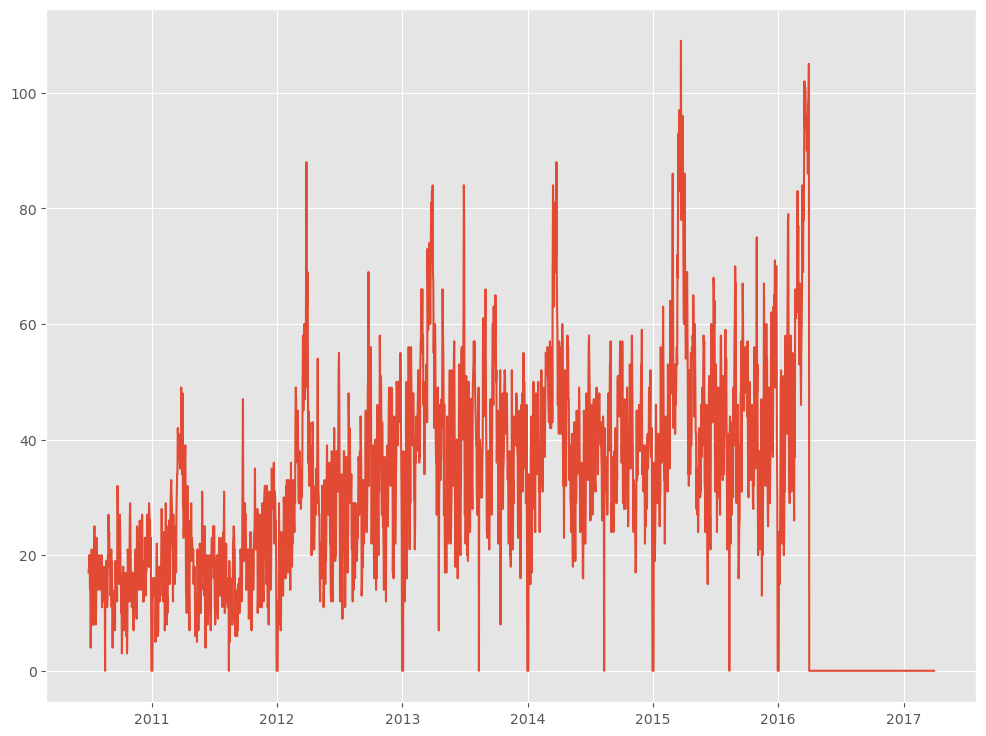

In [161]:
plt.plot(df['y'])

In [162]:
from sklearn.model_selection import KFold
import optuna.integration.lightgbm as lgb_op
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[60]	valid_0's l2: 89.1645


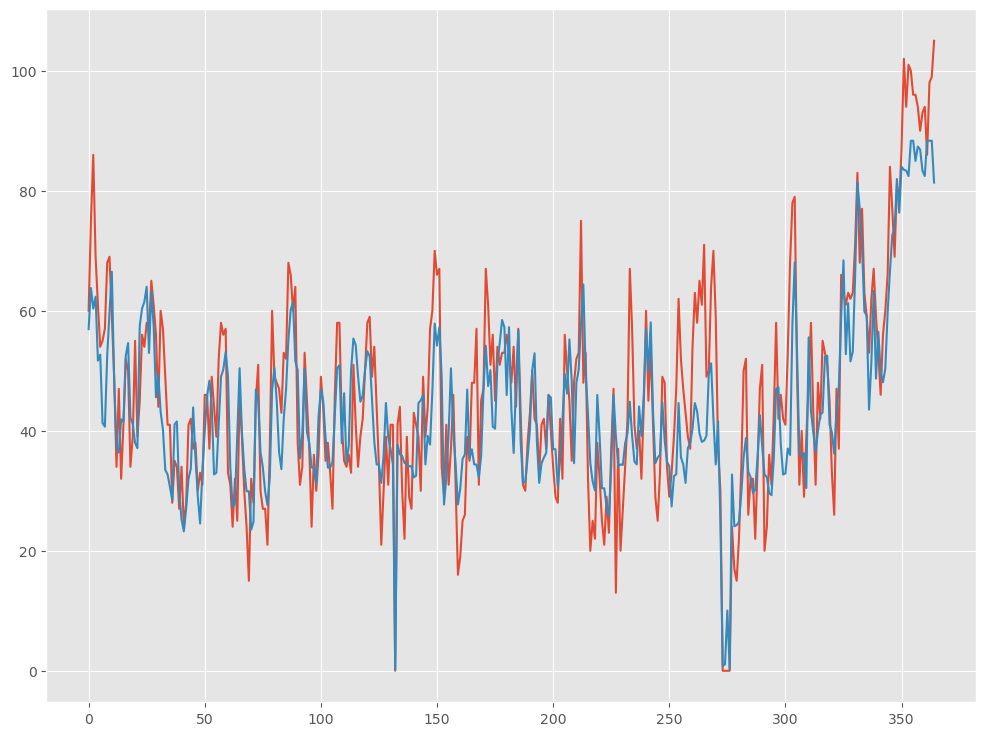

In [163]:
# 訓練データと検証データに分ける
N = 365
X_train = train_data.drop(['y'], axis=1)[:-N]
y_train = train_data['y'][:-N]

X_valid = train_data.drop(['y'], axis=1)[-N:]
y_valid = train_data['y'][-N:]

lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid)

params = {'objective' : 'regression',
          'metrics' : 'mse',
          'num_leaves' : 7,
          'early_stopping_rounds' : 30,
          'veerbosity' : -1}

model = lgb.train(params, lgb_train, valid_sets=lgb_valid)

valid_pred = model.predict(X_valid)

pred_df = pd.concat([y_valid.reset_index(drop=True), pd.Series(valid_pred)], axis=1)
pred_df.columns = ['true', 'pred']
pred_df

plt.plot(pred_df)

In [164]:
mse = mean_squared_error(y_valid, valid_pred)
print('MSE:',round(mse,3))

MSE: 89.165


([<matplotlib.axis.XTick at 0x16e2d8170>,
 [Text(0, 0, 'y_lag_365'),
  Text(1, 0, 'price_am'),
  Text(2, 0, 'year'),
  Text(3, 0, 'month'),
  Text(4, 0, 'price'),
  Text(5, 0, 'price_pm'),
  Text(6, 0, 'close'),
  Text(7, 0, 'weekday')])

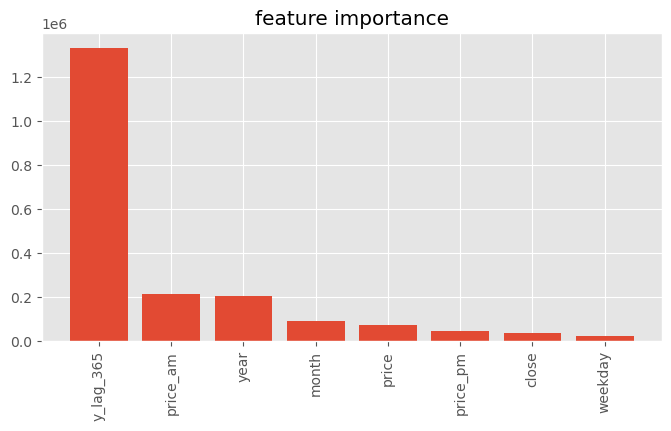

In [165]:
importances = model.feature_importance(importance_type='gain')
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,4))
plt.title('feature importance')
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), X_train.columns[indices], rotation=90)

In [166]:
# oputunaによるハイパーパラメータのチューニング
import optuna

In [167]:
x_tr = X_train
x_va = X_valid
y_tr = y_train
y_va = y_valid

In [168]:
# 固定値のハイパーパラメータ
params_base = {
    'objective' : 'mse',
    'metrics' : 'mse',
    'random_seed' : 123,    
    'learnig_rate' : 0.05,  # １回のブースティングで加算する重みの比率
    'min_data_in_bin' : 3,  # ヒストグラムの１つのbinに含まれる最小のレコード数
    'bagging_freq' : 0,
    'verbose' : -1,
}


# ハイパーパラメータの探索範囲
def objective(trial):
    params_turning = {
        'num_leaves' : trial.suggest_int('num_leaves', 50, 200),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 2, 30),
        'max_bins' : trial.suggest_int('max_bin', 200, 400),
        'bagging_fraction' : trial.suggest_float('bagging_fraction', 0.8, 0.95),
        'feature_fraction' : trial.suggest_float('eature_fraction', 0.35, 0.65),
        'min_gain_to_split' : trial.suggest_float('min_gain_to_split', 0.01, 1, log=True),
        'lambda_11' : trial.suggest_float('lambda_11', 0.01, 1, log=True),
        'lambda_12' : trial.suggest_float('lambda_12', 0.01, 1, log=True),
    }
    
    # 探索用ハイパーパラメータの設定
    params_turning.update(params_base)
    lgb_train = lgb.Dataset(x_tr, y_tr)
    lgb_eval = lgb.Dataset(x_va, y_va)

    #探索用ハイパーパラメータで学習
    model = lgb.train(params_turning,
                      lgb_train,
                      num_boost_round=10000,
                      valid_sets=[lgb_train, lgb_eval],
                      valid_names=['train', 'valid'],
                      callbacks=[lgb.early_stopping(100),
                                 lgb.log_evaluation(500)])
    y_va_pred = model.predict(x_va,
                              num_iteration=model.best_iteration)
    score = mean_absolute_error(y_va, y_va_pred)
    print('')
    return score

In [169]:
# ハイパーパラメータの最適化の実行
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=0), direction='minimize')
study.optimize(objective, n_trials=500)

[I 2024-09-09 14:28:14,401] A new study created in memory with name: no-name-679339e6-5443-47b5-8bb9-b952e9474b99
[I 2024-09-09 14:28:14,529] Trial 0 finished with value: 7.872942667323097 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 22, 'max_bin': 321, 'bagging_fraction': 0.8817324774495345, 'eature_fraction': 0.47709643980167143, 'min_gain_to_split': 0.19578897201212997, 'lambda_11': 0.07501954443620121, 'lambda_12': 0.6074996073425692}. Best is trial 0 with value: 7.872942667323097.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[107]	train's l2: 29.7527	valid's l2: 97.9072

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:14,639] Trial 1 finished with value: 7.868853403593566 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 13, 'max_bin': 359, 'bagging_fraction': 0.8793342379629356, 'eature_fraction': 0.5204133683281797, 'min_gain_to_split': 0.70989362574059, 'lambda_11': 0.013869861245357327, 'lambda_12': 0.014936835544198456}. Best is trial 1 with value: 7.868853403593566.
[I 2024-09-09 14:28:14,737] Trial 2 finished with value: 7.801096870012533 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 26, 'max_bin': 356, 'bagging_fraction': 0.9305018222370228, 'eature_fraction': 0.6435855026698292, 'min_gain_to_split': 0.3965675081771009, 'lambda_11': 0.08374496868436809, 'lambda_12': 0.36396393567863894}. Best is trial 2 with value: 7.801096870012533.
[I 2024-09-09 14:28:14,822] Trial 3 finished with value: 7.875113895150183 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 20, 'max_bin': 228, 'bagging_fraction': 0.9417003375574375, 'eature_fraction': 0.5065544965250215

Early stopping, best iteration is:
[55]	train's l2: 29.5819	valid's l2: 96.5408

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	train's l2: 28.2926	valid's l2: 95.9654

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	train's l2: 31.4473	valid's l2: 96.7478

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:14,921] Trial 4 finished with value: 7.8796421182364 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 18, 'max_bin': 203, 'bagging_fraction': 0.8926453245613816, 'eature_fraction': 0.5336287168167264, 'min_gain_to_split': 0.17134364197119656, 'lambda_11': 0.7717846862118064, 'lambda_12': 0.2310152225018237}. Best is trial 2 with value: 7.801096870012533.
[I 2024-09-09 14:28:15,013] Trial 5 finished with value: 7.896068007067029 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 14, 'max_bin': 340, 'bagging_fraction': 0.8090338207443906, 'eature_fraction': 0.5500300146337003, 'min_gain_to_split': 0.21941976179005757, 'lambda_11': 0.02634905974115613, 'lambda_12': 0.018107254066631072}. Best is trial 2 with value: 7.801096870012533.


Early stopping, best iteration is:
[74]	train's l2: 30.0319	valid's l2: 97.9815

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	train's l2: 30.2407	valid's l2: 96.5328

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:15,144] Trial 6 finished with value: 7.79313177244682 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 12, 'max_bin': 314, 'bagging_fraction': 0.865790227019348, 'eature_fraction': 0.6465121514177679, 'min_gain_to_split': 0.015998881492631498, 'lambda_11': 0.02616697456085447, 'lambda_12': 0.021019338091154416}. Best is trial 6 with value: 7.79313177244682.
[I 2024-09-09 14:28:15,269] Trial 7 finished with value: 7.721632956572741 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 9, 'max_bin': 293, 'bagging_fraction': 0.8366638388002404, 'eature_fraction': 0.3976908750936559, 'min_gain_to_split': 0.016624564693643644, 'lambda_11': 0.2054277828628595, 'lambda_12': 0.018895826938026012}. Best is trial 7 with value: 7.721632956572741.


Early stopping, best iteration is:
[45]	train's l2: 25.5961	valid's l2: 96.1348

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 27.9712	valid's l2: 94.0506

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:15,386] Trial 8 finished with value: 7.849337172574513 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 12, 'max_bin': 365, 'bagging_fraction': 0.8145651913689592, 'eature_fraction': 0.6013834722496412, 'min_gain_to_split': 0.015566709318481201, 'lambda_11': 0.8972612866432508, 'lambda_12': 0.08655704137361815}. Best is trial 7 with value: 7.721632956572741.
[I 2024-09-09 14:28:15,484] Trial 9 finished with value: 7.759422908826166 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 19, 'max_bin': 348, 'bagging_fraction': 0.8058781688381481, 'eature_fraction': 0.43484208877292285, 'min_gain_to_split': 0.017393745944806985, 'lambda_11': 0.0391093317225106, 'lambda_12': 0.0172764870082179}. Best is trial 7 with value: 7.721632956572741.


Early stopping, best iteration is:
[46]	train's l2: 25.6684	valid's l2: 96.3951

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	train's l2: 31.4513	valid's l2: 95.1558

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:15,659] Trial 10 finished with value: 8.078626810495239 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 3, 'max_bin': 274, 'bagging_fraction': 0.8408031849181106, 'eature_fraction': 0.35831680797439047, 'min_gain_to_split': 0.05288119338662162, 'lambda_11': 0.2783263930817863, 'lambda_12': 0.07368804410265083}. Best is trial 7 with value: 7.721632956572741.
[I 2024-09-09 14:28:15,813] Trial 11 finished with value: 7.780418739423325 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 7, 'max_bin': 274, 'bagging_fraction': 0.8355545757586524, 'eature_fraction': 0.408116999412076, 'min_gain_to_split': 0.032694791324974944, 'lambda_11': 0.16289049442516693, 'lambda_12': 0.04115856606244184}. Best is trial 7 with value: 7.721632956572741.


Early stopping, best iteration is:
[48]	train's l2: 21.8714	valid's l2: 104.073

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	train's l2: 26.0597	valid's l2: 96.7714

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:15,954] Trial 12 finished with value: 7.886192039861834 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 29, 'max_bin': 282, 'bagging_fraction': 0.8338390023579931, 'eature_fraction': 0.4455608377656969, 'min_gain_to_split': 0.010290694288928754, 'lambda_11': 0.31211954149297433, 'lambda_12': 0.010045571309174335}. Best is trial 7 with value: 7.721632956572741.


Early stopping, best iteration is:
[211]	train's l2: 28.2848	valid's l2: 94.8041

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:16,193] Trial 13 finished with value: 7.76668221615402 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 7, 'max_bin': 397, 'bagging_fraction': 0.8023162335241206, 'eature_fraction': 0.3910337042123353, 'min_gain_to_split': 0.02674571089284545, 'lambda_11': 0.050154371243898675, 'lambda_12': 0.03853185282478898}. Best is trial 7 with value: 7.721632956572741.
[I 2024-09-09 14:28:16,371] Trial 14 finished with value: 7.783470230008362 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 23, 'max_bin': 301, 'bagging_fraction': 0.8538960519238117, 'eature_fraction': 0.4415984672723618, 'min_gain_to_split': 0.029388491126196917, 'lambda_11': 0.16209678458400226, 'lambda_12': 0.035026125633698835}. Best is trial 7 with value: 7.721632956572741.


Early stopping, best iteration is:
[57]	train's l2: 25.442	valid's l2: 95.9677

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[206]	train's l2: 25.8141	valid's l2: 93.7229

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:16,537] Trial 15 finished with value: 7.754814125840173 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 7, 'max_bin': 386, 'bagging_fraction': 0.822983820248446, 'eature_fraction': 0.351228791685471, 'min_gain_to_split': 0.010614157041912028, 'lambda_11': 0.010278628220597311, 'lambda_12': 0.14573577212625521}. Best is trial 7 with value: 7.721632956572741.


Early stopping, best iteration is:
[58]	train's l2: 25.3888	valid's l2: 96.4936

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:16,764] Trial 16 finished with value: 7.756019283360505 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 7, 'max_bin': 246, 'bagging_fraction': 0.8290222742471093, 'eature_fraction': 0.360253866949226, 'min_gain_to_split': 0.08173486363391959, 'lambda_11': 0.012359263856068748, 'lambda_12': 0.16717445235114342}. Best is trial 7 with value: 7.721632956572741.


Early stopping, best iteration is:
[57]	train's l2: 25.5335	valid's l2: 95.8215

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:17,016] Trial 17 finished with value: 8.0678089042213 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 4, 'max_bin': 398, 'bagging_fraction': 0.903668943079996, 'eature_fraction': 0.3869348914546647, 'min_gain_to_split': 0.010526102975040039, 'lambda_11': 0.48778760207673116, 'lambda_12': 0.14332712151598426}. Best is trial 7 with value: 7.721632956572741.
[I 2024-09-09 14:28:17,179] Trial 18 finished with value: 7.7278776433797445 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 10, 'max_bin': 256, 'bagging_fraction': 0.848411584453707, 'eature_fraction': 0.35037697640144533, 'min_gain_to_split': 0.05069939764350235, 'lambda_11': 0.16121503074123952, 'lambda_12': 0.05884814293317561}. Best is trial 7 with value: 7.721632956572741.


Early stopping, best iteration is:
[41]	train's l2: 25.5566	valid's l2: 103.844

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	train's l2: 29.6491	valid's l2: 94.1347

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:17,350] Trial 19 finished with value: 8.033296660339845 and parameters: {'num_leaves': 122, 'min_data_in_leaf': 10, 'max_bin': 249, 'bagging_fraction': 0.8548743451230875, 'eature_fraction': 0.4684746970045649, 'min_gain_to_split': 0.045684238898842995, 'lambda_11': 0.16089963869710502, 'lambda_12': 0.06174920262742756}. Best is trial 7 with value: 7.721632956572741.
[I 2024-09-09 14:28:17,474] Trial 20 finished with value: 7.744536095004451 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 15, 'max_bin': 250, 'bagging_fraction': 0.8532976281928297, 'eature_fraction': 0.3997898922740237, 'min_gain_to_split': 0.1118000053362466, 'lambda_11': 0.29432383390210926, 'lambda_12': 0.027709361868330437}. Best is trial 7 with value: 7.721632956572741.


Early stopping, best iteration is:
[42]	train's l2: 29.8574	valid's l2: 100.989

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 32.293	valid's l2: 94.174

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:17,608] Trial 21 finished with value: 7.724089785807501 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 16, 'max_bin': 248, 'bagging_fraction': 0.851269619480228, 'eature_fraction': 0.40888667638443144, 'min_gain_to_split': 0.10863551315228644, 'lambda_11': 0.3034602293466457, 'lambda_12': 0.029361183080947078}. Best is trial 7 with value: 7.721632956572741.
[I 2024-09-09 14:28:17,738] Trial 22 finished with value: 7.764447207640173 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 10, 'max_bin': 222, 'bagging_fraction': 0.8646518101257916, 'eature_fraction': 0.41810553255156524, 'min_gain_to_split': 0.11738914133701442, 'lambda_11': 0.4574744326894415, 'lambda_12': 0.05397086406845692}. Best is trial 7 with value: 7.721632956572741.


Early stopping, best iteration is:
[57]	train's l2: 33.1113	valid's l2: 93.8025

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 28.5635	valid's l2: 94.7684

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:17,854] Trial 23 finished with value: 7.717352234965864 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 17, 'max_bin': 288, 'bagging_fraction': 0.848981928703436, 'eature_fraction': 0.37581134404546207, 'min_gain_to_split': 0.045431814806341154, 'lambda_11': 0.1272801787707885, 'lambda_12': 0.027754483638101766}. Best is trial 23 with value: 7.717352234965864.
[I 2024-09-09 14:28:17,940] Trial 24 finished with value: 7.705581337236857 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 17, 'max_bin': 290, 'bagging_fraction': 0.8208834457610044, 'eature_fraction': 0.3823690704062581, 'min_gain_to_split': 0.023068623716384316, 'lambda_11': 0.11440603939436603, 'lambda_12': 0.012226886907117054}. Best is trial 24 with value: 7.705581337236857.
[I 2024-09-09 14:28:18,042] Trial 25 finished with value: 7.705581337236857 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 17, 'max_bin': 293, 'bagging_fraction': 0.8180597919990479, 'eature_fraction': 0.3872

Early stopping, best iteration is:
[62]	train's l2: 33.2463	valid's l2: 93.5446

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	train's l2: 33.5289	valid's l2: 93.4355

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	train's l2: 33.5289	valid's l2: 93.4355



[I 2024-09-09 14:28:18,131] Trial 26 finished with value: 7.727467655116884 and parameters: {'num_leaves': 131, 'min_data_in_leaf': 17, 'max_bin': 325, 'bagging_fraction': 0.8241087684737645, 'eature_fraction': 0.3767971142444231, 'min_gain_to_split': 0.03696193829832878, 'lambda_11': 0.06301461383955613, 'lambda_12': 0.010543502015810257}. Best is trial 24 with value: 7.705581337236857.
[I 2024-09-09 14:28:18,236] Trial 27 finished with value: 7.967716449802361 and parameters: {'num_leaves': 110, 'min_data_in_leaf': 21, 'max_bin': 301, 'bagging_fraction': 0.8176756735451809, 'eature_fraction': 0.4701213736336914, 'min_gain_to_split': 0.022240331145532553, 'lambda_11': 0.11573769697699741, 'lambda_12': 0.010206604333394358}. Best is trial 24 with value: 7.705581337236857.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 33.7989	valid's l2: 93.6227

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	train's l2: 31.6361	valid's l2: 99.8792

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:18,448] Trial 28 finished with value: 7.813246518415014 and parameters: {'num_leaves': 88, 'min_data_in_leaf': 24, 'max_bin': 286, 'bagging_fraction': 0.8158170369449813, 'eature_fraction': 0.3722565277595437, 'min_gain_to_split': 0.02092227862717064, 'lambda_11': 0.10542716703664629, 'lambda_12': 0.013581032024880235}. Best is trial 24 with value: 7.705581337236857.
[I 2024-09-09 14:28:18,605] Trial 29 finished with value: 7.891182694633192 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 25, 'max_bin': 323, 'bagging_fraction': 0.912913458081267, 'eature_fraction': 0.4264573188769078, 'min_gain_to_split': 0.06362380950313784, 'lambda_11': 0.08193614653567119, 'lambda_12': 0.024017222700684106}. Best is trial 24 with value: 7.705581337236857.


Early stopping, best iteration is:
[258]	train's l2: 24.1814	valid's l2: 94.0741

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[208]	train's l2: 26.8516	valid's l2: 95.6776

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:18,727] Trial 30 finished with value: 7.8719708109291 and parameters: {'num_leaves': 133, 'min_data_in_leaf': 21, 'max_bin': 309, 'bagging_fraction': 0.8661219096113303, 'eature_fraction': 0.4549999992815949, 'min_gain_to_split': 0.04158407618436335, 'lambda_11': 0.055120664848848214, 'lambda_12': 0.013380807209082784}. Best is trial 24 with value: 7.705581337236857.
[I 2024-09-09 14:28:18,820] Trial 31 finished with value: 7.705588865992752 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 17, 'max_bin': 288, 'bagging_fraction': 0.8399023740611288, 'eature_fraction': 0.37848545154953567, 'min_gain_to_split': 0.024309571961125077, 'lambda_11': 0.20968116258371328, 'lambda_12': 0.02077411876690095}. Best is trial 24 with value: 7.705581337236857.


Early stopping, best iteration is:
[130]	train's l2: 27.316	valid's l2: 97.6753

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	train's l2: 33.5285	valid's l2: 93.4354

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 33.7986	valid's l2: 93.623


[I 2024-09-09 14:28:18,926] Trial 32 finished with value: 7.727469023409051 and parameters: {'num_leaves': 115, 'min_data_in_leaf': 17, 'max_bin': 269, 'bagging_fraction': 0.8435561802315861, 'eature_fraction': 0.3742037248738622, 'min_gain_to_split': 0.03045705424157503, 'lambda_11': 0.10525097745444162, 'lambda_12': 0.014928917593545784}. Best is trial 24 with value: 7.705581337236857.
[I 2024-09-09 14:28:19,058] Trial 33 finished with value: 7.734007189328763 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 15, 'max_bin': 334, 'bagging_fraction': 0.8278986844221426, 'eature_fraction': 0.38507414209085034, 'min_gain_to_split': 0.022676018086810704, 'lambda_11': 0.12144139112592259, 'lambda_12': 0.023327848592140103}. Best is trial 24 with value: 7.705581337236857.



Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.8057	valid's l2: 94.1452

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:19,180] Trial 34 finished with value: 7.847070186618279 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 19, 'max_bin': 290, 'bagging_fraction': 0.8761672319272413, 'eature_fraction': 0.4890965506255351, 'min_gain_to_split': 0.039485332393518896, 'lambda_11': 0.08440149523111438, 'lambda_12': 0.013372034057288693}. Best is trial 24 with value: 7.705581337236857.
[I 2024-09-09 14:28:19,265] Trial 35 finished with value: 7.775974999852351 and parameters: {'num_leaves': 124, 'min_data_in_leaf': 18, 'max_bin': 270, 'bagging_fraction': 0.884118009272678, 'eature_fraction': 0.4213104248176565, 'min_gain_to_split': 0.9260271129377952, 'lambda_11': 0.21233113380451893, 'lambda_12': 0.6480358601192391}. Best is trial 24 with value: 7.705581337236857.


Early stopping, best iteration is:
[87]	train's l2: 29.4306	valid's l2: 97.1835

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 34.687	valid's l2: 95.2182

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:19,388] Trial 36 finished with value: 7.793145775495409 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 14, 'max_bin': 262, 'bagging_fraction': 0.8103396799491519, 'eature_fraction': 0.5837409395286663, 'min_gain_to_split': 0.36625723430378176, 'lambda_11': 0.06762275173132493, 'lambda_12': 0.032331274561503635}. Best is trial 24 with value: 7.705581337236857.
[I 2024-09-09 14:28:19,476] Trial 37 finished with value: 7.805036097982468 and parameters: {'num_leaves': 109, 'min_data_in_leaf': 22, 'max_bin': 306, 'bagging_fraction': 0.822930243959296, 'eature_fraction': 0.3740600231423121, 'min_gain_to_split': 0.014513535306229087, 'lambda_11': 0.40695650731205274, 'lambda_12': 0.017351579806124732}. Best is trial 24 with value: 7.705581337236857.


Early stopping, best iteration is:
[48]	train's l2: 27.1513	valid's l2: 96.076

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	train's l2: 37.0479	valid's l2: 95.8527

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:19,599] Trial 38 finished with value: 7.733581979498664 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 13, 'max_bin': 233, 'bagging_fraction': 0.8015165136614015, 'eature_fraction': 0.4048694353796197, 'min_gain_to_split': 0.07194889342323361, 'lambda_11': 0.22677320107026674, 'lambda_12': 0.45589957489377336}. Best is trial 24 with value: 7.705581337236857.
[I 2024-09-09 14:28:19,702] Trial 39 finished with value: 7.881955198481799 and parameters: {'num_leaves': 101, 'min_data_in_leaf': 20, 'max_bin': 294, 'bagging_fraction': 0.8632158913795235, 'eature_fraction': 0.5527201510172861, 'min_gain_to_split': 0.02324935195932399, 'lambda_11': 0.13165879319950186, 'lambda_12': 0.04512561398305332}. Best is trial 24 with value: 7.705581337236857.


Early stopping, best iteration is:
[57]	train's l2: 31.0544	valid's l2: 93.8521

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	train's l2: 30.776	valid's l2: 97.0965

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:19,850] Trial 40 finished with value: 7.946349886144922 and parameters: {'num_leaves': 116, 'min_data_in_leaf': 27, 'max_bin': 313, 'bagging_fraction': 0.8456015924279201, 'eature_fraction': 0.5123412231727952, 'min_gain_to_split': 0.01264374351418108, 'lambda_11': 0.025073796620995622, 'lambda_12': 0.024426949659052958}. Best is trial 24 with value: 7.705581337236857.
[I 2024-09-09 14:28:19,960] Trial 41 finished with value: 7.7463082172888225 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 16, 'max_bin': 282, 'bagging_fraction': 0.8366805955259473, 'eature_fraction': 0.3889431316533514, 'min_gain_to_split': 0.019244065649193117, 'lambda_11': 0.2253743133861749, 'lambda_12': 0.019233536378836607}. Best is trial 24 with value: 7.705581337236857.


Early stopping, best iteration is:
[198]	train's l2: 24.2561	valid's l2: 96.9085

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 33.3237	valid's l2: 94.5511

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:20,127] Trial 42 finished with value: 7.69624017765306 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 12, 'max_bin': 294, 'bagging_fraction': 0.8320643672876803, 'eature_fraction': 0.36707716303487853, 'min_gain_to_split': 0.01409073148646669, 'lambda_11': 0.1908652016319676, 'lambda_12': 0.01733754706102415}. Best is trial 42 with value: 7.69624017765306.
[I 2024-09-09 14:28:20,254] Trial 43 finished with value: 7.696233173586128 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 12, 'max_bin': 294, 'bagging_fraction': 0.8320484708117051, 'eature_fraction': 0.3653413428111608, 'min_gain_to_split': 0.015237612116039063, 'lambda_11': 0.13512516321964396, 'lambda_12': 0.013095109216224029}. Best is trial 43 with value: 7.696233173586128.


Early stopping, best iteration is:
[57]	train's l2: 30.4278	valid's l2: 92.8649

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 30.4278	valid's l2: 92.8647

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:20,385] Trial 44 finished with value: 7.69624017765306 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 12, 'max_bin': 328, 'bagging_fraction': 0.8128753291194978, 'eature_fraction': 0.3639132142430123, 'min_gain_to_split': 0.014146085959134785, 'lambda_11': 0.08798504740753284, 'lambda_12': 0.012564306762689962}. Best is trial 43 with value: 7.696233173586128.
[I 2024-09-09 14:28:20,507] Trial 45 finished with value: 7.701281808409324 and parameters: {'num_leaves': 128, 'min_data_in_leaf': 12, 'max_bin': 335, 'bagging_fraction': 0.8135444766041885, 'eature_fraction': 0.36155001133280995, 'min_gain_to_split': 0.01352109897176764, 'lambda_11': 0.04233329574338811, 'lambda_12': 0.958077028791698}. Best is trial 43 with value: 7.696233173586128.


Early stopping, best iteration is:
[57]	train's l2: 30.4278	valid's l2: 92.8649

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 30.42	valid's l2: 92.8958

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:20,645] Trial 46 finished with value: 7.773288457157072 and parameters: {'num_leaves': 128, 'min_data_in_leaf': 11, 'max_bin': 364, 'bagging_fraction': 0.8092179611759162, 'eature_fraction': 0.35943438087040996, 'min_gain_to_split': 0.013554832913454173, 'lambda_11': 0.05111363051575553, 'lambda_12': 0.7586005786595684}. Best is trial 43 with value: 7.696233173586128.
[I 2024-09-09 14:28:20,741] Trial 47 finished with value: 7.647742214646962 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 12, 'max_bin': 333, 'bagging_fraction': 0.8305580580037948, 'eature_fraction': 0.36362149729854476, 'min_gain_to_split': 0.017246063278833355, 'lambda_11': 0.019773104919682028, 'lambda_12': 0.2555552264718489}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 29.8386	valid's l2: 94.7012

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.4364	valid's l2: 92.1857

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.0508	valid's l2: 93.4819



[I 2024-09-09 14:28:20,843] Trial 48 finished with value: 7.721701003099432 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 12, 'max_bin': 332, 'bagging_fraction': 0.8305021708846237, 'eature_fraction': 0.3624048206331473, 'min_gain_to_split': 0.016938207380907504, 'lambda_11': 0.021363698386818186, 'lambda_12': 0.27404717529402}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:20,996] Trial 49 finished with value: 7.707535506951827 and parameters: {'num_leaves': 122, 'min_data_in_leaf': 8, 'max_bin': 347, 'bagging_fraction': 0.8115713737723786, 'eature_fraction': 0.36600024273472404, 'min_gain_to_split': 0.011949715941567646, 'lambda_11': 0.037020094462024936, 'lambda_12': 0.46346487227433325}. Best is trial 47 with value: 7.647742214646962.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 26.6002	valid's l2: 95.288

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:21,091] Trial 50 finished with value: 7.8610743022377925 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 5, 'max_bin': 356, 'bagging_fraction': 0.9424561455493412, 'eature_fraction': 0.352096143191682, 'min_gain_to_split': 0.016171165228678126, 'lambda_11': 0.029287216282518687, 'lambda_12': 0.10769733770751375}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:21,210] Trial 51 finished with value: 7.714385331057432 and parameters: {'num_leaves': 94, 'min_data_in_leaf': 13, 'max_bin': 318, 'bagging_fraction': 0.8219948559431071, 'eature_fraction': 0.39494096608300655, 'min_gain_to_split': 0.012670370054768582, 'lambda_11': 0.017644867260747748, 'lambda_12': 0.3835385636765261}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[56]	train's l2: 29.4011	valid's l2: 98.4746

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.0269	valid's l2: 93.1141

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:21,337] Trial 52 finished with value: 7.8462868713946605 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 14, 'max_bin': 345, 'bagging_fraction': 0.8062031942218558, 'eature_fraction': 0.6333108286390301, 'min_gain_to_split': 0.018234179659768323, 'lambda_11': 0.04196261725427228, 'lambda_12': 0.22320085326343578}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:21,445] Trial 53 finished with value: 7.72211431573521 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 11, 'max_bin': 332, 'bagging_fraction': 0.8326244473698247, 'eature_fraction': 0.3662927446484923, 'min_gain_to_split': 0.01482476532174409, 'lambda_11': 0.015136320693941973, 'lambda_12': 0.01593679554696423}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[49]	train's l2: 26.7157	valid's l2: 96.8261

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.1102	valid's l2: 94.0595

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:21,570] Trial 54 finished with value: 7.695055468238607 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 12, 'max_bin': 316, 'bagging_fraction': 0.8001814474250672, 'eature_fraction': 0.4158219218649323, 'min_gain_to_split': 0.010612712206372383, 'lambda_11': 0.1386064698336719, 'lambda_12': 0.8581888374948227}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:21,677] Trial 55 finished with value: 7.755361938486807 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 9, 'max_bin': 375, 'bagging_fraction': 0.8015159989877878, 'eature_fraction': 0.41384842836972363, 'min_gain_to_split': 0.010261186531175616, 'lambda_11': 0.14530798251452004, 'lambda_12': 0.9571486211660524}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 30.4234	valid's l2: 92.8097

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 29.5294	valid's l2: 94.931

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:21,797] Trial 56 finished with value: 7.748455082919343 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 11, 'max_bin': 337, 'bagging_fraction': 0.8140799472565863, 'eature_fraction': 0.4363182585337923, 'min_gain_to_split': 0.011894518891010765, 'lambda_11': 0.07339826030465606, 'lambda_12': 0.9842745666202497}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:21,894] Trial 57 finished with value: 7.722348938823078 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 13, 'max_bin': 322, 'bagging_fraction': 0.8261189288534274, 'eature_fraction': 0.3966381650228764, 'min_gain_to_split': 0.14775429189756667, 'lambda_11': 0.18975895037799487, 'lambda_12': 0.6084437075792583}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 29.952	valid's l2: 94.5921

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 32.0255	valid's l2: 93.1844

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:22,041] Trial 58 finished with value: 7.745166905722235 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 9, 'max_bin': 305, 'bagging_fraction': 0.8058739930483226, 'eature_fraction': 0.35024929942517125, 'min_gain_to_split': 0.027261092018328544, 'lambda_11': 0.04365450613515769, 'lambda_12': 0.8372170846780559}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:22,152] Trial 59 finished with value: 7.721643780028802 and parameters: {'num_leaves': 110, 'min_data_in_leaf': 12, 'max_bin': 314, 'bagging_fraction': 0.8136395359470189, 'eature_fraction': 0.40346051626159457, 'min_gain_to_split': 0.2404984552383962, 'lambda_11': 0.032353904334508465, 'lambda_12': 0.2777611775346086}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[54]	train's l2: 28.2132	valid's l2: 95.1638

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 30.8123	valid's l2: 93.2775

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:22,335] Trial 60 finished with value: 7.925329440516087 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 6, 'max_bin': 355, 'bagging_fraction': 0.8590610002678357, 'eature_fraction': 0.3658416614052578, 'min_gain_to_split': 0.01000287788289833, 'lambda_11': 0.09224570956248421, 'lambda_12': 0.49800587129753876}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:22,446] Trial 61 finished with value: 7.743827682678094 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 15, 'max_bin': 297, 'bagging_fraction': 0.8215809298444303, 'eature_fraction': 0.3829552419257609, 'min_gain_to_split': 0.01415785408222048, 'lambda_11': 0.187439054516876, 'lambda_12': 0.011528497996736548}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 23.8614	valid's l2: 100.914

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 32.2531	valid's l2: 94.1639

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:22,564] Trial 62 finished with value: 7.752683891492817 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 14, 'max_bin': 326, 'bagging_fraction': 0.8182856993279947, 'eature_fraction': 0.35879738480321305, 'min_gain_to_split': 0.018903491081780927, 'lambda_11': 0.06095024952834636, 'lambda_12': 0.739160647295707}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:22,703] Trial 63 finished with value: 7.721435077740058 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 10, 'max_bin': 316, 'bagging_fraction': 0.8370120828173888, 'eature_fraction': 0.36777194840911187, 'min_gain_to_split': 0.03371585061185564, 'lambda_11': 0.2546626697591038, 'lambda_12': 0.012962181693272646}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.7177	valid's l2: 94.1474

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 28.803	valid's l2: 94.093

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:22,827] Trial 64 finished with value: 7.696265379426529 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 12, 'max_bin': 343, 'bagging_fraction': 0.8067954002070303, 'eature_fraction': 0.39369338105425544, 'min_gain_to_split': 0.016699719567028603, 'lambda_11': 0.35313701558828, 'lambda_12': 0.09463897724219648}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:22,952] Trial 65 finished with value: 7.696265379426529 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 12, 'max_bin': 341, 'bagging_fraction': 0.8073240788702349, 'eature_fraction': 0.4282270068199151, 'min_gain_to_split': 0.016278560611761944, 'lambda_11': 0.6433050813436603, 'lambda_12': 0.12391322058690747}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 30.4278	valid's l2: 92.8651

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 30.4278	valid's l2: 92.8651

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:23,079] Trial 66 finished with value: 7.958858595751692 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 11, 'max_bin': 342, 'bagging_fraction': 0.8057424595863645, 'eature_fraction': 0.45216221998750733, 'min_gain_to_split': 0.016462393212101818, 'lambda_11': 0.5602066091735278, 'lambda_12': 0.2035077129187951}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:23,242] Trial 67 finished with value: 7.709036139543223 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 8, 'max_bin': 371, 'bagging_fraction': 0.8002532959194719, 'eature_fraction': 0.4296533887792879, 'min_gain_to_split': 0.01150990450087088, 'lambda_11': 0.3764924197550253, 'lambda_12': 0.09222707586363264}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[41]	train's l2: 31.1598	valid's l2: 99.9495

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	train's l2: 26.4448	valid's l2: 95.5692

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:23,365] Trial 68 finished with value: 7.687314290231642 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 13, 'max_bin': 327, 'bagging_fraction': 0.9315153740339219, 'eature_fraction': 0.4087082224211217, 'min_gain_to_split': 0.018898739936662766, 'lambda_11': 0.5238980038197414, 'lambda_12': 0.10938791115254094}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:23,486] Trial 69 finished with value: 7.688801552780263 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 13, 'max_bin': 329, 'bagging_fraction': 0.9017832574773399, 'eature_fraction': 0.3972778667378313, 'min_gain_to_split': 0.026819811324731598, 'lambda_11': 0.7719885670668842, 'lambda_12': 0.07326842400503966}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.1889	valid's l2: 92.7799

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:23,609] Trial 70 finished with value: 7.689659526557887 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 13, 'max_bin': 330, 'bagging_fraction': 0.9215674484729761, 'eature_fraction': 0.4089976865045466, 'min_gain_to_split': 0.025895672073852814, 'lambda_11': 0.998619740961034, 'lambda_12': 0.07529096276432339}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:23,720] Trial 71 finished with value: 7.754242990943509 and parameters: {'num_leaves': 133, 'min_data_in_leaf': 14, 'max_bin': 327, 'bagging_fraction': 0.9343971986056588, 'eature_fraction': 0.41282588678722243, 'min_gain_to_split': 0.01967386232493925, 'lambda_11': 0.8999722986440367, 'lambda_12': 0.0798321133823609}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 31.2002	valid's l2: 92.8062

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.7177	valid's l2: 94.1739

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:23,843] Trial 72 finished with value: 7.688801552780263 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 13, 'max_bin': 351, 'bagging_fraction': 0.9213423147787777, 'eature_fraction': 0.40234780170890666, 'min_gain_to_split': 0.026613684943546656, 'lambda_11': 0.6576148274987302, 'lambda_12': 0.06796742084402686}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:23,955] Trial 73 finished with value: 7.734731435486039 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 15, 'max_bin': 354, 'bagging_fraction': 0.9169664554070772, 'eature_fraction': 0.4055447359383918, 'min_gain_to_split': 0.02695241937902139, 'lambda_11': 0.9826834987426679, 'lambda_12': 0.07193269839943507}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 31.1889	valid's l2: 92.7799

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 32.2732	valid's l2: 94.0569

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:24,078] Trial 74 finished with value: 7.688755680565039 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 13, 'max_bin': 310, 'bagging_fraction': 0.9200354075703294, 'eature_fraction': 0.41756725930786215, 'min_gain_to_split': 0.03327963543479044, 'lambda_11': 0.7131469295155759, 'lambda_12': 0.0504182608386357}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:24,204] Trial 75 finished with value: 7.871075875300389 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 13, 'max_bin': 303, 'bagging_fraction': 0.9222490331434074, 'eature_fraction': 0.4417902130975164, 'min_gain_to_split': 0.03386379750649156, 'lambda_11': 0.7328609207718181, 'lambda_12': 0.049978474565984865}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 31.1889	valid's l2: 92.779

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	train's l2: 29.3979	valid's l2: 97.0522

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:24,338] Trial 76 finished with value: 7.727798092264843 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 10, 'max_bin': 311, 'bagging_fraction': 0.9020978268513996, 'eature_fraction': 0.4213217417069171, 'min_gain_to_split': 0.050925993762982145, 'lambda_11': 0.7611204042976206, 'lambda_12': 0.06301610748365163}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:24,456] Trial 77 finished with value: 7.734731435486039 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 15, 'max_bin': 350, 'bagging_fraction': 0.9299341079272642, 'eature_fraction': 0.412937612008841, 'min_gain_to_split': 0.026684288656251803, 'lambda_11': 0.5929273188000146, 'lambda_12': 0.1074945609133714}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[52]	train's l2: 29.649	valid's l2: 94.133

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 32.2732	valid's l2: 94.0569

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:24,579] Trial 78 finished with value: 7.733621016014094 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 13, 'max_bin': 322, 'bagging_fraction': 0.9058123590047766, 'eature_fraction': 0.401988864397477, 'min_gain_to_split': 0.05909584549636877, 'lambda_11': 0.5194099539407425, 'lambda_12': 0.06978608523795607}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:24,690] Trial 79 finished with value: 7.903443063484119 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 14, 'max_bin': 361, 'bagging_fraction': 0.936143206623322, 'eature_fraction': 0.46002121718420375, 'min_gain_to_split': 0.029290457244477312, 'lambda_11': 0.8208720954449371, 'lambda_12': 0.03984519480294757}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 30.9369	valid's l2: 93.8499

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	train's l2: 33.0243	valid's l2: 96.8597

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:24,807] Trial 80 finished with value: 7.731271681427959 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 16, 'max_bin': 309, 'bagging_fraction': 0.9255545230748814, 'eature_fraction': 0.43358086694974857, 'min_gain_to_split': 0.020927457008919702, 'lambda_11': 0.6594577666152144, 'lambda_12': 0.15069105187848822}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:24,960] Trial 81 finished with value: 7.744783640347858 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 9, 'max_bin': 299, 'bagging_fraction': 0.8944293253073301, 'eature_fraction': 0.3811010047036212, 'min_gain_to_split': 0.01995440732052194, 'lambda_11': 0.7031866999479125, 'lambda_12': 0.04705903957050921}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[83]	train's l2: 29.82	valid's l2: 94.5327

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 28.0592	valid's l2: 94.3665

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:25,092] Trial 82 finished with value: 7.730338325646797 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 11, 'max_bin': 279, 'bagging_fraction': 0.9481167453928445, 'eature_fraction': 0.42142877693458897, 'min_gain_to_split': 0.023894142519168826, 'lambda_11': 0.44998636314208584, 'lambda_12': 0.058594646442502576}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:25,200] Trial 83 finished with value: 7.768555573624879 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 13, 'max_bin': 318, 'bagging_fraction': 0.9143952887515626, 'eature_fraction': 0.3897561029293219, 'min_gain_to_split': 0.038081421099886645, 'lambda_11': 0.8411887706264283, 'lambda_12': 0.08489548065491996}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 29.8027	valid's l2: 94.1551

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.318	valid's l2: 94.2466

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:25,338] Trial 84 finished with value: 7.719348412514075 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 10, 'max_bin': 330, 'bagging_fraction': 0.9206915469472371, 'eature_fraction': 0.3741101636716588, 'min_gain_to_split': 0.04390287066151338, 'lambda_11': 0.9275473128971352, 'lambda_12': 0.18103644747421466}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:25,466] Trial 85 finished with value: 7.924249083274319 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 16, 'max_bin': 339, 'bagging_fraction': 0.9117656556458642, 'eature_fraction': 0.48796677689543055, 'min_gain_to_split': 0.032205420993453915, 'lambda_11': 0.5973039627135764, 'lambda_12': 0.11578161590397987}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 28.8072	valid's l2: 94.052

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	train's l2: 28.9576	valid's l2: 96.6897

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:25,597] Trial 86 finished with value: 7.765500169187474 and parameters: {'num_leaves': 133, 'min_data_in_leaf': 11, 'max_bin': 319, 'bagging_fraction': 0.907944275073065, 'eature_fraction': 0.40046587774672016, 'min_gain_to_split': 0.025972368972052875, 'lambda_11': 0.1461175930381689, 'lambda_12': 0.07907609477666208}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:25,710] Trial 87 finished with value: 7.759121733303528 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 14, 'max_bin': 307, 'bagging_fraction': 0.9284310306043991, 'eature_fraction': 0.4087823397636509, 'min_gain_to_split': 0.0875771416643842, 'lambda_11': 0.8114044624346235, 'lambda_12': 0.03396019864440118}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 29.6626	valid's l2: 94.4936

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.7502	valid's l2: 94.2849

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:25,872] Trial 88 finished with value: 7.703502939336065 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 8, 'max_bin': 295, 'bagging_fraction': 0.8819763207656165, 'eature_fraction': 0.38557041037313006, 'min_gain_to_split': 0.021600136816950687, 'lambda_11': 0.4984910762038605, 'lambda_12': 0.1317333805834464}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:25,983] Trial 89 finished with value: 7.884110848646245 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 15, 'max_bin': 351, 'bagging_fraction': 0.8976935924695105, 'eature_fraction': 0.44638926212964125, 'min_gain_to_split': 0.018225303278408697, 'lambda_11': 0.9917336107090143, 'lambda_12': 0.0657861668831245}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[60]	train's l2: 26.3002	valid's l2: 95.6021

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	train's l2: 32.1771	valid's l2: 95.6041

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:26,104] Trial 90 finished with value: 7.885542799842005 and parameters: {'num_leaves': 130, 'min_data_in_leaf': 13, 'max_bin': 207, 'bagging_fraction': 0.8877971331146708, 'eature_fraction': 0.5481623472559404, 'min_gain_to_split': 0.015272986046780861, 'lambda_11': 0.43033243490859596, 'lambda_12': 0.05363883005789626}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:26,226] Trial 91 finished with value: 7.696398030334569 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 12, 'max_bin': 325, 'bagging_fraction': 0.9341282420949054, 'eature_fraction': 0.35527953295498277, 'min_gain_to_split': 0.011397571339875954, 'lambda_11': 0.701473436270764, 'lambda_12': 0.2886995109093823}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[42]	train's l2: 32.363	valid's l2: 97.2229

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 30.4258	valid's l2: 92.8594

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:26,355] Trial 92 finished with value: 7.696385765719764 and parameters: {'num_leaves': 126, 'min_data_in_leaf': 12, 'max_bin': 328, 'bagging_fraction': 0.869938914464846, 'eature_fraction': 0.3714445632498748, 'min_gain_to_split': 0.01294772231163768, 'lambda_11': 0.17117198452975296, 'lambda_12': 0.01568243883854842}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:26,491] Trial 93 finished with value: 7.76720114930239 and parameters: {'num_leaves': 113, 'min_data_in_leaf': 11, 'max_bin': 335, 'bagging_fraction': 0.9233980483752567, 'eature_fraction': 0.39617628421868356, 'min_gain_to_split': 0.014359272199380393, 'lambda_11': 0.27006023494244275, 'lambda_12': 0.02016386171534765}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 30.4258	valid's l2: 92.8594

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	train's l2: 29.4361	valid's l2: 94.6834

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:26,615] Trial 94 finished with value: 7.687290933980111 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 13, 'max_bin': 315, 'bagging_fraction': 0.918422903470278, 'eature_fraction': 0.379622776992413, 'min_gain_to_split': 0.02488000697076808, 'lambda_11': 0.13443638502545033, 'lambda_12': 0.014672719320162302}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:26,711] Trial 95 finished with value: 7.718389467750955 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 14, 'max_bin': 311, 'bagging_fraction': 0.916954962103331, 'eature_fraction': 0.3805317325700156, 'min_gain_to_split': 0.02378614556234493, 'lambda_11': 0.11239413825518677, 'lambda_12': 0.014538044885006726}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 32.1925	valid's l2: 93.6164

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:26,829] Trial 96 finished with value: 7.688764200549709 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 13, 'max_bin': 303, 'bagging_fraction': 0.9402373259288626, 'eature_fraction': 0.4157840906691136, 'min_gain_to_split': 0.03095658528750759, 'lambda_11': 0.13249853791054053, 'lambda_12': 0.07670280260234291}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:26,950] Trial 97 finished with value: 7.688801552780263 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 13, 'max_bin': 302, 'bagging_fraction': 0.9368068340164877, 'eature_fraction': 0.41510557692252575, 'min_gain_to_split': 0.02818975946917239, 'lambda_11': 0.1273024473936419, 'lambda_12': 0.10268188583593174}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 31.1888	valid's l2: 92.7792

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.1889	valid's l2: 92.7799

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:27,060] Trial 98 finished with value: 7.740677393380359 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 15, 'max_bin': 314, 'bagging_fraction': 0.9390609746009915, 'eature_fraction': 0.4105553181916504, 'min_gain_to_split': 0.03464651508167489, 'lambda_11': 0.1479873278175205, 'lambda_12': 0.07814124812638609}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[60]	train's l2: 32.0605	valid's l2: 94.2051

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 18.6549	valid's l2: 106.227


[I 2024-09-09 14:28:27,260] Trial 99 finished with value: 8.160134432125028 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 2, 'max_bin': 300, 'bagging_fraction': 0.9475634502385314, 'eature_fraction': 0.41790370672666927, 'min_gain_to_split': 0.030223763303633626, 'lambda_11': 0.010387097622390012, 'lambda_12': 0.08761000915518373}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:27,377] Trial 100 finished with value: 7.688304716988257 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 13, 'max_bin': 322, 'bagging_fraction': 0.9447919241184664, 'eature_fraction': 0.4368263478050457, 'min_gain_to_split': 0.04064247852525152, 'lambda_11': 0.09262341124270493, 'lambda_12': 0.10081757092167043}. Best is trial 47 with value: 7.647742214646962.



Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.1765	valid's l2: 92.7965

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:27,513] Trial 101 finished with value: 7.688558975369951 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 13, 'max_bin': 321, 'bagging_fraction': 0.9436958797861827, 'eature_fraction': 0.4232684743898848, 'min_gain_to_split': 0.03691073628029756, 'lambda_11': 0.09678463127975406, 'lambda_12': 0.10648735270109462}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:27,635] Trial 102 finished with value: 7.68831370727644 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 13, 'max_bin': 331, 'bagging_fraction': 0.9403656143353865, 'eature_fraction': 0.4257688683870713, 'min_gain_to_split': 0.038244862428189946, 'lambda_11': 0.11808853319498891, 'lambda_12': 0.09871378240614412}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 31.1933	valid's l2: 92.7673

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.1765	valid's l2: 92.7966

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:27,750] Trial 103 finished with value: 7.752625388509211 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 14, 'max_bin': 321, 'bagging_fraction': 0.9402351800476825, 'eature_fraction': 0.42660910596719, 'min_gain_to_split': 0.041386214991300005, 'lambda_11': 0.0771214467012287, 'lambda_12': 0.1000768029530281}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:27,868] Trial 104 finished with value: 7.6895734571667 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 13, 'max_bin': 305, 'bagging_fraction': 0.9451021389378732, 'eature_fraction': 0.43308377915523155, 'min_gain_to_split': 0.046313568435446234, 'lambda_11': 0.09713432452022598, 'lambda_12': 0.15251590442279195}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.772	valid's l2: 94.1489

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.1842	valid's l2: 92.8146

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:27,978] Trial 105 finished with value: 7.892055004759736 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 18, 'max_bin': 337, 'bagging_fraction': 0.9435214017339415, 'eature_fraction': 0.44080129640422705, 'min_gain_to_split': 0.03725807457716066, 'lambda_11': 0.11700719206716113, 'lambda_12': 0.13400515545973082}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:28,093] Trial 106 finished with value: 7.735027003472612 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 15, 'max_bin': 322, 'bagging_fraction': 0.9373122083211025, 'eature_fraction': 0.4232109240601201, 'min_gain_to_split': 0.030117329971763092, 'lambda_11': 0.10103045465571597, 'lambda_12': 0.10735652015745374}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[68]	train's l2: 30.6245	valid's l2: 97.2972

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 32.2732	valid's l2: 94.0631

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:28,219] Trial 107 finished with value: 7.8912193578371 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 16, 'max_bin': 345, 'bagging_fraction': 0.9322299571827201, 'eature_fraction': 0.4491271610906786, 'min_gain_to_split': 0.055061863143704946, 'lambda_11': 0.07041381845663161, 'lambda_12': 0.10307155315689627}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:28,358] Trial 108 finished with value: 8.045459243371418 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 10, 'max_bin': 331, 'bagging_fraction': 0.9496989080731982, 'eature_fraction': 0.4596527585664875, 'min_gain_to_split': 0.035623087410429806, 'lambda_11': 0.34476152031890583, 'lambda_12': 0.11767443104881817}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[71]	train's l2: 28.9099	valid's l2: 95.4668

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	train's l2: 29.8734	valid's l2: 101.161

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:28,485] Trial 109 finished with value: 7.7380404304025205 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 13, 'max_bin': 309, 'bagging_fraction': 0.9255111398115942, 'eature_fraction': 0.3922710353082754, 'min_gain_to_split': 0.048523846729673394, 'lambda_11': 0.06246434478288074, 'lambda_12': 0.09404566823902186}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:28,615] Trial 110 finished with value: 7.911873088128339 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 30, 'max_bin': 315, 'bagging_fraction': 0.9323620962717623, 'eature_fraction': 0.43768393801931205, 'min_gain_to_split': 0.07020757279502196, 'lambda_11': 0.12600519356593265, 'lambda_12': 0.05553945456753801}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 30.9552	valid's l2: 93.8744

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[248]	train's l2: 27.2796	valid's l2: 95.4798

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:28,738] Trial 111 finished with value: 7.687695616974013 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 13, 'max_bin': 304, 'bagging_fraction': 0.940794002085737, 'eature_fraction': 0.43067497239676916, 'min_gain_to_split': 0.04529291351103599, 'lambda_11': 0.09398960253392823, 'lambda_12': 0.15315365405720557}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:28,856] Trial 112 finished with value: 7.754235159397851 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 14, 'max_bin': 303, 'bagging_fraction': 0.9457612726824445, 'eature_fraction': 0.41837891456262033, 'min_gain_to_split': 0.02794593045600657, 'lambda_11': 0.08268293039170248, 'lambda_12': 0.1681491656187934}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 31.1839	valid's l2: 92.7886

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.7194	valid's l2: 94.1708

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:28,987] Trial 113 finished with value: 7.7398932208605515 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 11, 'max_bin': 324, 'bagging_fraction': 0.9278240482491928, 'eature_fraction': 0.40331187804782387, 'min_gain_to_split': 0.042387070733595884, 'lambda_11': 0.10727196817159643, 'lambda_12': 0.06659042850006762}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:29,112] Trial 114 finished with value: 7.687290933980111 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 13, 'max_bin': 319, 'bagging_fraction': 0.9409450828269986, 'eature_fraction': 0.4305975813543321, 'min_gain_to_split': 0.024870498591293914, 'lambda_11': 0.16958990495028708, 'lambda_12': 0.08613190936496541}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 29.7659	valid's l2: 93.7543

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:29,227] Trial 115 finished with value: 7.757890198929436 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 14, 'max_bin': 334, 'bagging_fraction': 0.9410290885176666, 'eature_fraction': 0.430826310793086, 'min_gain_to_split': 0.031879345521337324, 'lambda_11': 0.09253161804623285, 'lambda_12': 0.08981702362000844}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:29,354] Trial 116 finished with value: 7.704738851212081 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 12, 'max_bin': 319, 'bagging_fraction': 0.9427539273429548, 'eature_fraction': 0.4256437148247202, 'min_gain_to_split': 0.039904806541246604, 'lambda_11': 0.17193930382154538, 'lambda_12': 0.08476900423714802}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.6986	valid's l2: 94.2054

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 30.4462	valid's l2: 92.9139

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:29,479] Trial 117 finished with value: 7.8836847909042636 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 13, 'max_bin': 313, 'bagging_fraction': 0.9386238539341336, 'eature_fraction': 0.4435427709294181, 'min_gain_to_split': 0.023151081364452118, 'lambda_11': 0.5689573091403555, 'lambda_12': 0.1184854243763222}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:29,602] Trial 118 finished with value: 7.925388305011498 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 16, 'max_bin': 326, 'bagging_fraction': 0.9193320795348532, 'eature_fraction': 0.4722089121233406, 'min_gain_to_split': 0.025072248349472782, 'lambda_11': 0.02070509267979605, 'lambda_12': 0.19267833139903712}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[46]	train's l2: 31.5144	valid's l2: 97.1718

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	train's l2: 28.9505	valid's l2: 96.3638

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:29,733] Trial 119 finished with value: 7.730720765649232 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 11, 'max_bin': 318, 'bagging_fraction': 0.9303132702461439, 'eature_fraction': 0.40059177135290214, 'min_gain_to_split': 0.0578827736177986, 'lambda_11': 0.15061947828784136, 'lambda_12': 0.24462606857989214}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:29,849] Trial 120 finished with value: 7.756760550679884 and parameters: {'num_leaves': 149, 'min_data_in_leaf': 14, 'max_bin': 340, 'bagging_fraction': 0.9347964099510885, 'eature_fraction': 0.4357854281492465, 'min_gain_to_split': 0.032290017325027814, 'lambda_11': 0.07845862501005517, 'lambda_12': 0.13906801246488107}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 29.8431	valid's l2: 93.7383

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.6986	valid's l2: 94.1955

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:29,971] Trial 121 finished with value: 7.688801552780263 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 13, 'max_bin': 299, 'bagging_fraction': 0.9373028781825101, 'eature_fraction': 0.4115866179215754, 'min_gain_to_split': 0.02796845860933713, 'lambda_11': 0.13300157920135344, 'lambda_12': 0.07236766281565377}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:30,093] Trial 122 finished with value: 7.704679205349601 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 12, 'max_bin': 310, 'bagging_fraction': 0.9457969061586009, 'eature_fraction': 0.41534849704752536, 'min_gain_to_split': 0.03524862901357892, 'lambda_11': 0.08660303108722958, 'lambda_12': 0.12665581678548685}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 31.1889	valid's l2: 92.7799

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 30.4462	valid's l2: 92.9126

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:30,214] Trial 123 finished with value: 7.687290933980111 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 13, 'max_bin': 284, 'bagging_fraction': 0.9258031095553403, 'eature_fraction': 0.4248094082028215, 'min_gain_to_split': 0.021235599760796937, 'lambda_11': 0.1263805377404462, 'lambda_12': 0.09897926871531673}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:30,329] Trial 124 finished with value: 7.734007189328763 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 15, 'max_bin': 290, 'bagging_fraction': 0.926029313553385, 'eature_fraction': 0.42651715289159414, 'min_gain_to_split': 0.021241649035341943, 'lambda_11': 0.11910147314876215, 'lambda_12': 0.3179141236734956}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.8057	valid's l2: 94.1452

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:30,460] Trial 125 finished with value: 7.696244389591276 and parameters: {'num_leaves': 131, 'min_data_in_leaf': 12, 'max_bin': 262, 'bagging_fraction': 0.9315990800843168, 'eature_fraction': 0.4076702957072963, 'min_gain_to_split': 0.018633266168696427, 'lambda_11': 0.16068106895807416, 'lambda_12': 0.061124413449576816}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:30,575] Trial 126 finished with value: 7.754263633021376 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 14, 'max_bin': 284, 'bagging_fraction': 0.9418261894411188, 'eature_fraction': 0.42020901014293977, 'min_gain_to_split': 0.037420337149308217, 'lambda_11': 0.1073566885687358, 'lambda_12': 0.11296519126873095}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 30.4279	valid's l2: 92.8635

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.6939	valid's l2: 94.1774

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:30,681] Trial 127 finished with value: 7.869583961345192 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 13, 'max_bin': 330, 'bagging_fraction': 0.9124660623511918, 'eature_fraction': 0.4571073984761159, 'min_gain_to_split': 0.6070181997548492, 'lambda_11': 0.05449237823601716, 'lambda_12': 0.08216104000040593}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:30,791] Trial 128 finished with value: 7.71723803405947 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 11, 'max_bin': 323, 'bagging_fraction': 0.9181249698228333, 'eature_fraction': 0.3901336982086477, 'min_gain_to_split': 0.024911381963713487, 'lambda_11': 0.0916905012206697, 'lambda_12': 0.09732382700814284}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[55]	train's l2: 29.5188	valid's l2: 96.848

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	train's l2: 30.0188	valid's l2: 94.0439

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:30,911] Trial 129 finished with value: 7.734007189328763 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 15, 'max_bin': 279, 'bagging_fraction': 0.9090412725425459, 'eature_fraction': 0.39662325183526703, 'min_gain_to_split': 0.021770049707754504, 'lambda_11': 0.6321979584809491, 'lambda_12': 0.15441541525038152}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:31,043] Trial 130 finished with value: 7.704679150325539 and parameters: {'num_leaves': 149, 'min_data_in_leaf': 12, 'max_bin': 308, 'bagging_fraction': 0.9278103607812173, 'eature_fraction': 0.43202554556358974, 'min_gain_to_split': 0.03050406136459371, 'lambda_11': 0.5339873295484491, 'lambda_12': 0.07456055750874149}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[62]	train's l2: 31.8057	valid's l2: 94.1452

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 30.4462	valid's l2: 92.9126

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:31,167] Trial 131 finished with value: 7.688801552780263 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 13, 'max_bin': 304, 'bagging_fraction': 0.9362753338097131, 'eature_fraction': 0.41995278787774404, 'min_gain_to_split': 0.02808464872549782, 'lambda_11': 0.13126636054187815, 'lambda_12': 0.1051916023786182}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:31,286] Trial 132 finished with value: 7.884012433342639 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 13, 'max_bin': 315, 'bagging_fraction': 0.9494705309103826, 'eature_fraction': 0.4407829371701298, 'min_gain_to_split': 0.020461013651620997, 'lambda_11': 0.12065512436568399, 'lambda_12': 0.08985299291601209}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 31.1889	valid's l2: 92.7799

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	train's l2: 31.5143	valid's l2: 97.178

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:31,404] Trial 133 finished with value: 7.752625226229636 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 14, 'max_bin': 294, 'bagging_fraction': 0.9400163571731489, 'eature_fraction': 0.4118286823110877, 'min_gain_to_split': 0.044038683084857685, 'lambda_11': 0.09878382378059142, 'lambda_12': 0.10043986419938951}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:31,525] Trial 134 finished with value: 7.849836379237476 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 13, 'max_bin': 298, 'bagging_fraction': 0.9455729291964476, 'eature_fraction': 0.5285051983057483, 'min_gain_to_split': 0.02492355826783961, 'lambda_11': 0.17849104324692677, 'lambda_12': 0.12428599829614119}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.772	valid's l2: 94.1489

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 28.5994	valid's l2: 96.4235

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:31,652] Trial 135 finished with value: 7.696244389591276 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 12, 'max_bin': 319, 'bagging_fraction': 0.9236624757301396, 'eature_fraction': 0.4035628338738965, 'min_gain_to_split': 0.017888600381877045, 'lambda_11': 0.22039188718618066, 'lambda_12': 0.06796862994130667}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:31,769] Trial 136 finished with value: 7.756760550679884 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 14, 'max_bin': 333, 'bagging_fraction': 0.9332095548396255, 'eature_fraction': 0.4263893830759252, 'min_gain_to_split': 0.03297553393990636, 'lambda_11': 0.2515507696245491, 'lambda_12': 0.08153779156896444}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 30.4279	valid's l2: 92.8635

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.6986	valid's l2: 94.1921

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:31,901] Trial 137 finished with value: 7.744900345450694 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 11, 'max_bin': 302, 'bagging_fraction': 0.9432075084070703, 'eature_fraction': 0.4137771742949163, 'min_gain_to_split': 0.03851562878906698, 'lambda_11': 0.1533427115122985, 'lambda_12': 0.21714833806524336}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:32,007] Trial 138 finished with value: 7.921149564848558 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 15, 'max_bin': 370, 'bagging_fraction': 0.9380154218252895, 'eature_fraction': 0.4504631572425159, 'min_gain_to_split': 0.029595629806479565, 'lambda_11': 0.11180316500790838, 'lambda_12': 0.16779188540221657}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 29.7463	valid's l2: 93.8563

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	train's l2: 33.6018	valid's l2: 96.7944

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:32,153] Trial 139 finished with value: 7.800311878255244 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 12, 'max_bin': 287, 'bagging_fraction': 0.9154514256290477, 'eature_fraction': 0.5839195225316367, 'min_gain_to_split': 0.050661884155276456, 'lambda_11': 0.19632338906354665, 'lambda_12': 0.09426065921574206}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:32,274] Trial 140 finished with value: 7.687290933980111 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 13, 'max_bin': 384, 'bagging_fraction': 0.9296821366323459, 'eature_fraction': 0.3847418739609504, 'min_gain_to_split': 0.023107103018181183, 'lambda_11': 0.1359411783959166, 'lambda_12': 0.38900980560203213}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[52]	train's l2: 24.4025	valid's l2: 95.5109

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:32,398] Trial 141 finished with value: 7.687290933980111 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 13, 'max_bin': 393, 'bagging_fraction': 0.9298867647087367, 'eature_fraction': 0.37708826201141343, 'min_gain_to_split': 0.022757012873730532, 'lambda_11': 0.1382147968131491, 'lambda_12': 0.3967036302750584}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:32,504] Trial 142 finished with value: 7.687290933980111 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 13, 'max_bin': 329, 'bagging_fraction': 0.9292925556017457, 'eature_fraction': 0.37638107303073365, 'min_gain_to_split': 0.02264905748041926, 'lambda_11': 0.16080992154830132, 'lambda_12': 0.4102497615915781}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:32,623] Trial 143 finished with value: 7.754242990943509 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 14, 'max_bin': 390, 'bagging_fraction': 0.9309430486087097, 'eature_fraction': 0.37352648711871317, 'min_gain_to_split': 0.022371804103880556, 'lambda_11': 0.14215988800853746, 'lambda_12': 0.3642524287279327}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:32,744] Trial 144 finished with value: 7.687290933980111 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 13, 'max_bin': 393, 'bagging_fraction': 0.9286540013487803, 'eature_fraction': 0.37878728376100074, 'min_gain_to_split': 0.019988575993480872, 'lambda_11': 0.16334824356567842, 'lambda_12': 0.3998239527641272}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.7177	valid's l2: 94.1739

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:32,867] Trial 145 finished with value: 7.696244389591276 and parameters: {'num_leaves': 131, 'min_data_in_leaf': 12, 'max_bin': 383, 'bagging_fraction': 0.9275243236255488, 'eature_fraction': 0.3777215841673989, 'min_gain_to_split': 0.019990138399867425, 'lambda_11': 0.14168532582431795, 'lambda_12': 0.5327418260792317}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:33,002] Trial 146 finished with value: 7.728489043590702 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 10, 'max_bin': 373, 'bagging_fraction': 0.9242248284663654, 'eature_fraction': 0.38656303189719493, 'min_gain_to_split': 0.02305382969027618, 'lambda_11': 0.1726721471388993, 'lambda_12': 0.412437795734805}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 30.4279	valid's l2: 92.8635

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	train's l2: 29.4968	valid's l2: 94.0271

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:33,117] Trial 147 finished with value: 7.754242990943509 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 14, 'max_bin': 399, 'bagging_fraction': 0.9342558058796425, 'eature_fraction': 0.3810355074343126, 'min_gain_to_split': 0.019386475913687955, 'lambda_11': 0.16146761779495344, 'lambda_12': 0.41575837185391523}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:33,249] Trial 148 finished with value: 7.773275553156261 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 11, 'max_bin': 392, 'bagging_fraction': 0.9292738185051491, 'eature_fraction': 0.3700118147249442, 'min_gain_to_split': 0.01729766113915581, 'lambda_11': 0.2031446306851947, 'lambda_12': 0.30684802519036725}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.7177	valid's l2: 94.1739

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 29.8386	valid's l2: 94.7008

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:33,367] Trial 149 finished with value: 7.723223091255086 and parameters: {'num_leaves': 124, 'min_data_in_leaf': 13, 'max_bin': 380, 'bagging_fraction': 0.9405746074730694, 'eature_fraction': 0.37573731434738, 'min_gain_to_split': 0.015826813001071718, 'lambda_11': 0.13339654832410308, 'lambda_12': 0.3384283231209444}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:33,500] Trial 150 finished with value: 7.696244389591276 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 12, 'max_bin': 391, 'bagging_fraction': 0.9339688492913045, 'eature_fraction': 0.35874276398340027, 'min_gain_to_split': 0.017304181275562727, 'lambda_11': 0.10253799849331346, 'lambda_12': 0.4890539676486809}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 31.2377	valid's l2: 93.305

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 30.4279	valid's l2: 92.8635

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:33,622] Trial 151 finished with value: 7.687290933980111 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 13, 'max_bin': 394, 'bagging_fraction': 0.921655628788644, 'eature_fraction': 0.38437658928807594, 'min_gain_to_split': 0.023556029630949785, 'lambda_11': 0.1228509568352815, 'lambda_12': 0.3962688371774508}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:33,743] Trial 152 finished with value: 7.687290933980111 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 13, 'max_bin': 394, 'bagging_fraction': 0.9235915605409122, 'eature_fraction': 0.38396181322237566, 'min_gain_to_split': 0.024150334475407327, 'lambda_11': 0.11713266531262252, 'lambda_12': 0.3981334732917018}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:33,863] Trial 153 finished with value: 7.754242990943509 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 14, 'max_bin': 395, 'bagging_fraction': 0.9208245724819487, 'eature_fraction': 0.38452673935218606, 'min_gain_to_split': 0.02128811354767114, 'lambda_11': 0.11742010520607339, 'lambda_12': 0.4132620934709558}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:33,991] Trial 154 finished with value: 7.698115273827083 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 12, 'max_bin': 387, 'bagging_fraction': 0.9255345758754456, 'eature_fraction': 0.3900567855505209, 'min_gain_to_split': 0.02458055261935591, 'lambda_11': 0.12557813004947205, 'lambda_12': 0.5514735341877383}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.7177	valid's l2: 94.1739

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 30.4218	valid's l2: 92.8941

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:34,115] Trial 155 finished with value: 7.687313966766801 and parameters: {'num_leaves': 133, 'min_data_in_leaf': 13, 'max_bin': 397, 'bagging_fraction': 0.9290733535861806, 'eature_fraction': 0.36790691040856915, 'min_gain_to_split': 0.019478128232594746, 'lambda_11': 0.15535886086689457, 'lambda_12': 0.3546663706755364}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:34,233] Trial 156 finished with value: 7.734007123457033 and parameters: {'num_leaves': 126, 'min_data_in_leaf': 15, 'max_bin': 396, 'bagging_fraction': 0.9302742044498433, 'eature_fraction': 0.36497497976952115, 'min_gain_to_split': 0.01887927366871904, 'lambda_11': 0.15595084823989336, 'lambda_12': 0.3806677152174007}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.8057	valid's l2: 94.1452

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:34,353] Trial 157 finished with value: 7.754226092320898 and parameters: {'num_leaves': 122, 'min_data_in_leaf': 14, 'max_bin': 384, 'bagging_fraction': 0.9227839092043355, 'eature_fraction': 0.3546149859850842, 'min_gain_to_split': 0.022944240230389226, 'lambda_11': 0.17635796133481504, 'lambda_12': 0.4590502621867194}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:34,484] Trial 158 finished with value: 7.687290933980111 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 13, 'max_bin': 399, 'bagging_fraction': 0.9321032328205097, 'eature_fraction': 0.3694055743911244, 'min_gain_to_split': 0.02008395594442451, 'lambda_11': 0.10944786249130245, 'lambda_12': 0.4383701874534661}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.7163	valid's l2: 94.1704

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:34,621] Trial 159 finished with value: 7.696244389591276 and parameters: {'num_leaves': 130, 'min_data_in_leaf': 12, 'max_bin': 400, 'bagging_fraction': 0.9291506902411449, 'eature_fraction': 0.36345625230175477, 'min_gain_to_split': 0.020529035092106157, 'lambda_11': 0.11265537915316788, 'lambda_12': 0.25586554962258573}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:34,740] Trial 160 finished with value: 7.723223091255086 and parameters: {'num_leaves': 133, 'min_data_in_leaf': 13, 'max_bin': 379, 'bagging_fraction': 0.926957099638451, 'eature_fraction': 0.36884706101996045, 'min_gain_to_split': 0.01591923936131005, 'lambda_11': 0.1399334704293234, 'lambda_12': 0.35447817785162894}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 30.4279	valid's l2: 92.8635

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.2377	valid's l2: 93.305

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:34,861] Trial 161 finished with value: 7.6873133254115205 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 13, 'max_bin': 394, 'bagging_fraction': 0.9315673070812652, 'eature_fraction': 0.37928284474290536, 'min_gain_to_split': 0.01747589019107951, 'lambda_11': 0.10042619758199844, 'lambda_12': 0.43749702884032643}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:34,983] Trial 162 finished with value: 7.6873133254115205 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 13, 'max_bin': 394, 'bagging_fraction': 0.9332360473725645, 'eature_fraction': 0.37768866927074246, 'min_gain_to_split': 0.018014379307137448, 'lambda_11': 0.10737135113968281, 'lambda_12': 0.42861635107632884}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:35,113] Trial 163 finished with value: 7.696244389591276 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 12, 'max_bin': 395, 'bagging_fraction': 0.9316769017724449, 'eature_fraction': 0.3789778034191661, 'min_gain_to_split': 0.018033876583696776, 'lambda_11': 0.10475371003321815, 'lambda_12': 0.4190287708800749}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:35,229] Trial 164 finished with value: 7.754242990943509 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 14, 'max_bin': 388, 'bagging_fraction': 0.9244585649079416, 'eature_fraction': 0.37174553277393657, 'min_gain_to_split': 0.01974533632189093, 'lambda_11': 0.08600774076404612, 'lambda_12': 0.5611226732075556}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 30.4279	valid's l2: 92.8635

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.7177	valid's l2: 94.1739

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:35,349] Trial 165 finished with value: 7.773288457157072 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 11, 'max_bin': 393, 'bagging_fraction': 0.935705498610666, 'eature_fraction': 0.3806063955097673, 'min_gain_to_split': 0.01520381541271988, 'lambda_11': 0.15336337880523077, 'lambda_12': 0.43903935381743203}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:35,473] Trial 166 finished with value: 7.723223091255086 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 13, 'max_bin': 398, 'bagging_fraction': 0.9326438660710761, 'eature_fraction': 0.3591885009131153, 'min_gain_to_split': 0.016534041345947624, 'lambda_11': 0.12274231482767788, 'lambda_12': 0.33898545567982313}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 29.8386	valid's l2: 94.7012

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.2377	valid's l2: 93.305

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:35,625] Trial 167 finished with value: 7.752685141169313 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 14, 'max_bin': 388, 'bagging_fraction': 0.9188422969911575, 'eature_fraction': 0.3853221295363584, 'min_gain_to_split': 0.022113860673733374, 'lambda_11': 0.10626555760802191, 'lambda_12': 0.4909229325798329}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:35,753] Trial 168 finished with value: 7.696244389591276 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 12, 'max_bin': 382, 'bagging_fraction': 0.9277000840092785, 'eature_fraction': 0.3500194138689278, 'min_gain_to_split': 0.01820500311516626, 'lambda_11': 0.2350128954059325, 'lambda_12': 0.676085962878814}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.7177	valid's l2: 94.1475

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 30.4279	valid's l2: 92.8635

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:35,977] Trial 169 finished with value: 7.925770859514574 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 27, 'max_bin': 400, 'bagging_fraction': 0.9297694875247222, 'eature_fraction': 0.37447807162047286, 'min_gain_to_split': 0.025082850652292894, 'lambda_11': 0.1912152021420539, 'lambda_12': 0.37492701300521475}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:36,090] Trial 170 finished with value: 7.73353506657283 and parameters: {'num_leaves': 121, 'min_data_in_leaf': 13, 'max_bin': 391, 'bagging_fraction': 0.9352667822324482, 'eature_fraction': 0.39198474201958333, 'min_gain_to_split': 0.07751702865878532, 'lambda_11': 0.09300035830429323, 'lambda_12': 0.30365741645601646}. Best is trial 47 with value: 7.647742214646962.


[500]	train's l2: 20.628	valid's l2: 96.8223
Early stopping, best iteration is:
[400]	train's l2: 21.994	valid's l2: 96.2417

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.0544	valid's l2: 93.8513

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:36,217] Trial 171 finished with value: 7.687313966766801 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 13, 'max_bin': 395, 'bagging_fraction': 0.9379368334243235, 'eature_fraction': 0.36897971197154017, 'min_gain_to_split': 0.019390216331069167, 'lambda_11': 0.11709491571931395, 'lambda_12': 0.3820644110213796}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:36,326] Trial 172 finished with value: 7.744090608130912 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 15, 'max_bin': 387, 'bagging_fraction': 0.9367968773709165, 'eature_fraction': 0.3780207556602015, 'min_gain_to_split': 0.13695173890801302, 'lambda_11': 0.13895064859266684, 'lambda_12': 0.45158214243890343}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 32.4615	valid's l2: 94.2627

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:36,454] Trial 173 finished with value: 7.687290933980111 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 13, 'max_bin': 394, 'bagging_fraction': 0.9226710429268751, 'eature_fraction': 0.37124524469291237, 'min_gain_to_split': 0.020333729643490492, 'lambda_11': 0.013619106908541723, 'lambda_12': 0.38882800356788744}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:36,585] Trial 174 finished with value: 7.696244389591276 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 12, 'max_bin': 395, 'bagging_fraction': 0.9220944983634608, 'eature_fraction': 0.3678772220718549, 'min_gain_to_split': 0.020294739908402144, 'lambda_11': 0.01403277005508077, 'lambda_12': 0.392761656719943}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 30.4279	valid's l2: 92.8635

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:36,701] Trial 175 finished with value: 7.7433368017830215 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 14, 'max_bin': 393, 'bagging_fraction': 0.9259600274871417, 'eature_fraction': 0.36192248851535874, 'min_gain_to_split': 0.01755492967592563, 'lambda_11': 0.01268434492325346, 'lambda_12': 0.33640229954175926}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:36,823] Trial 176 finished with value: 7.687290933980111 and parameters: {'num_leaves': 105, 'min_data_in_leaf': 13, 'max_bin': 377, 'bagging_fraction': 0.9318727476406264, 'eature_fraction': 0.37121061857420207, 'min_gain_to_split': 0.022047337808787256, 'lambda_11': 0.1658082025623481, 'lambda_12': 0.523246522119611}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.7148	valid's l2: 94.0062

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:36,961] Trial 177 finished with value: 7.730789143021075 and parameters: {'num_leaves': 125, 'min_data_in_leaf': 11, 'max_bin': 377, 'bagging_fraction': 0.932012824968153, 'eature_fraction': 0.3690739468143762, 'min_gain_to_split': 0.022286600438502443, 'lambda_11': 0.011161878400388228, 'lambda_12': 0.5276110750604529}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:37,077] Trial 178 finished with value: 7.722374716804128 and parameters: {'num_leaves': 80, 'min_data_in_leaf': 12, 'max_bin': 386, 'bagging_fraction': 0.9171226259797273, 'eature_fraction': 0.3862898468177594, 'min_gain_to_split': 0.019097966021693964, 'lambda_11': 0.16034627863631098, 'lambda_12': 0.6105879029575508}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 29.8027	valid's l2: 94.1716

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 30.7851	valid's l2: 92.9863

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:37,198] Trial 179 finished with value: 7.709949857310682 and parameters: {'num_leaves': 95, 'min_data_in_leaf': 13, 'max_bin': 397, 'bagging_fraction': 0.9239906072073386, 'eature_fraction': 0.3761201675514388, 'min_gain_to_split': 0.013899703528294689, 'lambda_11': 0.01761000506759255, 'lambda_12': 0.4788255174697847}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:37,304] Trial 180 finished with value: 7.775613549915908 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 14, 'max_bin': 390, 'bagging_fraction': 0.9275911529041304, 'eature_fraction': 0.38291771680500225, 'min_gain_to_split': 0.242824822646945, 'lambda_11': 0.015804478837392416, 'lambda_12': 0.38610504127589246}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 30.9977	valid's l2: 92.9249

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.892	valid's l2: 94.6236

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:37,428] Trial 181 finished with value: 7.687290933980111 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 13, 'max_bin': 384, 'bagging_fraction': 0.9305031401857157, 'eature_fraction': 0.3722002196121805, 'min_gain_to_split': 0.02335189012736369, 'lambda_11': 0.02248789936028526, 'lambda_12': 0.2831295335876337}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:37,551] Trial 182 finished with value: 7.744227838604631 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 13, 'max_bin': 393, 'bagging_fraction': 0.9297011243625857, 'eature_fraction': 0.37033241084889384, 'min_gain_to_split': 0.023506303588312134, 'lambda_11': 0.023822324102499418, 'lambda_12': 0.31640179174864763}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.1579	valid's l2: 93.7312

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:37,679] Trial 183 finished with value: 7.696244389591276 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 12, 'max_bin': 381, 'bagging_fraction': 0.9335957564783672, 'eature_fraction': 0.3555942852284626, 'min_gain_to_split': 0.021646033099836808, 'lambda_11': 0.018893386703944994, 'lambda_12': 0.27599416340287286}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:37,794] Trial 184 finished with value: 7.754242990943509 and parameters: {'num_leaves': 98, 'min_data_in_leaf': 14, 'max_bin': 400, 'bagging_fraction': 0.921346514794706, 'eature_fraction': 0.3629758246941837, 'min_gain_to_split': 0.01980222684836743, 'lambda_11': 0.12284474823516277, 'lambda_12': 0.43548794058477}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 30.4279	valid's l2: 92.8635

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.7177	valid's l2: 94.1739

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:37,916] Trial 185 finished with value: 7.689659526557887 and parameters: {'num_leaves': 105, 'min_data_in_leaf': 13, 'max_bin': 387, 'bagging_fraction': 0.9307668759900366, 'eature_fraction': 0.3761564873636199, 'min_gain_to_split': 0.025963167595267123, 'lambda_11': 0.14429381102746386, 'lambda_12': 0.35910710679032215}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:38,041] Trial 186 finished with value: 7.723223091255086 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 13, 'max_bin': 383, 'bagging_fraction': 0.925960762242878, 'eature_fraction': 0.3825070477534903, 'min_gain_to_split': 0.016724109113705473, 'lambda_11': 0.16990137172150674, 'lambda_12': 0.3997493539030184}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 31.2002	valid's l2: 92.8062

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.2377	valid's l2: 93.305

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:38,161] Trial 187 finished with value: 7.754226092320898 and parameters: {'num_leaves': 130, 'min_data_in_leaf': 14, 'max_bin': 368, 'bagging_fraction': 0.934007411057849, 'eature_fraction': 0.3705972287692248, 'min_gain_to_split': 0.023934036975500804, 'lambda_11': 0.12845261177029585, 'lambda_12': 0.5132267922033608}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:38,292] Trial 188 finished with value: 7.696244389591276 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 12, 'max_bin': 395, 'bagging_fraction': 0.9285224611014976, 'eature_fraction': 0.3901376405192, 'min_gain_to_split': 0.020621101674896728, 'lambda_11': 0.026702096336446726, 'lambda_12': 0.45250487990228}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.7163	valid's l2: 94.1669

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 30.4279	valid's l2: 92.8635

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:38,392] Trial 189 finished with value: 7.746625146909838 and parameters: {'num_leaves': 73, 'min_data_in_leaf': 15, 'max_bin': 375, 'bagging_fraction': 0.9229962168877338, 'eature_fraction': 0.36416526099375796, 'min_gain_to_split': 0.018589438636066026, 'lambda_11': 0.15196070540673604, 'lambda_12': 0.34465907241515575}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:38,514] Trial 190 finished with value: 7.687290933980111 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 13, 'max_bin': 390, 'bagging_fraction': 0.9368708784089165, 'eature_fraction': 0.37490247743160793, 'min_gain_to_split': 0.02170675887540403, 'lambda_11': 0.11094902637397218, 'lambda_12': 0.29734388813001267}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[62]	train's l2: 31.7886	valid's l2: 93.812

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:38,638] Trial 191 finished with value: 7.687290933980111 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 13, 'max_bin': 391, 'bagging_fraction': 0.9374380918002142, 'eature_fraction': 0.37498859428116094, 'min_gain_to_split': 0.021417313674597777, 'lambda_11': 0.11027501448841756, 'lambda_12': 0.25224644635447047}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:38,759] Trial 192 finished with value: 7.687290933980111 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 13, 'max_bin': 391, 'bagging_fraction': 0.9376802483976804, 'eature_fraction': 0.3765246461802919, 'min_gain_to_split': 0.022018490140298715, 'lambda_11': 0.11491786988581768, 'lambda_12': 0.2551405846894569}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:38,878] Trial 193 finished with value: 7.687290933980111 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 13, 'max_bin': 389, 'bagging_fraction': 0.8572294544489042, 'eature_fraction': 0.3775971016862053, 'min_gain_to_split': 0.023273497366457223, 'lambda_11': 0.10979694210812997, 'lambda_12': 0.23688836550754186}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:38,997] Trial 194 finished with value: 7.754229731008996 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 14, 'max_bin': 385, 'bagging_fraction': 0.8700297144114172, 'eature_fraction': 0.37954951500133005, 'min_gain_to_split': 0.025490399153743754, 'lambda_11': 0.10864610093961809, 'lambda_12': 0.2658218739642506}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.7194	valid's l2: 94.1707

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:39,123] Trial 195 finished with value: 7.690946180814055 and parameters: {'num_leaves': 99, 'min_data_in_leaf': 12, 'max_bin': 390, 'bagging_fraction': 0.8576072760599319, 'eature_fraction': 0.3738683365923321, 'min_gain_to_split': 0.02285309080268227, 'lambda_11': 0.10029702597422568, 'lambda_12': 0.23418007732851276}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:39,250] Trial 196 finished with value: 7.731270474410721 and parameters: {'num_leaves': 103, 'min_data_in_leaf': 11, 'max_bin': 378, 'bagging_fraction': 0.9363528019787454, 'eature_fraction': 0.38016235393510145, 'min_gain_to_split': 0.022050246463066817, 'lambda_11': 0.13213954382716855, 'lambda_12': 0.21298594223919756}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 30.6035	valid's l2: 92.3636

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 29.8019	valid's l2: 94.1545

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:39,370] Trial 197 finished with value: 7.688801552780263 and parameters: {'num_leaves': 112, 'min_data_in_leaf': 13, 'max_bin': 388, 'bagging_fraction': 0.8437800262387094, 'eature_fraction': 0.38829031062094294, 'min_gain_to_split': 0.027449093780700862, 'lambda_11': 0.10606344857275804, 'lambda_12': 0.2974984998179691}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:39,501] Trial 198 finished with value: 7.7014703757526375 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 12, 'max_bin': 391, 'bagging_fraction': 0.9330707564105403, 'eature_fraction': 0.3946353294060867, 'min_gain_to_split': 0.02470604368984588, 'lambda_11': 0.11440087624255084, 'lambda_12': 0.27909018449962636}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 31.1889	valid's l2: 92.7799

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 30.4326	valid's l2: 92.9334

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:39,625] Trial 199 finished with value: 7.884012433342639 and parameters: {'num_leaves': 116, 'min_data_in_leaf': 13, 'max_bin': 384, 'bagging_fraction': 0.9381691477150514, 'eature_fraction': 0.49265206177896903, 'min_gain_to_split': 0.02147008688098702, 'lambda_11': 0.13709977540057908, 'lambda_12': 0.2501145290620872}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:39,739] Trial 200 finished with value: 7.754226092320898 and parameters: {'num_leaves': 101, 'min_data_in_leaf': 14, 'max_bin': 393, 'bagging_fraction': 0.9265736194796445, 'eature_fraction': 0.37525858845920335, 'min_gain_to_split': 0.023851905804169606, 'lambda_11': 0.1857147427249439, 'lambda_12': 0.23628372046670998}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[46]	train's l2: 31.5143	valid's l2: 97.178

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.7163	valid's l2: 94.1704

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:39,861] Trial 201 finished with value: 7.687290933980111 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 13, 'max_bin': 400, 'bagging_fraction': 0.8493219865447004, 'eature_fraction': 0.38434123698024203, 'min_gain_to_split': 0.021418278812124946, 'lambda_11': 0.03438169748508616, 'lambda_12': 0.32741774137139057}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:39,977] Trial 202 finished with value: 7.687290933980111 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 13, 'max_bin': 398, 'bagging_fraction': 0.841819347095507, 'eature_fraction': 0.38306711489513456, 'min_gain_to_split': 0.021490466261549688, 'lambda_11': 0.022474296051621812, 'lambda_12': 0.32486028792806665}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:40,140] Trial 203 finished with value: 7.754235428950516 and parameters: {'num_leaves': 105, 'min_data_in_leaf': 14, 'max_bin': 400, 'bagging_fraction': 0.8539926385489048, 'eature_fraction': 0.3841939717653991, 'min_gain_to_split': 0.026721322739295093, 'lambda_11': 0.0230614437570882, 'lambda_12': 0.3196670226135079}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:40,266] Trial 204 finished with value: 7.714480312609905 and parameters: {'num_leaves': 101, 'min_data_in_leaf': 12, 'max_bin': 390, 'bagging_fraction': 0.8362365492115664, 'eature_fraction': 0.3875121280357395, 'min_gain_to_split': 0.021732971572461596, 'lambda_11': 0.02812605048698711, 'lambda_12': 0.27797949821092083}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.7194	valid's l2: 94.1707

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 30.3454	valid's l2: 93.0735

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:40,387] Trial 205 finished with value: 7.687290933980111 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 13, 'max_bin': 396, 'bagging_fraction': 0.8472913884293779, 'eature_fraction': 0.35976581661213347, 'min_gain_to_split': 0.020957453363135498, 'lambda_11': 0.030666697359146317, 'lambda_12': 0.31657876241032007}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:40,514] Trial 206 finished with value: 7.698115273827083 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 12, 'max_bin': 400, 'bagging_fraction': 0.8387121264459838, 'eature_fraction': 0.3589465803732909, 'min_gain_to_split': 0.02365731009456623, 'lambda_11': 0.030546150168759213, 'lambda_12': 0.2933725026286908}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 30.4218	valid's l2: 92.8941

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:40,635] Trial 207 finished with value: 7.754242990943509 and parameters: {'num_leaves': 103, 'min_data_in_leaf': 14, 'max_bin': 385, 'bagging_fraction': 0.8463890284826242, 'eature_fraction': 0.3646897652700611, 'min_gain_to_split': 0.021194514933889283, 'lambda_11': 0.019064417055697898, 'lambda_12': 0.32404476787366915}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:40,753] Trial 208 finished with value: 7.688801552780263 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 13, 'max_bin': 390, 'bagging_fraction': 0.8415124843395672, 'eature_fraction': 0.3562728007617293, 'min_gain_to_split': 0.026632159397954706, 'lambda_11': 0.022482213614140312, 'lambda_12': 0.2627534938078803}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.7177	valid's l2: 94.1739

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.1889	valid's l2: 92.7799

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:40,871] Trial 209 finished with value: 7.734007189328763 and parameters: {'num_leaves': 105, 'min_data_in_leaf': 15, 'max_bin': 397, 'bagging_fraction': 0.849980200165953, 'eature_fraction': 0.37124725158412514, 'min_gain_to_split': 0.02368392505095151, 'lambda_11': 0.03464010637881846, 'lambda_12': 0.19896433096815536}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:40,993] Trial 210 finished with value: 7.687290933980111 and parameters: {'num_leaves': 110, 'min_data_in_leaf': 13, 'max_bin': 380, 'bagging_fraction': 0.8281999584977392, 'eature_fraction': 0.39533537885873876, 'min_gain_to_split': 0.020697716358279706, 'lambda_11': 0.016330800742342375, 'lambda_12': 0.302856944453264}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[62]	train's l2: 31.8057	valid's l2: 94.1452

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:41,116] Trial 211 finished with value: 7.687290933980111 and parameters: {'num_leaves': 114, 'min_data_in_leaf': 13, 'max_bin': 380, 'bagging_fraction': 0.8515508574654678, 'eature_fraction': 0.3964382535559296, 'min_gain_to_split': 0.020833737898105054, 'lambda_11': 0.016647190292362325, 'lambda_12': 0.3015573902787825}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:41,248] Trial 212 finished with value: 7.696244389591276 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 12, 'max_bin': 387, 'bagging_fraction': 0.8570294182096859, 'eature_fraction': 0.3834978328401969, 'min_gain_to_split': 0.020207520194910584, 'lambda_11': 0.0265114649844132, 'lambda_12': 0.33015148780394615}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 30.4279	valid's l2: 92.8635

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:41,369] Trial 213 finished with value: 7.689081045298396 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 13, 'max_bin': 395, 'bagging_fraction': 0.8281765006982922, 'eature_fraction': 0.3733260383646925, 'min_gain_to_split': 0.025003802852464157, 'lambda_11': 0.014373987443582556, 'lambda_12': 0.24074979450454553}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:41,487] Trial 214 finished with value: 7.754224614952216 and parameters: {'num_leaves': 101, 'min_data_in_leaf': 14, 'max_bin': 383, 'bagging_fraction': 0.829957917980331, 'eature_fraction': 0.39130358757970884, 'min_gain_to_split': 0.022612612943591244, 'lambda_11': 0.021638267457352717, 'lambda_12': 0.36612793154946427}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 31.214	valid's l2: 92.7963

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.7164	valid's l2: 94.1704

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:41,615] Trial 215 finished with value: 7.704672978074323 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 12, 'max_bin': 391, 'bagging_fraction': 0.8466103608583814, 'eature_fraction': 0.38461048206529286, 'min_gain_to_split': 0.028842816921638675, 'lambda_11': 0.018740501831422632, 'lambda_12': 0.2904103370165348}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:41,739] Trial 216 finished with value: 7.687290933980111 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 13, 'max_bin': 397, 'bagging_fraction': 0.824726336176218, 'eature_fraction': 0.37504015327654383, 'min_gain_to_split': 0.021034763734404528, 'lambda_11': 0.016284849011401863, 'lambda_12': 0.39632359137737083}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 30.446	valid's l2: 92.9126

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:41,855] Trial 217 finished with value: 7.754226092320898 and parameters: {'num_leaves': 103, 'min_data_in_leaf': 14, 'max_bin': 274, 'bagging_fraction': 0.8400829109024364, 'eature_fraction': 0.3638551210333446, 'min_gain_to_split': 0.023419511429937902, 'lambda_11': 0.012313663786830149, 'lambda_12': 0.25979525374356577}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:41,980] Trial 218 finished with value: 7.701302218625039 and parameters: {'num_leaves': 91, 'min_data_in_leaf': 12, 'max_bin': 375, 'bagging_fraction': 0.8334392763818362, 'eature_fraction': 0.379588091568355, 'min_gain_to_split': 0.018979386431049624, 'lambda_11': 0.019474326017599703, 'lambda_12': 0.3511182092747465}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.7163	valid's l2: 94.1704

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 30.4033	valid's l2: 92.4674

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:42,102] Trial 219 finished with value: 7.688801552780263 and parameters: {'num_leaves': 109, 'min_data_in_leaf': 13, 'max_bin': 400, 'bagging_fraction': 0.8502887326667343, 'eature_fraction': 0.367076052993833, 'min_gain_to_split': 0.026376342482387776, 'lambda_11': 0.04788949648854999, 'lambda_12': 0.22153046499609474}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:42,235] Trial 220 finished with value: 7.730838755622619 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 11, 'max_bin': 387, 'bagging_fraction': 0.8433857221560261, 'eature_fraction': 0.3730058264163558, 'min_gain_to_split': 0.02004050277567681, 'lambda_11': 0.013217867446284321, 'lambda_12': 0.3190993262305862}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 31.1889	valid's l2: 92.7799

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 29.8027	valid's l2: 94.1728

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:42,356] Trial 221 finished with value: 7.687290933980111 and parameters: {'num_leaves': 113, 'min_data_in_leaf': 13, 'max_bin': 381, 'bagging_fraction': 0.8609721194132749, 'eature_fraction': 0.393822478471619, 'min_gain_to_split': 0.021565389505571363, 'lambda_11': 0.017078520932500906, 'lambda_12': 0.2988431976478447}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:42,479] Trial 222 finished with value: 7.687290933980111 and parameters: {'num_leaves': 113, 'min_data_in_leaf': 13, 'max_bin': 379, 'bagging_fraction': 0.8548984607658918, 'eature_fraction': 0.39388598423973153, 'min_gain_to_split': 0.020971269138366305, 'lambda_11': 0.015654799077417254, 'lambda_12': 0.2999332508292882}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:42,599] Trial 223 finished with value: 7.754226092320898 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 14, 'max_bin': 391, 'bagging_fraction': 0.8478644204075556, 'eature_fraction': 0.3979459980909152, 'min_gain_to_split': 0.024171050379426122, 'lambda_11': 0.020641348290005874, 'lambda_12': 0.38003909882808634}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:42,720] Trial 224 finished with value: 7.6873133254115205 and parameters: {'num_leaves': 100, 'min_data_in_leaf': 13, 'max_bin': 394, 'bagging_fraction': 0.8535432165095773, 'eature_fraction': 0.38190850188223335, 'min_gain_to_split': 0.017666986229467836, 'lambda_11': 0.015420872756868658, 'lambda_12': 0.2668633105924136}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.7163	valid's l2: 94.1669

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:42,842] Trial 225 finished with value: 7.687290933980111 and parameters: {'num_leaves': 109, 'min_data_in_leaf': 13, 'max_bin': 384, 'bagging_fraction': 0.8512304672284068, 'eature_fraction': 0.38707561597404605, 'min_gain_to_split': 0.022604342815534154, 'lambda_11': 0.12502868195040068, 'lambda_12': 0.33477056215226664}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:42,969] Trial 226 finished with value: 7.710196792482657 and parameters: {'num_leaves': 103, 'min_data_in_leaf': 12, 'max_bin': 242, 'bagging_fraction': 0.8446437712605475, 'eature_fraction': 0.37687974768695964, 'min_gain_to_split': 0.019648379750864777, 'lambda_11': 0.017986226286047284, 'lambda_12': 0.40401263464589127}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 30.603	valid's l2: 93.0593

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:43,101] Trial 227 finished with value: 7.852591394005391 and parameters: {'num_leaves': 116, 'min_data_in_leaf': 14, 'max_bin': 365, 'bagging_fraction': 0.8195114182543944, 'eature_fraction': 0.6268894301697245, 'min_gain_to_split': 0.025685586768396315, 'lambda_11': 0.023943231223170262, 'lambda_12': 0.3679221731754091}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:43,222] Trial 228 finished with value: 7.723223091255086 and parameters: {'num_leaves': 105, 'min_data_in_leaf': 13, 'max_bin': 380, 'bagging_fraction': 0.8255449110054713, 'eature_fraction': 0.36159581912899286, 'min_gain_to_split': 0.016481629749258358, 'lambda_11': 0.03758444004445445, 'lambda_12': 0.4886087904562}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[45]	train's l2: 27.6289	valid's l2: 97.3766

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.2377	valid's l2: 93.305

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:43,348] Trial 229 finished with value: 7.696244389591276 and parameters: {'num_leaves': 114, 'min_data_in_leaf': 12, 'max_bin': 388, 'bagging_fraction': 0.8494868543365282, 'eature_fraction': 0.36964998235391333, 'min_gain_to_split': 0.021100890961134832, 'lambda_11': 0.020593421535302938, 'lambda_12': 0.3034616675349548}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:43,469] Trial 230 finished with value: 7.754224614952216 and parameters: {'num_leaves': 110, 'min_data_in_leaf': 14, 'max_bin': 397, 'bagging_fraction': 0.8897702086509812, 'eature_fraction': 0.38811701150401784, 'min_gain_to_split': 0.02268374467473956, 'lambda_11': 0.14188566272171468, 'lambda_12': 0.2523378757113486}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[57]	train's l2: 30.4279	valid's l2: 92.8635

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.7164	valid's l2: 94.1704

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:43,592] Trial 231 finished with value: 7.687290933980111 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 13, 'max_bin': 396, 'bagging_fraction': 0.8286869862346224, 'eature_fraction': 0.3754189034824025, 'min_gain_to_split': 0.02085378787089958, 'lambda_11': 0.01642103138205583, 'lambda_12': 0.39402084377677427}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:43,713] Trial 232 finished with value: 7.687314290231642 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 13, 'max_bin': 392, 'bagging_fraction': 0.8217928556282622, 'eature_fraction': 0.37954537580747555, 'min_gain_to_split': 0.01864498609353698, 'lambda_11': 0.014331733609354937, 'lambda_12': 0.41822499597370993}. Best is trial 47 with value: 7.647742214646962.


Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:43,835] Trial 233 finished with value: 7.687290933980111 and parameters: {'num_leaves': 103, 'min_data_in_leaf': 13, 'max_bin': 397, 'bagging_fraction': 0.8331203386936492, 'eature_fraction': 0.37212027687452687, 'min_gain_to_split': 0.020774649173812932, 'lambda_11': 0.016989312549403005, 'lambda_12': 0.03030461924576295}. Best is trial 47 with value: 7.647742214646962.
[I 2024-09-09 14:28:43,936] Trial 234 finished with value: 7.629030541686687 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 12, 'max_bin': 400, 'bagging_fraction': 0.8249511383087502, 'eature_fraction': 0.3835444942431837, 'min_gain_to_split': 0.024514600788096405, 'lambda_11': 0.11931541451352293, 'lambda_12': 0.338446221651255}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[58]	train's l2: 31.0807	valid's l2: 92.7014

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.7185	valid's l2: 91.8075

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:44,061] Trial 235 finished with value: 7.691467522296383 and parameters: {'num_leaves': 99, 'min_data_in_leaf': 12, 'max_bin': 391, 'bagging_fraction': 0.8754365168563135, 'eature_fraction': 0.3981804795625885, 'min_gain_to_split': 0.025001994174277887, 'lambda_11': 0.11918526475692695, 'lambda_12': 0.3263588042064448}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:44,158] Trial 236 finished with value: 7.649973052324739 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 12, 'max_bin': 400, 'bagging_fraction': 0.8272393957501128, 'eature_fraction': 0.38442676726316555, 'min_gain_to_split': 0.028252975544023038, 'lambda_11': 0.12950792233000977, 'lambda_12': 0.3464959274433184}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:44,256] Trial 237 finished with value: 7.704754073664242 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 11, 'max_bin': 400, 'bagging_fraction': 0.827059626243576, 'eature_fraction': 0.38313

Early stopping, best iteration is:
[57]	train's l2: 30.6035	valid's l2: 92.3731

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 32.1177	valid's l2: 91.8722

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	train's l2: 32.1805	valid's l2: 93.7888



[I 2024-09-09 14:28:44,359] Trial 238 finished with value: 7.66305932259995 and parameters: {'num_leaves': 51, 'min_data_in_leaf': 12, 'max_bin': 394, 'bagging_fraction': 0.8241608506773581, 'eature_fraction': 0.387065880972135, 'min_gain_to_split': 0.023590502199245748, 'lambda_11': 0.16890965477460482, 'lambda_12': 0.3523327988692251}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:44,462] Trial 239 finished with value: 7.66305932259995 and parameters: {'num_leaves': 51, 'min_data_in_leaf': 12, 'max_bin': 400, 'bagging_fraction': 0.8231299184000038, 'eature_fraction': 0.3863589490959567, 'min_gain_to_split': 0.027514095645183697, 'lambda_11': 0.1803347184010407, 'lambda_12': 0.3549274366500267}. Best is trial 234 with value: 7.629030541686687.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.8409	valid's l2: 92.5688

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.8409	valid's l2: 92.5688



[I 2024-09-09 14:28:44,562] Trial 240 finished with value: 7.716639082975452 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 11, 'max_bin': 400, 'bagging_fraction': 0.8242122201851382, 'eature_fraction': 0.3880316133944658, 'min_gain_to_split': 0.028196530122994525, 'lambda_11': 0.164559148135651, 'lambda_12': 0.35283989150082523}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:44,664] Trial 241 finished with value: 7.633999710046109 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 12, 'max_bin': 395, 'bagging_fraction': 0.8163155544956195, 'eature_fraction': 0.3805982407585211, 'min_gain_to_split': 0.02511023085721463, 'lambda_11': 0.18776763033952243, 'lambda_12': 0.3601157477356472}. Best is trial 234 with value: 7.629030541686687.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.6353	valid's l2: 94.0039

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.4005	valid's l2: 91.8507



[I 2024-09-09 14:28:44,764] Trial 242 finished with value: 7.672412319169235 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 12, 'max_bin': 394, 'bagging_fraction': 0.8158072431207586, 'eature_fraction': 0.38204680703001725, 'min_gain_to_split': 0.02643918634568549, 'lambda_11': 0.17288337413882468, 'lambda_12': 0.37238725857521554}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:44,863] Trial 243 finished with value: 7.978228879215678 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 11, 'max_bin': 393, 'bagging_fraction': 0.8164273888690837, 'eature_fraction': 0.510036936719485, 'min_gain_to_split': 0.026491400291239003, 'lambda_11': 0.1991782563231417, 'lambda_12': 0.3717900403447655}. Best is trial 234 with value: 7.629030541686687.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 32.2253	valid's l2: 92.7059

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	train's l2: 32.4009	valid's l2: 99.6833

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:44,967] Trial 244 finished with value: 7.633999710046109 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 12, 'max_bin': 393, 'bagging_fraction': 0.8198608247488222, 'eature_fraction': 0.37844192396143045, 'min_gain_to_split': 0.024576811389426922, 'lambda_11': 0.17771314915677563, 'lambda_12': 0.40611638303407943}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:45,071] Trial 245 finished with value: 7.648658212540179 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 12, 'max_bin': 389, 'bagging_fraction': 0.8171353993374549, 'eature_fraction': 0.37753876341268444, 'min_gain_to_split': 0.03111537796692164, 'lambda_11': 0.17531014323396082, 'lambda_12': 0.4277664706986925}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[62]	train's l2: 31.4005	valid's l2: 91.8507

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.8022	valid's l2: 92.0546

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:45,175] Trial 246 finished with value: 7.636451261566766 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 12, 'max_bin': 392, 'bagging_fraction': 0.8175185347028128, 'eature_fraction': 0.37892089185552147, 'min_gain_to_split': 0.03115943547797596, 'lambda_11': 0.18173507311977452, 'lambda_12': 0.4368415501461035}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:45,286] Trial 247 finished with value: 7.7553813407495475 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 11, 'max_bin': 394, 'bagging_fraction': 0.8193402402162465, 'eature_fraction': 0.36826912949458995, 'min_gain_to_split': 0.028938652122931074, 'lambda_11': 0.18825174057035135, 'lambda_12': 0.4373276318089435}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[57]	train's l2: 31.6839	valid's l2: 91.7773

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 30.6258	valid's l2: 94.6972

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:45,387] Trial 248 finished with value: 7.669831794089496 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 12, 'max_bin': 387, 'bagging_fraction': 0.811534050100317, 'eature_fraction': 0.3816986855545922, 'min_gain_to_split': 0.03095617170819749, 'lambda_11': 0.17959936337636567, 'lambda_12': 0.47543635971918785}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:45,493] Trial 249 finished with value: 7.72695385382282 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 10, 'max_bin': 386, 'bagging_fraction': 0.810425566061529, 'eature_fraction': 0.3901446958372664, 'min_gain_to_split': 0.03136380651524225, 'lambda_11': 0.17721282640699243, 'lambda_12': 0.46913922250546514}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[57]	train's l2: 31.7819	valid's l2: 92.3409

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 30.9838	valid's l2: 93.6594

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:45,594] Trial 250 finished with value: 7.649973052324739 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 12, 'max_bin': 396, 'bagging_fraction': 0.8142204437666147, 'eature_fraction': 0.38006294839916793, 'min_gain_to_split': 0.031846142502868456, 'lambda_11': 0.20887377742600818, 'lambda_12': 0.5692210224213237}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:45,689] Trial 251 finished with value: 7.732905801788402 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 11, 'max_bin': 396, 'bagging_fraction': 0.816240768353582, 'eature_fraction': 0.3818459710256216, 'min_gain_to_split': 0.0315448320567664, 'lambda_11': 0.21031889659490025, 'lambda_12': 0.5668998972413625}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[57]	train's l2: 32.1177	valid's l2: 91.8722

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.708	valid's l2: 93.9669

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:45,798] Trial 252 finished with value: 7.637607987855644 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 12, 'max_bin': 394, 'bagging_fraction': 0.8135672305785702, 'eature_fraction': 0.38838085420807494, 'min_gain_to_split': 0.030401125509344186, 'lambda_11': 0.20688204629569223, 'lambda_12': 0.592189024468851}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:45,902] Trial 253 finished with value: 7.671728666115701 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 12, 'max_bin': 394, 'bagging_fraction': 0.8130493170838956, 'eature_fraction': 0.3890019762120328, 'min_gain_to_split': 0.032874508198542, 'lambda_11': 0.2031801753193842, 'lambda_12': 0.6502663412398648}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[62]	train's l2: 31.0335	valid's l2: 92.0997

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.5235	valid's l2: 92.3338

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:46,006] Trial 254 finished with value: 7.671364999723742 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 12, 'max_bin': 395, 'bagging_fraction': 0.8135166163804725, 'eature_fraction': 0.38847006436344483, 'min_gain_to_split': 0.03376219040390013, 'lambda_11': 0.22535241034324094, 'lambda_12': 0.6758721299050628}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:46,113] Trial 255 finished with value: 7.771522774903841 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 11, 'max_bin': 395, 'bagging_fraction': 0.8121043702612961, 'eature_fraction': 0.38991518139538817, 'min_gain_to_split': 0.03200997070687908, 'lambda_11': 0.24984843505874765, 'lambda_12': 0.5893411715844019}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[57]	train's l2: 31.4086	valid's l2: 92.4426

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 30.9628	valid's l2: 95.2006

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:46,218] Trial 256 finished with value: 7.726947595247465 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 10, 'max_bin': 400, 'bagging_fraction': 0.8141219928086064, 'eature_fraction': 0.38946547379836527, 'min_gain_to_split': 0.034910473416060156, 'lambda_11': 0.23447930502735337, 'lambda_12': 0.7185059674390807}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:46,323] Trial 257 finished with value: 7.633059612998874 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 12, 'max_bin': 394, 'bagging_fraction': 0.8174888805985187, 'eature_fraction': 0.3862781167358154, 'min_gain_to_split': 0.03375133830623355, 'lambda_11': 0.21330805406933392, 'lambda_12': 0.7891759943178694}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[58]	train's l2: 30.9838	valid's l2: 93.6592

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.686	valid's l2: 91.8116

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:46,435] Trial 258 finished with value: 7.638892298034822 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 12, 'max_bin': 394, 'bagging_fraction': 0.8175197239514679, 'eature_fraction': 0.40112703162709973, 'min_gain_to_split': 0.034034159952895104, 'lambda_11': 0.22185410957329596, 'lambda_12': 0.8520624957648378}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:46,543] Trial 259 finished with value: 7.742029718865521 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 11, 'max_bin': 393, 'bagging_fraction': 0.8193863161486711, 'eature_fraction': 0.3927528992600878, 'min_gain_to_split': 0.0346205414106917, 'lambda_11': 0.21296777534970507, 'lambda_12': 0.7325695156053683}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[62]	train's l2: 31.0242	valid's l2: 92.0573

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 30.4337	valid's l2: 94.3161

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:46,652] Trial 260 finished with value: 7.712485164267553 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 12, 'max_bin': 388, 'bagging_fraction': 0.8157607623195494, 'eature_fraction': 0.3989659190723691, 'min_gain_to_split': 0.030276935488325867, 'lambda_11': 0.2209388308499897, 'lambda_12': 0.8716766723819779}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:46,750] Trial 261 finished with value: 7.693895684860353 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 12, 'max_bin': 396, 'bagging_fraction': 0.8107967134150039, 'eature_fraction': 0.40336124506291976, 'min_gain_to_split': 0.034380325807309625, 'lambda_11': 0.18532728954585828, 'lambda_12': 0.7148167685789287}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:46,844] Trial 262 finished with value: 7.668078762877722 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 12, 'max_bin': 393, 'bagging_fraction': 0.808709947471061, 'eature_fraction': 0.387132

Early stopping, best iteration is:
[57]	train's l2: 31.1448	valid's l2: 92.9579

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 32.2293	valid's l2: 93.4414

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 32.53	valid's l2: 92.0512



[I 2024-09-09 14:28:46,941] Trial 263 finished with value: 7.716638785535567 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 11, 'max_bin': 390, 'bagging_fraction': 0.8174721556566513, 'eature_fraction': 0.39093952169270774, 'min_gain_to_split': 0.03220027139486922, 'lambda_11': 0.26736276484199367, 'lambda_12': 0.8295676583817965}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:47,046] Trial 264 finished with value: 7.636451261566766 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 12, 'max_bin': 396, 'bagging_fraction': 0.8041397659220251, 'eature_fraction': 0.3873981676058821, 'min_gain_to_split': 0.030203975327559626, 'lambda_11': 0.19909120030230915, 'lambda_12': 0.6498393340468767}. Best is trial 234 with value: 7.629030541686687.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.6352	valid's l2: 94.0038

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.6839	valid's l2: 91.7773



[I 2024-09-09 14:28:47,153] Trial 265 finished with value: 7.762270023322446 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 11, 'max_bin': 397, 'bagging_fraction': 0.803106697960898, 'eature_fraction': 0.39851681343653655, 'min_gain_to_split': 0.030779818016281924, 'lambda_11': 0.2042991438942414, 'lambda_12': 0.649696899734923}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:47,252] Trial 266 finished with value: 7.648123790502469 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 12, 'max_bin': 265, 'bagging_fraction': 0.8137719150302487, 'eature_fraction': 0.38656834452484, 'min_gain_to_split': 0.02908993856531953, 'lambda_11': 0.2871690840371904, 'lambda_12': 0.8461622225641287}. Best is trial 234 with value: 7.629030541686687.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.2387	valid's l2: 94.9353

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.7984	valid's l2: 92.0493



[I 2024-09-09 14:28:47,354] Trial 267 finished with value: 7.72695385382282 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 10, 'max_bin': 263, 'bagging_fraction': 0.8071101608194395, 'eature_fraction': 0.3878052388257384, 'min_gain_to_split': 0.029430546761753513, 'lambda_11': 0.2880140839506044, 'lambda_12': 0.7760887511730172}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:47,463] Trial 268 finished with value: 7.638892298034822 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 12, 'max_bin': 281, 'bagging_fraction': 0.8131202346914643, 'eature_fraction': 0.3940485122250209, 'min_gain_to_split': 0.035238356071898284, 'lambda_11': 0.30591463387083767, 'lambda_12': 0.6564137002170923}. Best is trial 234 with value: 7.629030541686687.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 30.9838	valid's l2: 93.6594

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.0242	valid's l2: 92.0573



[I 2024-09-09 14:28:47,575] Trial 269 finished with value: 7.653801252007833 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 12, 'max_bin': 266, 'bagging_fraction': 0.8137300717979122, 'eature_fraction': 0.3978065541599281, 'min_gain_to_split': 0.036103090205359546, 'lambda_11': 0.3229182431511907, 'lambda_12': 0.6424955998225168}. Best is trial 234 with value: 7.629030541686687.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 30.9389	valid's l2: 92.3444

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.0307	valid's l2: 91.5882



[I 2024-09-09 14:28:47,685] Trial 270 finished with value: 7.664393913054219 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 12, 'max_bin': 258, 'bagging_fraction': 0.812677024015682, 'eature_fraction': 0.40458640051769545, 'min_gain_to_split': 0.03656281397925063, 'lambda_11': 0.32284684144140885, 'lambda_12': 0.7994474042874915}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:47,793] Trial 271 finished with value: 7.664393913054219 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 12, 'max_bin': 263, 'bagging_fraction': 0.8134434631342723, 'eature_fraction': 0.40618773808150344, 'min_gain_to_split': 0.03637773462099176, 'lambda_11': 0.29908183831230084, 'lambda_12': 0.6233488508442865}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:47,902] Trial 272 finished with value: 7.742039654879798 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 11, 'max_bin': 259, 'bagging_fraction': 0.8128775392297759, 'eature_fraction': 0.404544

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.0307	valid's l2: 91.5882

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 30.4337	valid's l2: 94.3165



[I 2024-09-09 14:28:48,012] Trial 273 finished with value: 7.715677149215269 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 12, 'max_bin': 268, 'bagging_fraction': 0.8096917117822249, 'eature_fraction': 0.4009070073970821, 'min_gain_to_split': 0.04039339918875374, 'lambda_11': 0.3250387165912884, 'lambda_12': 0.7995566854051319}. Best is trial 234 with value: 7.629030541686687.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 30.8667	valid's l2: 92.9121

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 30.2717	valid's l2: 95.021


[I 2024-09-09 14:28:48,124] Trial 274 finished with value: 7.781612372796174 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 11, 'max_bin': 256, 'bagging_fraction': 0.8138834096593343, 'eature_fraction': 0.3948347451797952, 'min_gain_to_split': 0.035460162535777835, 'lambda_11': 0.29245056484125914, 'lambda_12': 0.9213268941301319}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:48,215] Trial 275 finished with value: 7.677251795648722 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 10, 'max_bin': 268, 'bagging_fraction': 0.821332078949656, 'eature_fraction': 0.40395305452713387, 'min_gain_to_split': 0.03337271894680778, 'lambda_11': 0.37276146018611417, 'lambda_12': 0.6182609756371082}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:48,308] Trial 276 finished with value: 7.744133000094617 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 9, 'max_bin': 267, 'bagging_fraction': 0.8213805411146595, 'eature_fraction': 0.4042513


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	train's l2: 32.0843	valid's l2: 92.9313

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	train's l2: 31.6151	valid's l2: 94.3233



[I 2024-09-09 14:28:48,406] Trial 277 finished with value: 7.702435880802892 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 10, 'max_bin': 259, 'bagging_fraction': 0.8042033124003588, 'eature_fraction': 0.40553993340686534, 'min_gain_to_split': 0.037883680247870255, 'lambda_11': 0.33436392898202894, 'lambda_12': 0.6812932839363285}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:48,512] Trial 278 finished with value: 7.63958402815026 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 12, 'max_bin': 275, 'bagging_fraction': 0.8081152869127664, 'eature_fraction': 0.3965074870430747, 'min_gain_to_split': 0.03357823974960142, 'lambda_11': 0.2526684387045958, 'lambda_12': 0.6085585167009568}. Best is trial 234 with value: 7.629030541686687.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 30.6972	valid's l2: 93.4258

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.4777	valid's l2: 91.9003



[I 2024-09-09 14:28:48,619] Trial 279 finished with value: 7.642349136646247 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 12, 'max_bin': 262, 'bagging_fraction': 0.8083650956637243, 'eature_fraction': 0.39705723378918323, 'min_gain_to_split': 0.04163549210223158, 'lambda_11': 0.24382980404748109, 'lambda_12': 0.7782676970269973}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:48,729] Trial 280 finished with value: 7.636910360142897 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 12, 'max_bin': 271, 'bagging_fraction': 0.8077811627806644, 'eature_fraction': 0.3981691004319823, 'min_gain_to_split': 0.03227373446188849, 'lambda_11': 0.24512678595544043, 'lambda_12': 0.781699319179976}. Best is trial 234 with value: 7.629030541686687.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.4688	valid's l2: 91.9253

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.0675	valid's l2: 91.662



[I 2024-09-09 14:28:48,829] Trial 281 finished with value: 7.794203391792229 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 11, 'max_bin': 265, 'bagging_fraction': 0.8076938234691908, 'eature_fraction': 0.3976285283851146, 'min_gain_to_split': 0.041234434668240505, 'lambda_11': 0.2537547676811946, 'lambda_12': 0.7729949485830314}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:48,941] Trial 282 finished with value: 7.717820449236078 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 12, 'max_bin': 273, 'bagging_fraction': 0.8097703871262352, 'eature_fraction': 0.39566437912453767, 'min_gain_to_split': 0.030635004623961896, 'lambda_11': 0.27482929814977025, 'lambda_12': 0.9337078107804084}. Best is trial 234 with value: 7.629030541686687.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	train's l2: 31.5359	valid's l2: 95.2224

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 30.9223	valid's l2: 93.0354



[I 2024-09-09 14:28:49,073] Trial 283 finished with value: 7.737003261761171 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 12, 'max_bin': 252, 'bagging_fraction': 0.8051616814808383, 'eature_fraction': 0.40788935918992125, 'min_gain_to_split': 0.03676206971165995, 'lambda_11': 0.24114605343647136, 'lambda_12': 0.8518802997346472}. Best is trial 234 with value: 7.629030541686687.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.0411	valid's l2: 93.9113

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:49,176] Trial 284 finished with value: 7.633059612998874 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 12, 'max_bin': 271, 'bagging_fraction': 0.8087643485684338, 'eature_fraction': 0.3941270917650776, 'min_gain_to_split': 0.03736348751849978, 'lambda_11': 0.2992996340018645, 'lambda_12': 0.7088337991328513}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:49,283] Trial 285 finished with value: 7.777476864885385 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 11, 'max_bin': 278, 'bagging_fraction': 0.8073448535365, 'eature_fraction': 0.39614549093041873, 'min_gain_to_split': 0.04338220935732933, 'lambda_11': 0.3048200776184671, 'lambda_12': 0.7393843443818093}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[57]	train's l2: 31.686	valid's l2: 91.8116

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 30.6873	valid's l2: 95.0835

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 32.5296	valid's l2: 92.048


[I 2024-09-09 14:28:49,376] Trial 286 finished with value: 7.668227990318489 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 12, 'max_bin': 272, 'bagging_fraction': 0.8181605622098078, 'eature_fraction': 0.40013851787827653, 'min_gain_to_split': 0.038128286928639496, 'lambda_11': 0.281607150678408, 'lambda_12': 0.5708741546474699}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:49,476] Trial 287 finished with value: 7.71421245340792 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 11, 'max_bin': 272, 'bagging_fraction': 0.8172717028547618, 'eature_fraction': 0.4078990635109848, 'min_gain_to_split': 0.037351242648598175, 'lambda_11': 0.24341369130803617, 'lambda_12': 0.5779713283363878}. Best is trial 234 with value: 7.629030541686687.



Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.6361	valid's l2: 93.986

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:49,582] Trial 288 finished with value: 7.633059612998874 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 12, 'max_bin': 275, 'bagging_fraction': 0.8193912818644292, 'eature_fraction': 0.4002436740103397, 'min_gain_to_split': 0.039305529019845895, 'lambda_11': 0.2735413941221308, 'lambda_12': 0.8286253033440076}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:49,684] Trial 289 finished with value: 7.633066847125512 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 12, 'max_bin': 277, 'bagging_fraction': 0.8020793899551114, 'eature_fraction': 0.39965369839795045, 'min_gain_to_split': 0.04704024550703394, 'lambda_11': 0.26847581046373425, 'lambda_12': 0.8598545037182643}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[57]	train's l2: 31.686	valid's l2: 91.8116

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.686	valid's l2: 91.8116

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:49,796] Trial 290 finished with value: 7.775656964677944 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 11, 'max_bin': 275, 'bagging_fraction': 0.8004598712376033, 'eature_fraction': 0.4009475733919943, 'min_gain_to_split': 0.045239863774369504, 'lambda_11': 0.26558811927363973, 'lambda_12': 0.9896886522935626}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:49,905] Trial 291 finished with value: 7.636979547287535 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 12, 'max_bin': 278, 'bagging_fraction': 0.8218515463440458, 'eature_fraction': 0.409844969920094, 'min_gain_to_split': 0.04167031928947994, 'lambda_11': 0.3246717948390394, 'lambda_12': 0.8250278440491294}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[62]	train's l2: 30.6873	valid's l2: 95.067

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.0675	valid's l2: 91.6632

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:50,024] Trial 292 finished with value: 7.731107310307293 and parameters: {'num_leaves': 75, 'min_data_in_leaf': 11, 'max_bin': 278, 'bagging_fraction': 0.8240667449079825, 'eature_fraction': 0.3941244536338109, 'min_gain_to_split': 0.04800739567909956, 'lambda_11': 0.3406787105215389, 'lambda_12': 0.8537078727806425}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:50,110] Trial 293 finished with value: 7.665806556151017 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 12, 'max_bin': 277, 'bagging_fraction': 0.8214125798079996, 'eature_fraction': 0.41168560351520483, 'min_gain_to_split': 0.04154915831578129, 'lambda_11': 0.22300954111922888, 'lambda_12': 0.7627589220885853}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:50,215] Trial 294 finished with value: 7.642349136646247 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 12, 'max_bin': 282, 'bagging_fraction': 0.8036170095752425, 'eature_fraction': 0.4004388

Early stopping, best iteration is:
[57]	train's l2: 30.3732	valid's l2: 94.3305

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.3826	valid's l2: 92.608

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.4688	valid's l2: 91.9253



[I 2024-09-09 14:28:50,314] Trial 295 finished with value: 7.697429227001222 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 11, 'max_bin': 282, 'bagging_fraction': 0.8028741320215923, 'eature_fraction': 0.39360783756517487, 'min_gain_to_split': 0.04222588094832961, 'lambda_11': 0.2583075329402349, 'lambda_12': 0.9043064795320641}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:50,418] Trial 296 finished with value: 7.631301719189364 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 12, 'max_bin': 282, 'bagging_fraction': 0.8056891678161736, 'eature_fraction': 0.3973642609767915, 'min_gain_to_split': 0.05502188157896876, 'lambda_11': 0.23262752668137457, 'lambda_12': 0.7884338795599437}. Best is trial 234 with value: 7.629030541686687.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	train's l2: 32.1648	valid's l2: 93.7117

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.6165	valid's l2: 91.7934



[I 2024-09-09 14:28:50,525] Trial 297 finished with value: 7.742078284108707 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 11, 'max_bin': 283, 'bagging_fraction': 0.805221929543133, 'eature_fraction': 0.40048081895866444, 'min_gain_to_split': 0.05294675338713502, 'lambda_11': 0.2372159433658408, 'lambda_12': 0.8286054472509933}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:50,628] Trial 298 finished with value: 7.634564752677383 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 12, 'max_bin': 288, 'bagging_fraction': 0.8025943501682482, 'eature_fraction': 0.40072144646382796, 'min_gain_to_split': 0.04739926545250967, 'lambda_11': 0.25788776476841446, 'lambda_12': 0.722595129589756}. Best is trial 234 with value: 7.629030541686687.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 30.7489	valid's l2: 94.5679

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.6184	valid's l2: 91.8218



[I 2024-09-09 14:28:50,724] Trial 299 finished with value: 7.79225932731599 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 19, 'max_bin': 288, 'bagging_fraction': 0.8005044685761068, 'eature_fraction': 0.41056827967744186, 'min_gain_to_split': 0.046916738161181554, 'lambda_11': 0.4020358114088058, 'lambda_12': 0.7194890244365043}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:50,832] Trial 300 finished with value: 7.638940273857736 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 12, 'max_bin': 280, 'bagging_fraction': 0.8036224497786518, 'eature_fraction': 0.40005999714074914, 'min_gain_to_split': 0.05219341743415899, 'lambda_11': 0.2650337149612353, 'lambda_12': 0.999596907209627}. Best is trial 234 with value: 7.629030541686687.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 34.8626	valid's l2: 95.3416

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.0242	valid's l2: 92.0581



[I 2024-09-09 14:28:50,946] Trial 301 finished with value: 7.739321475077416 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 10, 'max_bin': 281, 'bagging_fraction': 0.8048472883483392, 'eature_fraction': 0.4001234710065626, 'min_gain_to_split': 0.057131365233626684, 'lambda_11': 0.24965603833991296, 'lambda_12': 0.9863858396234865}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:51,049] Trial 302 finished with value: 7.711977893723035 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 11, 'max_bin': 286, 'bagging_fraction': 0.8071619227046753, 'eature_fraction': 0.39433427097620755, 'min_gain_to_split': 0.05323203332513815, 'lambda_11': 0.2210127314138375, 'lambda_12': 0.875629501950891}. Best is trial 234 with value: 7.629030541686687.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	train's l2: 30.4914	valid's l2: 94.3876

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.0859	valid's l2: 93.9844



[I 2024-09-09 14:28:51,151] Trial 303 finished with value: 7.634564752677383 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 12, 'max_bin': 275, 'bagging_fraction': 0.8022747598591263, 'eature_fraction': 0.4011392731833387, 'min_gain_to_split': 0.04746031671001074, 'lambda_11': 0.27595278005571533, 'lambda_12': 0.8199896460496956}. Best is trial 234 with value: 7.629030541686687.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.6184	valid's l2: 91.8218

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[180]	train's l2: 27.393	valid's l2: 94.3515


[I 2024-09-09 14:28:51,276] Trial 304 finished with value: 7.852900337309411 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 24, 'max_bin': 276, 'bagging_fraction': 0.802691406839784, 'eature_fraction': 0.4082357196296915, 'min_gain_to_split': 0.05035139617302262, 'lambda_11': 0.2769858767041729, 'lambda_12': 0.7937040406275928}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:51,384] Trial 305 finished with value: 7.672318740076835 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 12, 'max_bin': 280, 'bagging_fraction': 0.8027652149387907, 'eature_fraction': 0.40229859272198115, 'min_gain_to_split': 0.06071598043973801, 'lambda_11': 0.2688961600128065, 'lambda_12': 0.8678952009033577}. Best is trial 234 with value: 7.629030541686687.



Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.5253	valid's l2: 92.3381

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:51,493] Trial 306 finished with value: 7.7661722279053125 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 11, 'max_bin': 270, 'bagging_fraction': 0.8083914598746212, 'eature_fraction': 0.3945652193185746, 'min_gain_to_split': 0.04628972278946718, 'lambda_11': 0.24004497169111189, 'lambda_12': 0.9212345612589189}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:51,589] Trial 307 finished with value: 7.937373324371979 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 12, 'max_bin': 275, 'bagging_fraction': 0.8060427669381683, 'eature_fraction': 0.5621462276202771, 'min_gain_to_split': 0.043331737526805456, 'lambda_11': 0.2983038631618056, 'lambda_12': 0.7533512911457346}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[58]	train's l2: 31.0056	valid's l2: 95.0906

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	train's l2: 32.9829	valid's l2: 98.9202

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:51,702] Trial 308 finished with value: 7.666969573771634 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 12, 'max_bin': 285, 'bagging_fraction': 0.8000986769230474, 'eature_fraction': 0.41319583888260597, 'min_gain_to_split': 0.041625790978057485, 'lambda_11': 0.2638547513422773, 'lambda_12': 0.8096924459709479}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:51,801] Trial 309 finished with value: 7.634564752677383 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 12, 'max_bin': 270, 'bagging_fraction': 0.8091788735917019, 'eature_fraction': 0.3982931878780697, 'min_gain_to_split': 0.045939252189243815, 'lambda_11': 0.22843830460154693, 'lambda_12': 0.6998047570277155}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[57]	train's l2: 31.3006	valid's l2: 92.186

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.6184	valid's l2: 91.8218

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:51,912] Trial 310 finished with value: 7.751885200951712 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 11, 'max_bin': 290, 'bagging_fraction': 0.8094377203830517, 'eature_fraction': 0.4008651138141871, 'min_gain_to_split': 0.049784771338910086, 'lambda_11': 0.2437310685908753, 'lambda_12': 0.715740859222784}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:52,016] Trial 311 finished with value: 7.747839063126334 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 11, 'max_bin': 271, 'bagging_fraction': 0.8045841193459845, 'eature_fraction': 0.4069775642507782, 'min_gain_to_split': 0.06454462133366687, 'lambda_11': 0.22364514020354848, 'lambda_12': 0.9799309945735863}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[62]	train's l2: 30.7751	valid's l2: 94.7649

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	train's l2: 31.1862	valid's l2: 94.6232

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:52,122] Trial 312 finished with value: 7.708963943378541 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 10, 'max_bin': 279, 'bagging_fraction': 0.809973515184738, 'eature_fraction': 0.39314565797876644, 'min_gain_to_split': 0.053620889018963586, 'lambda_11': 0.19907005453283863, 'lambda_12': 0.7005644716334886}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:52,223] Trial 313 finished with value: 7.634564752677383 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 12, 'max_bin': 270, 'bagging_fraction': 0.8037091363971158, 'eature_fraction': 0.39926103597369694, 'min_gain_to_split': 0.04790859863933395, 'lambda_11': 0.3004134656935716, 'lambda_12': 0.8312596128968838}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[58]	train's l2: 30.7595	valid's l2: 93.3184

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.6184	valid's l2: 91.8218

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:52,332] Trial 314 finished with value: 7.692288235627399 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 12, 'max_bin': 272, 'bagging_fraction': 0.8027652998439373, 'eature_fraction': 0.3995703413867423, 'min_gain_to_split': 0.045034356804060816, 'lambda_11': 0.30249767539004446, 'lambda_12': 0.8030636864539511}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:52,439] Trial 315 finished with value: 7.775656964677944 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 11, 'max_bin': 270, 'bagging_fraction': 0.8072269275672075, 'eature_fraction': 0.411094696939748, 'min_gain_to_split': 0.04621562217336614, 'lambda_11': 0.2625785185056164, 'lambda_12': 0.8932785773796205}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[58]	train's l2: 30.9514	valid's l2: 92.8536

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 30.6873	valid's l2: 95.067

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:52,550] Trial 316 finished with value: 7.671728666115701 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 12, 'max_bin': 275, 'bagging_fraction': 0.8048109535970941, 'eature_fraction': 0.403890408627782, 'min_gain_to_split': 0.040378898454976435, 'lambda_11': 0.28457295323299703, 'lambda_12': 0.7583919748376338}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:52,655] Trial 317 finished with value: 7.696313537927876 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 12, 'max_bin': 282, 'bagging_fraction': 0.8105912830118773, 'eature_fraction': 0.3940146850327252, 'min_gain_to_split': 0.04806458681563264, 'lambda_11': 0.34965066565473746, 'lambda_12': 0.8416263051246153}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[57]	train's l2: 31.5235	valid's l2: 92.3338

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.634	valid's l2: 93.1156

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:52,760] Trial 318 finished with value: 7.883140011797793 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 5, 'max_bin': 277, 'bagging_fraction': 0.8003728447712447, 'eature_fraction': 0.4004062901825644, 'min_gain_to_split': 0.10027597339849642, 'lambda_11': 0.22939838587783945, 'lambda_12': 0.6920221443566655}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:52,873] Trial 319 finished with value: 7.747475152005998 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 10, 'max_bin': 266, 'bagging_fraction': 0.8067945346192512, 'eature_fraction': 0.41561511426548103, 'min_gain_to_split': 0.051690506192583814, 'lambda_11': 0.3076260361406042, 'lambda_12': 0.9109949009809772}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[56]	train's l2: 28.8878	valid's l2: 98.7282

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 29.6702	valid's l2: 93.6897

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:52,981] Trial 320 finished with value: 7.671023817295546 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 12, 'max_bin': 281, 'bagging_fraction': 0.803401646953178, 'eature_fraction': 0.39298009207361756, 'min_gain_to_split': 0.056388013360493615, 'lambda_11': 0.25902992164822414, 'lambda_12': 0.7801792689290633}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:53,081] Trial 321 finished with value: 7.697429227001222 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 11, 'max_bin': 269, 'bagging_fraction': 0.8184844409433903, 'eature_fraction': 0.4080086262985439, 'min_gain_to_split': 0.03996566710089701, 'lambda_11': 0.22332387876267246, 'lambda_12': 0.7098537676876132}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[57]	train's l2: 31.6574	valid's l2: 92.2978

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	train's l2: 32.1648	valid's l2: 93.7117

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:53,190] Trial 322 finished with value: 7.748485954983626 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 11, 'max_bin': 274, 'bagging_fraction': 0.8097248731752783, 'eature_fraction': 0.39791126354191736, 'min_gain_to_split': 0.043592923254561974, 'lambda_11': 0.2784552382116156, 'lambda_12': 0.9914238196738843}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:53,299] Trial 323 finished with value: 7.78888004336523 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 21, 'max_bin': 285, 'bagging_fraction': 0.8049709966594663, 'eature_fraction': 0.39208644774661255, 'min_gain_to_split': 0.04035535506746101, 'lambda_11': 0.20732964822407324, 'lambda_12': 0.8443443912031754}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[62]	train's l2: 30.7616	valid's l2: 94.5108

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	train's l2: 32.7969	valid's l2: 95.1079

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:53,405] Trial 324 finished with value: 7.6742129517219215 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 12, 'max_bin': 263, 'bagging_fraction': 0.8198574171730552, 'eature_fraction': 0.40436067166608436, 'min_gain_to_split': 0.04768041431041138, 'lambda_11': 0.2437430191744673, 'lambda_12': 0.765134846652067}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:53,507] Trial 325 finished with value: 7.6497940440913785 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 12, 'max_bin': 279, 'bagging_fraction': 0.8076438573818701, 'eature_fraction': 0.39970887786113696, 'min_gain_to_split': 0.038976272339594276, 'lambda_11': 0.2589505276672321, 'lambda_12': 0.8822045866806354}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[58]	train's l2: 31.3274	valid's l2: 92.6678

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.4236	valid's l2: 92.1805

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:53,624] Trial 326 finished with value: 7.731107310307293 and parameters: {'num_leaves': 75, 'min_data_in_leaf': 11, 'max_bin': 271, 'bagging_fraction': 0.8154692721467255, 'eature_fraction': 0.390990692733114, 'min_gain_to_split': 0.049557718037706484, 'lambda_11': 0.31112434272748146, 'lambda_12': 0.6893660613585799}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:53,730] Trial 327 finished with value: 7.640789025437385 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 12, 'max_bin': 275, 'bagging_fraction': 0.8109987516183671, 'eature_fraction': 0.40895016587394717, 'min_gain_to_split': 0.0431460754268857, 'lambda_11': 0.23359714622892438, 'lambda_12': 0.8004342788120645}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[57]	train's l2: 30.3732	valid's l2: 94.3305

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.613	valid's l2: 91.9094

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:53,840] Trial 328 finished with value: 7.775656964677944 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 11, 'max_bin': 277, 'bagging_fraction': 0.802970878583789, 'eature_fraction': 0.4137114758896508, 'min_gain_to_split': 0.043433157748462146, 'lambda_11': 0.20062774305181666, 'lambda_12': 0.7562467444308867}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:53,957] Trial 329 finished with value: 7.7474159603899775 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 10, 'max_bin': 289, 'bagging_fraction': 0.8116636073667836, 'eature_fraction': 0.40941609436025095, 'min_gain_to_split': 0.06069362855464449, 'lambda_11': 0.22920649577286667, 'lambda_12': 0.6341499439321724}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[62]	train's l2: 30.6873	valid's l2: 95.067

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 29.6701	valid's l2: 93.6883

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:54,058] Trial 330 finished with value: 7.640789025437385 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 12, 'max_bin': 281, 'bagging_fraction': 0.8084506857825686, 'eature_fraction': 0.40505476267450996, 'min_gain_to_split': 0.044418372227496256, 'lambda_11': 0.2357108870257876, 'lambda_12': 0.7937260232536435}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:54,171] Trial 331 finished with value: 7.671728666115701 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 12, 'max_bin': 284, 'bagging_fraction': 0.8084607157654661, 'eature_fraction': 0.4177883518128656, 'min_gain_to_split': 0.04521119096204674, 'lambda_11': 0.2163671963205414, 'lambda_12': 0.8028580576342541}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[57]	train's l2: 31.613	valid's l2: 91.9094

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.5235	valid's l2: 92.3338

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:54,281] Trial 332 finished with value: 7.694356855569009 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 12, 'max_bin': 280, 'bagging_fraction': 0.8057824665915302, 'eature_fraction': 0.40425447628942174, 'min_gain_to_split': 0.052001130987649385, 'lambda_11': 0.2435681758007554, 'lambda_12': 0.7138723456566017}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:54,384] Trial 333 finished with value: 7.754246163927557 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 11, 'max_bin': 274, 'bagging_fraction': 0.8002605374477151, 'eature_fraction': 0.40867298555661846, 'min_gain_to_split': 0.06778979749245967, 'lambda_11': 0.1927397738109747, 'lambda_12': 0.9203171902150247}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[57]	train's l2: 31.634	valid's l2: 93.0996

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.4104	valid's l2: 94.5946

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:54,501] Trial 334 finished with value: 7.638937988192628 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 12, 'max_bin': 276, 'bagging_fraction': 0.8109712033559038, 'eature_fraction': 0.399842497396411, 'min_gain_to_split': 0.04105756001170863, 'lambda_11': 0.23869752102602643, 'lambda_12': 0.797048857414729}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:54,612] Trial 335 finished with value: 7.672318740076835 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 12, 'max_bin': 292, 'bagging_fraction': 0.8123651152220971, 'eature_fraction': 0.39699717861892225, 'min_gain_to_split': 0.055980513282793826, 'lambda_11': 0.21533191214321634, 'lambda_12': 0.6730535944345976}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[62]	train's l2: 31.0242	valid's l2: 92.0582

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.5253	valid's l2: 92.3381

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:54,728] Trial 336 finished with value: 7.778647463028763 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 11, 'max_bin': 275, 'bagging_fraction': 0.8100456591771188, 'eature_fraction': 0.4049857667629501, 'min_gain_to_split': 0.04789267060979062, 'lambda_11': 0.23345051383886162, 'lambda_12': 0.7513470129173795}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:54,834] Trial 337 finished with value: 7.653801252007833 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 12, 'max_bin': 268, 'bagging_fraction': 0.8179727509149686, 'eature_fraction': 0.3965550900734122, 'min_gain_to_split': 0.03517570937417619, 'lambda_11': 0.2793939533893849, 'lambda_12': 0.9905303631253568}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[62]	train's l2: 30.1997	valid's l2: 94.9847

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 30.9389	valid's l2: 92.3444

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:54,940] Trial 338 finished with value: 7.6497940440913785 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 12, 'max_bin': 277, 'bagging_fraction': 0.8156282810286666, 'eature_fraction': 0.41358333506431955, 'min_gain_to_split': 0.03877131510716387, 'lambda_11': 0.20183848427014495, 'lambda_12': 0.8373855222444242}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:55,051] Trial 339 finished with value: 7.718626771927257 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 10, 'max_bin': 272, 'bagging_fraction': 0.810745283031528, 'eature_fraction': 0.3914885235030512, 'min_gain_to_split': 0.043374792900031184, 'lambda_11': 0.34935498355186906, 'lambda_12': 0.6029673837741008}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[62]	train's l2: 31.4236	valid's l2: 92.1805

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 30.1836	valid's l2: 93.8809

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:55,162] Trial 340 finished with value: 7.755267276590768 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 11, 'max_bin': 280, 'bagging_fraction': 0.8072676326663916, 'eature_fraction': 0.4039084515367623, 'min_gain_to_split': 0.03518322545469695, 'lambda_11': 0.24298712145067683, 'lambda_12': 0.7154251934146154}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:55,261] Trial 341 finished with value: 7.639912639578633 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 12, 'max_bin': 285, 'bagging_fraction': 0.8088309093821661, 'eature_fraction': 0.3979782529546792, 'min_gain_to_split': 0.04380250273435778, 'lambda_11': 0.2175423179249771, 'lambda_12': 0.867358684335468}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[62]	train's l2: 30.6259	valid's l2: 94.6976

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.5114	valid's l2: 91.8405

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:55,368] Trial 342 finished with value: 7.711977893723035 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 11, 'max_bin': 288, 'bagging_fraction': 0.8165840495685368, 'eature_fraction': 0.4084291709830135, 'min_gain_to_split': 0.04900056803536581, 'lambda_11': 0.2195650051659303, 'lambda_12': 0.8961720316623004}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:55,473] Trial 343 finished with value: 7.671728666115701 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 12, 'max_bin': 285, 'bagging_fraction': 0.8111601939774579, 'eature_fraction': 0.39052069996090094, 'min_gain_to_split': 0.04463678907821484, 'lambda_11': 0.19345110889654238, 'lambda_12': 0.8982944376283322}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[62]	train's l2: 31.0859	valid's l2: 93.9844

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.5235	valid's l2: 92.3338

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:55,591] Trial 344 finished with value: 7.636956138591641 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 12, 'max_bin': 276, 'bagging_fraction': 0.8054665099125918, 'eature_fraction': 0.40155689851377135, 'min_gain_to_split': 0.038466573149960936, 'lambda_11': 0.28385777852089494, 'lambda_12': 0.6596964178863751}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:55,711] Trial 345 finished with value: 7.745246108352423 and parameters: {'num_leaves': 75, 'min_data_in_leaf': 11, 'max_bin': 274, 'bagging_fraction': 0.805402595943812, 'eature_fraction': 0.3979816902094885, 'min_gain_to_split': 0.0372785509260459, 'lambda_11': 0.2986345075867975, 'lambda_12': 0.5392145822344532}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[58]	train's l2: 31.0675	valid's l2: 91.6628

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 30.3854	valid's l2: 94.3706

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:55,809] Trial 346 finished with value: 7.717816155312671 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 12, 'max_bin': 268, 'bagging_fraction': 0.8030100608468944, 'eature_fraction': 0.4184586822111541, 'min_gain_to_split': 0.03279846903036744, 'lambda_11': 0.3222781502287371, 'lambda_12': 0.6136785816440872}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:55,914] Trial 347 finished with value: 7.665741136040027 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 12, 'max_bin': 276, 'bagging_fraction': 0.8190385654968664, 'eature_fraction': 0.39136413799872233, 'min_gain_to_split': 0.03877672972712968, 'lambda_11': 0.4004903825932995, 'lambda_12': 0.6686012460279861}. Best is trial 234 with value: 7.629030541686687.


Early stopping, best iteration is:
[57]	train's l2: 30.9222	valid's l2: 93.0354

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.296	valid's l2: 92.165

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:56,029] Trial 348 finished with value: 7.773353600930617 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 11, 'max_bin': 271, 'bagging_fraction': 0.8026412171762206, 'eature_fraction': 0.40073887056971486, 'min_gain_to_split': 0.03408991108390062, 'lambda_11': 0.26769168019052575, 'lambda_12': 0.6656972936862657}. Best is trial 234 with value: 7.629030541686687.
[I 2024-09-09 14:28:56,135] Trial 349 finished with value: 7.617185265347976 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 12, 'max_bin': 278, 'bagging_fraction': 0.8142358481163057, 'eature_fraction': 0.39443336292291253, 'min_gain_to_split': 0.053739613141282984, 'lambda_11': 0.281828127418087, 'lambda_12': 0.7334267037035503}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[58]	train's l2: 30.6292	valid's l2: 94.9315

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.1085	valid's l2: 91.7097

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:56,246] Trial 350 finished with value: 7.77616768487428 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 7, 'max_bin': 285, 'bagging_fraction': 0.8203782198362992, 'eature_fraction': 0.39454259740760256, 'min_gain_to_split': 0.06145774123037358, 'lambda_11': 0.2878635641558488, 'lambda_12': 0.5992493895663937}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:28:56,358] Trial 351 finished with value: 7.984060115555401 and parameters: {'num_leaves': 73, 'min_data_in_leaf': 11, 'max_bin': 293, 'bagging_fraction': 0.8142395267254379, 'eature_fraction': 0.5002888570631407, 'min_gain_to_split': 0.05592679279168103, 'lambda_11': 0.3230144407569833, 'lambda_12': 0.7247612929489816}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[53]	train's l2: 29.57	valid's l2: 95.7036

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[44]	train's l2: 31.2794	valid's l2: 99.7534

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:56,479] Trial 352 finished with value: 7.713638031979236 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 12, 'max_bin': 279, 'bagging_fraction': 0.8155348451300003, 'eature_fraction': 0.38600497980861903, 'min_gain_to_split': 0.05251250967329255, 'lambda_11': 0.2669501406868693, 'lambda_12': 0.9278142448236096}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:28:56,584] Trial 353 finished with value: 7.73328908432272 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 13, 'max_bin': 283, 'bagging_fraction': 0.8000782075772606, 'eature_fraction': 0.39064561794454217, 'min_gain_to_split': 0.0769768726805062, 'lambda_11': 0.35057598335605056, 'lambda_12': 0.664217702951022}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[57]	train's l2: 30.8611	valid's l2: 92.8955

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.7846	valid's l2: 93.887

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:56,684] Trial 354 finished with value: 7.7602337556927115 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 9, 'max_bin': 278, 'bagging_fraction': 0.8065696183571465, 'eature_fraction': 0.3983456716304598, 'min_gain_to_split': 0.048772038454556375, 'lambda_11': 0.2993196726410254, 'lambda_12': 0.9975805426227453}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:28:56,795] Trial 355 finished with value: 7.718626771927257 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 10, 'max_bin': 271, 'bagging_fraction': 0.8051676040845759, 'eature_fraction': 0.3921392196388444, 'min_gain_to_split': 0.03831846165919602, 'lambda_11': 0.26797753101822147, 'lambda_12': 0.7295726916467213}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[52]	train's l2: 31.5855	valid's l2: 95.0051

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 30.1836	valid's l2: 93.8809

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:56,900] Trial 356 finished with value: 7.650047884591497 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 12, 'max_bin': 287, 'bagging_fraction': 0.8214851903525378, 'eature_fraction': 0.4011256474005319, 'min_gain_to_split': 0.567908791352839, 'lambda_11': 0.2068053251491316, 'lambda_12': 0.8537959367412816}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:28:57,009] Trial 357 finished with value: 7.755267276590768 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 11, 'max_bin': 278, 'bagging_fraction': 0.8119422117711238, 'eature_fraction': 0.3866696187566465, 'min_gain_to_split': 0.03364977211983373, 'lambda_11': 0.37908419535641746, 'lambda_12': 0.565702708280285}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[58]	train's l2: 31.157	valid's l2: 91.7469

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 30.6259	valid's l2: 94.6976

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:57,111] Trial 358 finished with value: 7.6424164862890045 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 12, 'max_bin': 272, 'bagging_fraction': 0.8177490183845327, 'eature_fraction': 0.3953085028577798, 'min_gain_to_split': 0.05436908854971978, 'lambda_11': 0.29069088733968, 'lambda_12': 0.7511723002981042}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:28:57,221] Trial 359 finished with value: 7.778090221989427 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 11, 'max_bin': 267, 'bagging_fraction': 0.8091435840358278, 'eature_fraction': 0.40232230129191493, 'min_gain_to_split': 0.040440584653646236, 'lambda_11': 0.251364285629692, 'lambda_12': 0.8294834249997328}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[58]	train's l2: 32.03	valid's l2: 91.8345

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 30.4025	valid's l2: 94.8041

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:57,317] Trial 360 finished with value: 7.852848964141809 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 13, 'max_bin': 282, 'bagging_fraction': 0.8057899518414015, 'eature_fraction': 0.47933011171958395, 'min_gain_to_split': 0.03566195404960153, 'lambda_11': 0.188985583210984, 'lambda_12': 0.6273825428729296}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:28:57,426] Trial 361 finished with value: 7.675288301179486 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 12, 'max_bin': 275, 'bagging_fraction': 0.8148567170817322, 'eature_fraction': 0.3879275493641433, 'min_gain_to_split': 0.058963545411963976, 'lambda_11': 0.3252047098406936, 'lambda_12': 0.7130638355851717}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[42]	train's l2: 33.4231	valid's l2: 96.5825

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.3282	valid's l2: 92.6629

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:57,544] Trial 362 finished with value: 7.965244977337394 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 3, 'max_bin': 290, 'bagging_fraction': 0.8024491616141743, 'eature_fraction': 0.39517627025793584, 'min_gain_to_split': 0.04757165982424084, 'lambda_11': 0.2139575207321149, 'lambda_12': 0.9000639798043416}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:28:57,657] Trial 363 finished with value: 7.750034062385684 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 13, 'max_bin': 270, 'bagging_fraction': 0.8227571145634407, 'eature_fraction': 0.4031232982205791, 'min_gain_to_split': 0.036957559488414046, 'lambda_11': 0.27774892458511113, 'lambda_12': 0.542341876037098}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[54]	train's l2: 27.1983	valid's l2: 101.855

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.4194	valid's l2: 94.063

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:57,765] Trial 364 finished with value: 7.692271068173986 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 11, 'max_bin': 280, 'bagging_fraction': 0.8120316611904318, 'eature_fraction': 0.3897400360821278, 'min_gain_to_split': 0.051308299169944185, 'lambda_11': 0.25379519583755955, 'lambda_12': 0.7881560560321978}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:28:57,876] Trial 365 finished with value: 7.672270976498482 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 12, 'max_bin': 285, 'bagging_fraction': 0.8082727159975908, 'eature_fraction': 0.40956761842333245, 'min_gain_to_split': 0.03234872840600436, 'lambda_11': 0.22348374609962776, 'lambda_12': 0.6356369093398577}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[58]	train's l2: 31.4484	valid's l2: 93.5334

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.4086	valid's l2: 92.467

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:57,999] Trial 366 finished with value: 7.89859899145461 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 18, 'max_bin': 274, 'bagging_fraction': 0.8168555095710024, 'eature_fraction': 0.5262589047908913, 'min_gain_to_split': 0.04147696126635527, 'lambda_11': 0.3083750352951432, 'lambda_12': 0.8453433607136928}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:28:58,101] Trial 367 finished with value: 7.683288147691745 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 12, 'max_bin': 277, 'bagging_fraction': 0.8047098303862353, 'eature_fraction': 0.3982271607311949, 'min_gain_to_split': 0.1672642657073999, 'lambda_11': 0.20392571883930583, 'lambda_12': 0.6879847143533863}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[88]	train's l2: 28.8954	valid's l2: 97.4693

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 32.0276	valid's l2: 92.3433

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:58,205] Trial 368 finished with value: 7.696246663931588 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 13, 'max_bin': 202, 'bagging_fraction': 0.8090527437781823, 'eature_fraction': 0.38663577968086965, 'min_gain_to_split': 0.029484126697315788, 'lambda_11': 0.26093266935248655, 'lambda_12': 0.7671356320619023}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:28:58,308] Trial 369 finished with value: 7.72415784464762 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 10, 'max_bin': 268, 'bagging_fraction': 0.8141248817807961, 'eature_fraction': 0.3927321911364525, 'min_gain_to_split': 0.046270228380241626, 'lambda_11': 0.2327556980237545, 'lambda_12': 0.9122634672205341}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[58]	train's l2: 31.7474	valid's l2: 92.9583

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.0165	valid's l2: 93.4047

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:58,424] Trial 370 finished with value: 7.778090221989427 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 11, 'max_bin': 283, 'bagging_fraction': 0.8194820971739195, 'eature_fraction': 0.40412740514377854, 'min_gain_to_split': 0.03365606746887632, 'lambda_11': 0.18878568555722547, 'lambda_12': 0.683377829443959}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:28:58,553] Trial 371 finished with value: 7.704738851212081 and parameters: {'num_leaves': 199, 'min_data_in_leaf': 12, 'max_bin': 272, 'bagging_fraction': 0.8021097875403286, 'eature_fraction': 0.3837274652037841, 'min_gain_to_split': 0.039897989409608044, 'lambda_11': 0.3483633897141237, 'lambda_12': 0.9946512005023227}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[62]	train's l2: 30.4025	valid's l2: 94.8041

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 30.4462	valid's l2: 92.9139

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:58,673] Trial 372 finished with value: 7.7443188492363495 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 13, 'max_bin': 278, 'bagging_fraction': 0.8065708126472095, 'eature_fraction': 0.39714640681930513, 'min_gain_to_split': 0.1257276089859829, 'lambda_11': 0.2934331990668202, 'lambda_12': 0.831002288644754}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:28:58,780] Trial 373 finished with value: 7.679557391420409 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 12, 'max_bin': 264, 'bagging_fraction': 0.8123663071580763, 'eature_fraction': 0.41297796753673444, 'min_gain_to_split': 0.037659477452638104, 'lambda_11': 0.24865262723793405, 'lambda_12': 0.5983158870396675}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[57]	train's l2: 31.1588	valid's l2: 94.2461

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.5477	valid's l2: 92.8068

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:58,891] Trial 374 finished with value: 7.764069343803609 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 11, 'max_bin': 288, 'bagging_fraction': 0.8002640942522276, 'eature_fraction': 0.4057054883263789, 'min_gain_to_split': 0.06521784647237867, 'lambda_11': 0.22196212654235734, 'lambda_12': 0.7561874851023135}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:28:59,005] Trial 375 finished with value: 7.65648088962081 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 12, 'max_bin': 281, 'bagging_fraction': 0.81004110039266, 'eature_fraction': 0.3930083429129404, 'min_gain_to_split': 0.05077479914220872, 'lambda_11': 0.2762969366693422, 'lambda_12': 0.5148670845085653}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[57]	train's l2: 30.7582	valid's l2: 94.4792

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.6814	valid's l2: 92.3514

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:59,121] Trial 376 finished with value: 7.7271877256043435 and parameters: {'num_leaves': 73, 'min_data_in_leaf': 13, 'max_bin': 272, 'bagging_fraction': 0.8052511865586929, 'eature_fraction': 0.3998585845989689, 'min_gain_to_split': 0.043901481176546665, 'lambda_11': 0.3205219973661658, 'lambda_12': 0.8988446528820014}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:28:59,229] Trial 377 finished with value: 7.74207356368365 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 11, 'max_bin': 276, 'bagging_fraction': 0.8165276137314961, 'eature_fraction': 0.3839408067911082, 'min_gain_to_split': 0.03108934058434498, 'lambda_11': 0.20510078304828444, 'lambda_12': 0.7310421575407752}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[57]	train's l2: 31.5126	valid's l2: 93.5491

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 30.4336	valid's l2: 94.3379

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:59,334] Trial 378 finished with value: 7.852108165133904 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 13, 'max_bin': 295, 'bagging_fraction': 0.8212601453458648, 'eature_fraction': 0.5462822255635643, 'min_gain_to_split': 0.035440854717778275, 'lambda_11': 0.43761187524454587, 'lambda_12': 0.6508080729426768}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:28:59,438] Trial 379 finished with value: 7.648123790502469 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 12, 'max_bin': 269, 'bagging_fraction': 0.8035544945747524, 'eature_fraction': 0.39233477309735587, 'min_gain_to_split': 0.028746821282017748, 'lambda_11': 0.23881920841121648, 'lambda_12': 0.8414079989039689}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[59]	train's l2: 30.0282	valid's l2: 95.1918

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.7984	valid's l2: 92.0493

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:59,544] Trial 380 finished with value: 7.636900889789533 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 12, 'max_bin': 281, 'bagging_fraction': 0.8080053493737446, 'eature_fraction': 0.3985713059670768, 'min_gain_to_split': 0.2960584190895121, 'lambda_11': 0.1873469727803927, 'lambda_12': 0.7924007062183045}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:28:59,648] Trial 381 finished with value: 7.660097827547166 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 12, 'max_bin': 276, 'bagging_fraction': 0.8237924563202217, 'eature_fraction': 0.40945023379763174, 'min_gain_to_split': 0.21250171491385145, 'lambda_11': 0.17986251107655504, 'lambda_12': 0.6947655187830297}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[62]	train's l2: 31.2197	valid's l2: 92.1374

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.546	valid's l2: 92.4109

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:59,792] Trial 382 finished with value: 7.963480255234071 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 27, 'max_bin': 281, 'bagging_fraction': 0.8121152772673413, 'eature_fraction': 0.6240442093080748, 'min_gain_to_split': 0.032773696123695926, 'lambda_11': 0.1877187960896407, 'lambda_12': 0.7767914219672113}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:28:59,887] Trial 383 finished with value: 7.768335598287609 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 9, 'max_bin': 274, 'bagging_fraction': 0.8059233626351731, 'eature_fraction': 0.3890377797232469, 'min_gain_to_split': 0.5622936496638609, 'lambda_11': 0.2840766874011838, 'lambda_12': 0.5940096149145132}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[178]	train's l2: 25.0697	valid's l2: 98.1407

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	train's l2: 31.1112	valid's l2: 95.1127

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:28:59,991] Trial 384 finished with value: 7.718870086220575 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 10, 'max_bin': 267, 'bagging_fraction': 0.818353800417927, 'eature_fraction': 0.38216968778738075, 'min_gain_to_split': 0.0953850223124202, 'lambda_11': 0.2680146559187857, 'lambda_12': 0.7608459493969283}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:00,157] Trial 385 finished with value: 7.775656964677944 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 11, 'max_bin': 219, 'bagging_fraction': 0.8148922417541427, 'eature_fraction': 0.40292592458634, 'min_gain_to_split': 0.05699027199263142, 'lambda_11': 0.3693301358042326, 'lambda_12': 0.6428219175284752}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[52]	train's l2: 31.0663	valid's l2: 93.8256

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 30.6873	valid's l2: 95.067

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:00,273] Trial 386 finished with value: 7.724468336407805 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 13, 'max_bin': 279, 'bagging_fraction': 0.802863195938974, 'eature_fraction': 0.39567081950744704, 'min_gain_to_split': 0.02839133246316774, 'lambda_11': 0.31167673360754367, 'lambda_12': 0.5322739445990189}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:00,383] Trial 387 finished with value: 7.642349136646247 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 12, 'max_bin': 274, 'bagging_fraction': 0.8077360790374798, 'eature_fraction': 0.41423354671214097, 'min_gain_to_split': 0.0359641078742692, 'lambda_11': 0.24240200790352254, 'lambda_12': 0.7045230243177636}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[58]	train's l2: 31.4064	valid's l2: 93.6396

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.4688	valid's l2: 91.9253

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:00,502] Trial 388 finished with value: 7.742039654879798 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 11, 'max_bin': 270, 'bagging_fraction': 0.8129334988178182, 'eature_fraction': 0.3884349495032483, 'min_gain_to_split': 0.040105894836024086, 'lambda_11': 0.19964285747320504, 'lambda_12': 0.807898612776501}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:00,661] Trial 389 finished with value: 7.712990246999357 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 12, 'max_bin': 262, 'bagging_fraction': 0.810508194467513, 'eature_fraction': 0.4044745409062067, 'min_gain_to_split': 0.04872733988105547, 'lambda_11': 0.2597522593257835, 'lambda_12': 0.9503545229944126}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[62]	train's l2: 30.4337	valid's l2: 94.3165

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 30.5089	valid's l2: 93.1061

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:00,785] Trial 390 finished with value: 7.74921968430057 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 13, 'max_bin': 281, 'bagging_fraction': 0.8000602089528618, 'eature_fraction': 0.3994920356184526, 'min_gain_to_split': 0.0705015906063323, 'lambda_11': 0.3354609500600057, 'lambda_12': 0.7298776998456016}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:00,896] Trial 391 finished with value: 7.768488733905762 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 11, 'max_bin': 277, 'bagging_fraction': 0.8068002107064187, 'eature_fraction': 0.3811486769977603, 'min_gain_to_split': 0.03046557835102067, 'lambda_11': 0.2887626371512888, 'lambda_12': 0.5866672283238495}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[57]	train's l2: 31.1371	valid's l2: 93.7116

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 30.8938	valid's l2: 94.7783

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:00,999] Trial 392 finished with value: 7.736993306977922 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 13, 'max_bin': 286, 'bagging_fraction': 0.8201952302741548, 'eature_fraction': 0.39369138078507193, 'min_gain_to_split': 0.032832029702940045, 'lambda_11': 0.23782892241848858, 'lambda_12': 0.6545799051820074}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:01,110] Trial 393 finished with value: 7.638940273857736 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 12, 'max_bin': 272, 'bagging_fraction': 0.8159963115368546, 'eature_fraction': 0.41101835321010693, 'min_gain_to_split': 0.053801465149989285, 'lambda_11': 0.2119874123507785, 'lambda_12': 0.8400527283225407}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[57]	train's l2: 32.1568	valid's l2: 93.8085

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.0242	valid's l2: 92.0581

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:01,226] Trial 394 finished with value: 7.778647463028763 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 11, 'max_bin': 268, 'bagging_fraction': 0.8163097450155787, 'eature_fraction': 0.42075044074305773, 'min_gain_to_split': 0.05476960836039448, 'lambda_11': 0.18121159311845159, 'lambda_12': 0.8548536033619253}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:01,331] Trial 395 finished with value: 7.648670199453683 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 12, 'max_bin': 272, 'bagging_fraction': 0.8244852449049956, 'eature_fraction': 0.4141279755242958, 'min_gain_to_split': 0.4981508082582772, 'lambda_11': 0.2074252731425338, 'lambda_12': 0.816541701203727}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[62]	train's l2: 30.1997	valid's l2: 94.9847

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.7229	valid's l2: 91.9133

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:01,446] Trial 396 finished with value: 7.745857610750516 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 10, 'max_bin': 264, 'bagging_fraction': 0.8188909412573974, 'eature_fraction': 0.40728611636277734, 'min_gain_to_split': 0.05903896558990021, 'lambda_11': 0.21783698940091833, 'lambda_12': 0.8831467488571897}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:01,556] Trial 397 finished with value: 7.7298405605536855 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 13, 'max_bin': 283, 'bagging_fraction': 0.8143436541735272, 'eature_fraction': 0.40648190474266666, 'min_gain_to_split': 0.04932439475726967, 'lambda_11': 0.1883938475337122, 'lambda_12': 0.9395749989159471}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[57]	train's l2: 30.4212	valid's l2: 94.3029

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.3238	valid's l2: 93.5409

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:01,670] Trial 398 finished with value: 7.741685539405199 and parameters: {'num_leaves': 72, 'min_data_in_leaf': 12, 'max_bin': 292, 'bagging_fraction': 0.8220915757894125, 'eature_fraction': 0.41735605172282875, 'min_gain_to_split': 0.24890365148602392, 'lambda_11': 0.1713767939050136, 'lambda_12': 0.7731801735824768}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:01,793] Trial 399 finished with value: 7.726108012740082 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 12, 'max_bin': 278, 'bagging_fraction': 0.8038984005845119, 'eature_fraction': 0.38663099397511974, 'min_gain_to_split': 0.05321816118588557, 'lambda_11': 0.220398049752242, 'lambda_12': 0.9953018038827306}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[57]	train's l2: 31.0182	valid's l2: 93.4452

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 30.4852	valid's l2: 93.8465

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:01,884] Trial 400 finished with value: 7.849576392690072 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 6, 'max_bin': 272, 'bagging_fraction': 0.8160588917488963, 'eature_fraction': 0.4110887352679634, 'min_gain_to_split': 0.7998096349956688, 'lambda_11': 0.20007585478762926, 'lambda_12': 0.7879499382042421}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:01,990] Trial 401 finished with value: 7.713652106764861 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 13, 'max_bin': 266, 'bagging_fraction': 0.8114481871947459, 'eature_fraction': 0.4014603958913799, 'min_gain_to_split': 0.04565391868006999, 'lambda_11': 0.27484690559066033, 'lambda_12': 0.6997744748062145}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[52]	train's l2: 29.7256	valid's l2: 98.1636

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.8696	valid's l2: 93.1782

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:02,089] Trial 402 finished with value: 7.711806531184253 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 11, 'max_bin': 279, 'bagging_fraction': 0.8189818413369189, 'eature_fraction': 0.392937665931042, 'min_gain_to_split': 0.04180653848161534, 'lambda_11': 0.30874342927907095, 'lambda_12': 0.8287398131256185}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:02,195] Trial 403 finished with value: 7.6729479252748956 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 12, 'max_bin': 284, 'bagging_fraction': 0.8141433504635038, 'eature_fraction': 0.4011712580341685, 'min_gain_to_split': 0.30885313932149444, 'lambda_11': 0.2270314279759954, 'lambda_12': 0.9010351900389547}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[54]	train's l2: 31.8613	valid's l2: 93.7109

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.4981	valid's l2: 92.5148

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:02,297] Trial 404 finished with value: 7.759172564619556 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 11, 'max_bin': 274, 'bagging_fraction': 0.8035696903873533, 'eature_fraction': 0.3817131154651054, 'min_gain_to_split': 0.448340483266792, 'lambda_11': 0.25352460973844687, 'lambda_12': 0.7024494701799412}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:02,401] Trial 405 finished with value: 7.668501128971199 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 13, 'max_bin': 270, 'bagging_fraction': 0.8097396959574709, 'eature_fraction': 0.4089054957853267, 'min_gain_to_split': 0.06364152210548843, 'lambda_11': 0.1657194723164521, 'lambda_12': 0.7478975628287156}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[58]	train's l2: 31.4177	valid's l2: 95.1605

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.4657	valid's l2: 92.261

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:02,518] Trial 406 finished with value: 7.785744305549298 and parameters: {'num_leaves': 76, 'min_data_in_leaf': 12, 'max_bin': 278, 'bagging_fraction': 0.8256651088567901, 'eature_fraction': 0.5910973374095588, 'min_gain_to_split': 0.05202402019488892, 'lambda_11': 0.3441636578119872, 'lambda_12': 0.8468619021702819}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:02,628] Trial 407 finished with value: 7.771766282195684 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 11, 'max_bin': 260, 'bagging_fraction': 0.8071382053770841, 'eature_fraction': 0.3884657273706847, 'min_gain_to_split': 0.0465831627070316, 'lambda_11': 0.19380486174771175, 'lambda_12': 0.7849231414296917}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[42]	train's l2: 27.2457	valid's l2: 95.7326

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.0019	valid's l2: 95.2718

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:02,739] Trial 408 finished with value: 7.72692916246604 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 13, 'max_bin': 289, 'bagging_fraction': 0.8171386426535843, 'eature_fraction': 0.39812903337376004, 'min_gain_to_split': 0.039012459368055044, 'lambda_11': 0.29874464610593937, 'lambda_12': 0.9215370510560946}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:02,834] Trial 409 finished with value: 7.68013173436647 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 12, 'max_bin': 255, 'bagging_fraction': 0.8113148797682904, 'eature_fraction': 0.42143832065052933, 'min_gain_to_split': 0.055143322853964505, 'lambda_11': 0.23042105136509858, 'lambda_12': 0.6818113496772936}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[62]	train's l2: 31.2907	valid's l2: 93.4377

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 32.1792	valid's l2: 93.0097

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:02,958] Trial 410 finished with value: 7.7419699639906545 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 11, 'max_bin': 282, 'bagging_fraction': 0.878581284040847, 'eature_fraction': 0.3916673112290405, 'min_gain_to_split': 0.061415577910148254, 'lambda_11': 0.2651576398749276, 'lambda_12': 0.7430670318013842}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:03,095] Trial 411 finished with value: 7.694366907846481 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 12, 'max_bin': 265, 'bagging_fraction': 0.802940942953697, 'eature_fraction': 0.4023908108348399, 'min_gain_to_split': 0.04269714542056282, 'lambda_11': 0.20731085813329345, 'lambda_12': 0.8269090677554103}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[62]	train's l2: 30.0375	valid's l2: 94.2917

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.634	valid's l2: 93.0998

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:03,218] Trial 412 finished with value: 7.740169037871352 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 13, 'max_bin': 274, 'bagging_fraction': 0.8209265661214074, 'eature_fraction': 0.38240132923678577, 'min_gain_to_split': 0.027983753905351665, 'lambda_11': 0.37045872409702313, 'lambda_12': 0.6449992147247072}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:03,357] Trial 413 finished with value: 7.6656955935606 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 12, 'max_bin': 270, 'bagging_fraction': 0.8056862816784893, 'eature_fraction': 0.40982723565104034, 'min_gain_to_split': 0.037659164097224904, 'lambda_11': 0.28494720144864577, 'lambda_12': 0.9134011993501068}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[57]	train's l2: 31.4523	valid's l2: 93.6539

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.8055	valid's l2: 92.5828

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:03,544] Trial 414 finished with value: 7.902168315444864 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 28, 'max_bin': 297, 'bagging_fraction': 0.8136881673916198, 'eature_fraction': 0.3953109648659633, 'min_gain_to_split': 0.3374392450401169, 'lambda_11': 0.24393387797484886, 'lambda_12': 0.7264767768560915}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:03,657] Trial 415 finished with value: 7.721665438148218 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 10, 'max_bin': 278, 'bagging_fraction': 0.8097868479466712, 'eature_fraction': 0.3874808862513697, 'min_gain_to_split': 0.04872702162905752, 'lambda_11': 0.322023581806369, 'lambda_12': 0.7929886799423365}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[263]	train's l2: 26.4401	valid's l2: 96.3661

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.2115	valid's l2: 93.4786

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:03,783] Trial 416 finished with value: 7.706869689898212 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 13, 'max_bin': 287, 'bagging_fraction': 0.8017283708921213, 'eature_fraction': 0.40367696086926164, 'min_gain_to_split': 0.08451779248207154, 'lambda_11': 0.15686308081295483, 'lambda_12': 0.8623774801555997}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:03,937] Trial 417 finished with value: 7.66595372223896 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 12, 'max_bin': 274, 'bagging_fraction': 0.8162786079970877, 'eature_fraction': 0.3973940092497338, 'min_gain_to_split': 0.15877610226290248, 'lambda_11': 0.17987897864011304, 'lambda_12': 0.9936213666406357}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[58]	train's l2: 31.6162	valid's l2: 93.0373

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 32.2202	valid's l2: 92.1994

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:04,103] Trial 418 finished with value: 7.849725158894163 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 11, 'max_bin': 282, 'bagging_fraction': 0.8080685745523053, 'eature_fraction': 0.5676493972316373, 'min_gain_to_split': 0.03557170641790253, 'lambda_11': 0.22791732746963828, 'lambda_12': 0.6582189646506055}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:04,213] Trial 419 finished with value: 7.636451261566766 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 12, 'max_bin': 269, 'bagging_fraction': 0.8126704603397221, 'eature_fraction': 0.3797757743963083, 'min_gain_to_split': 0.02758072249092481, 'lambda_11': 0.2635243818465647, 'lambda_12': 0.5685700218074603}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[47]	train's l2: 26.0132	valid's l2: 97.152

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.6839	valid's l2: 91.7773

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:04,388] Trial 420 finished with value: 7.679673164218086 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 14, 'max_bin': 267, 'bagging_fraction': 0.8055230033298201, 'eature_fraction': 0.37803893836606284, 'min_gain_to_split': 0.027585855684495147, 'lambda_11': 0.2723930738574987, 'lambda_12': 0.5015300677917718}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:04,557] Trial 421 finished with value: 7.71031210968641 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 11, 'max_bin': 358, 'bagging_fraction': 0.8109202009071271, 'eature_fraction': 0.3786339396135129, 'min_gain_to_split': 0.02666410193605431, 'lambda_11': 0.3087395398362361, 'lambda_12': 0.5550635535532167}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[57]	train's l2: 32.4302	valid's l2: 92.9496

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 30.977	valid's l2: 94.0937

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:04,653] Trial 422 finished with value: 7.6907551357581765 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 12, 'max_bin': 276, 'bagging_fraction': 0.8003387247002818, 'eature_fraction': 0.3850235877209787, 'min_gain_to_split': 0.9730196400287267, 'lambda_11': 0.255481352909107, 'lambda_12': 0.5963478261417958}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:04,759] Trial 423 finished with value: 7.689111400524681 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 13, 'max_bin': 281, 'bagging_fraction': 0.8128848369132351, 'eature_fraction': 0.39032530312377267, 'min_gain_to_split': 0.030566721689033263, 'lambda_11': 0.39983067536184, 'lambda_12': 0.5067206153527878}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[58]	train's l2: 31.7323	valid's l2: 93.2095

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 32.4624	valid's l2: 92.7236

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:04,872] Trial 424 finished with value: 7.730757434767619 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 13, 'max_bin': 265, 'bagging_fraction': 0.8055362429799721, 'eature_fraction': 0.3801624868233122, 'min_gain_to_split': 0.027184790632509583, 'lambda_11': 0.28967265649882923, 'lambda_12': 0.5672757576416908}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:04,982] Trial 425 finished with value: 7.6497940440913785 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 12, 'max_bin': 400, 'bagging_fraction': 0.8091729320604267, 'eature_fraction': 0.3856451686844509, 'min_gain_to_split': 0.030557263031419955, 'lambda_11': 0.2590743740091875, 'lambda_12': 0.6298376064681017}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[62]	train's l2: 31.2957	valid's l2: 93.5505

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.4236	valid's l2: 92.1805

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:05,156] Trial 426 finished with value: 7.742293794753559 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 10, 'max_bin': 286, 'bagging_fraction': 0.8190637044859834, 'eature_fraction': 0.39301929992034196, 'min_gain_to_split': 0.034982626518085536, 'lambda_11': 0.32966577181801826, 'lambda_12': 0.6857883543178662}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:05,329] Trial 427 finished with value: 7.742185850186353 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 11, 'max_bin': 269, 'bagging_fraction': 0.8000231271619692, 'eature_fraction': 0.3975726637413177, 'min_gain_to_split': 0.0406975956492312, 'lambda_11': 0.238446170854458, 'lambda_12': 0.7407791771657827}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[54]	train's l2: 30.5223	valid's l2: 93.7028

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 30.8358	valid's l2: 94.8886

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:05,475] Trial 428 finished with value: 7.745952737638414 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 277, 'bagging_fraction': 0.8043787095351503, 'eature_fraction': 0.37598936152967355, 'min_gain_to_split': 0.03175270091197286, 'lambda_11': 0.2921431723399693, 'lambda_12': 0.03611763273511003}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:05,589] Trial 429 finished with value: 7.633059612998874 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 12, 'max_bin': 261, 'bagging_fraction': 0.8083629837568548, 'eature_fraction': 0.39089250714416557, 'min_gain_to_split': 0.03824587739714915, 'lambda_11': 0.27655058477584776, 'lambda_12': 0.6205786395834088}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[57]	train's l2: 30.1609	valid's l2: 94.5417

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.686	valid's l2: 91.8116

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:05,712] Trial 430 finished with value: 7.94494678438769 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 12, 'max_bin': 252, 'bagging_fraction': 0.8122657947527233, 'eature_fraction': 0.46529333441501936, 'min_gain_to_split': 0.0378864174773342, 'lambda_11': 0.34840893772037856, 'lambda_12': 0.6058619002595487}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:05,863] Trial 431 finished with value: 7.732905801788402 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 11, 'max_bin': 259, 'bagging_fraction': 0.8223621633723289, 'eature_fraction': 0.3851322289455706, 'min_gain_to_split': 0.033150035477342764, 'lambda_11': 0.30638839317714295, 'lambda_12': 0.5351927240682081}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[55]	train's l2: 29.831	valid's l2: 98.3427

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.708	valid's l2: 93.9669

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:06,028] Trial 432 finished with value: 7.72692916246604 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 13, 'max_bin': 254, 'bagging_fraction': 0.8090581927154623, 'eature_fraction': 0.3891895784399822, 'min_gain_to_split': 0.03582500587798608, 'lambda_11': 0.06640500749630604, 'lambda_12': 0.6712462093750771}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:06,141] Trial 433 finished with value: 7.648123790502469 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 12, 'max_bin': 262, 'bagging_fraction': 0.8146367079711713, 'eature_fraction': 0.3842971931480027, 'min_gain_to_split': 0.029443787690151612, 'lambda_11': 0.2792823711526026, 'lambda_12': 0.5761539877632694}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[62]	train's l2: 31.2907	valid's l2: 93.4377

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.7984	valid's l2: 92.0493

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:06,301] Trial 434 finished with value: 7.748383197050298 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 17, 'max_bin': 245, 'bagging_fraction': 0.8121541161679842, 'eature_fraction': 0.379235693474939, 'min_gain_to_split': 0.04166880255146314, 'lambda_11': 0.1921030084037348, 'lambda_12': 0.627821535300216}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:06,460] Trial 435 finished with value: 7.753726864681398 and parameters: {'num_leaves': 73, 'min_data_in_leaf': 11, 'max_bin': 237, 'bagging_fraction': 0.8077335614257863, 'eature_fraction': 0.39125047322790324, 'min_gain_to_split': 0.18321155133353467, 'lambda_11': 0.21983716576527523, 'lambda_12': 0.4903661667335927}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[60]	train's l2: 33.6508	valid's l2: 94.1159

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 30.3558	valid's l2: 94.3601

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:06,578] Trial 436 finished with value: 7.72692916246604 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 13, 'max_bin': 264, 'bagging_fraction': 0.8259108275584691, 'eature_fraction': 0.3945405592179632, 'min_gain_to_split': 0.03289583304233883, 'lambda_11': 0.23550635845515155, 'lambda_12': 0.7036338136409939}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:06,732] Trial 437 finished with value: 7.6656955935606 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 12, 'max_bin': 259, 'bagging_fraction': 0.8169892419568053, 'eature_fraction': 0.37600102389149703, 'min_gain_to_split': 0.03835674310527127, 'lambda_11': 0.25138662774055637, 'lambda_12': 0.6371791663584329}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[62]	train's l2: 31.2907	valid's l2: 93.4377

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.8055	valid's l2: 92.5828

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:06,885] Trial 438 finished with value: 7.729056129546328 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 11, 'max_bin': 269, 'bagging_fraction': 0.8190875376879697, 'eature_fraction': 0.38900046004128996, 'min_gain_to_split': 0.02617382627321223, 'lambda_11': 0.33080646284369936, 'lambda_12': 0.7629976802007077}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:06,998] Trial 439 finished with value: 7.705837166610512 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 14, 'max_bin': 389, 'bagging_fraction': 0.8073935079688442, 'eature_fraction': 0.38285016751525364, 'min_gain_to_split': 0.04388111818586418, 'lambda_11': 0.2800242027290259, 'lambda_12': 0.5532745749618032}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[58]	train's l2: 30.3784	valid's l2: 94.3594

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 32.1266	valid's l2: 93.1783

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:07,151] Trial 440 finished with value: 7.693895684860353 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 12, 'max_bin': 396, 'bagging_fraction': 0.8147179699467301, 'eature_fraction': 0.3987848602996114, 'min_gain_to_split': 0.028218356710021562, 'lambda_11': 0.20927590916653427, 'lambda_12': 0.7177623215795891}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:07,292] Trial 441 finished with value: 7.685988562917952 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 13, 'max_bin': 271, 'bagging_fraction': 0.8105070137566739, 'eature_fraction': 0.4036922280098215, 'min_gain_to_split': 0.03610816277192973, 'lambda_11': 0.17923127881748327, 'lambda_12': 0.6419045454197791}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[57]	train's l2: 32.2293	valid's l2: 93.4414

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.6307	valid's l2: 92.7683

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:07,439] Trial 442 finished with value: 7.68496069806199 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 12, 'max_bin': 265, 'bagging_fraction': 0.8131105354102653, 'eature_fraction': 0.39300062946264475, 'min_gain_to_split': 0.04540007311155359, 'lambda_11': 0.25466932825137173, 'lambda_12': 0.7675574278973335}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:07,631] Trial 443 finished with value: 7.760230891383011 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 11, 'max_bin': 392, 'bagging_fraction': 0.8219948379995411, 'eature_fraction': 0.37363684880355835, 'min_gain_to_split': 0.03951224834512229, 'lambda_11': 0.2967246819862865, 'lambda_12': 0.687733154842808}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[58]	train's l2: 31.714	valid's l2: 92.7189

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 30.6877	valid's l2: 94.8527



[I 2024-09-09 14:29:07,783] Trial 444 finished with value: 7.681588601250951 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 13, 'max_bin': 274, 'bagging_fraction': 0.8055364088043538, 'eature_fraction': 0.3879401790663398, 'min_gain_to_split': 0.1179189290306719, 'lambda_11': 0.19406673549628461, 'lambda_12': 0.5880422956874231}. Best is trial 349 with value: 7.617185265347976.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.2248	valid's l2: 93.023

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:07,921] Trial 445 finished with value: 7.7276326901583134 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 10, 'max_bin': 268, 'bagging_fraction': 0.8101220684573164, 'eature_fraction': 0.3962044268247222, 'min_gain_to_split': 0.03094987151735102, 'lambda_11': 0.2295580277565343, 'lambda_12': 0.4631199324720368}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:08,080] Trial 446 finished with value: 7.636460837419085 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 12, 'max_bin': 261, 'bagging_fraction': 0.8028338671326188, 'eature_fraction': 0.3838479376984065, 'min_gain_to_split': 0.03424080475993881, 'lambda_11': 0.37232830925783034, 'lambda_12': 0.7983827537172424}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[54]	train's l2: 30.7489	valid's l2: 94.1741

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.6839	valid's l2: 91.7775

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:08,209] Trial 447 finished with value: 7.718627466492636 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 11, 'max_bin': 258, 'bagging_fraction': 0.8026589521867559, 'eature_fraction': 0.38274168927736824, 'min_gain_to_split': 0.02597098346739298, 'lambda_11': 0.34768655262840714, 'lambda_12': 0.740658955786672}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[62]	train's l2: 31.2865	valid's l2: 93.6272

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:08,410] Trial 448 finished with value: 7.703248876942895 and parameters: {'num_leaves': 82, 'min_data_in_leaf': 12, 'max_bin': 257, 'bagging_fraction': 0.8028008657118743, 'eature_fraction': 0.3797598103434, 'min_gain_to_split': 0.033727159081743015, 'lambda_11': 0.49985268853191167, 'lambda_12': 0.5284194091787446}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:08,534] Trial 449 finished with value: 7.671886423698522 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 13, 'max_bin': 261, 'bagging_fraction': 0.8052583328108802, 'eature_fraction': 0.3853941883811184, 'min_gain_to_split': 0.029188469475968683, 'lambda_11': 0.4466570419799848, 'lambda_12': 0.6682915376673059}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[57]	train's l2: 30.7079	valid's l2: 92.7931

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 32.0457	valid's l2: 92.3522

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:08,688] Trial 450 finished with value: 7.849111680744936 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 13, 'max_bin': 397, 'bagging_fraction': 0.8983531657223836, 'eature_fraction': 0.5180521958140357, 'min_gain_to_split': 0.03219602303277192, 'lambda_11': 0.3826941853617809, 'lambda_12': 0.8153321438153736}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:08,836] Trial 451 finished with value: 7.6497940440913785 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 12, 'max_bin': 251, 'bagging_fraction': 0.8002410246004956, 'eature_fraction': 0.3740166746327247, 'min_gain_to_split': 0.03752790021044749, 'lambda_11': 0.31852591650762313, 'lambda_12': 0.6160806586982701}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[66]	train's l2: 28.4966	valid's l2: 96.7978

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.4236	valid's l2: 92.1805

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:08,989] Trial 452 finished with value: 7.760285582450838 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 11, 'max_bin': 261, 'bagging_fraction': 0.806846938385296, 'eature_fraction': 0.3704469914569345, 'min_gain_to_split': 0.034257236334198166, 'lambda_11': 0.3609422408681592, 'lambda_12': 0.7269250886393751}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:09,117] Trial 453 finished with value: 7.654885099818584 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 12, 'max_bin': 387, 'bagging_fraction': 0.8035632862736132, 'eature_fraction': 0.39016417981756746, 'min_gain_to_split': 0.029770630260680227, 'lambda_11': 0.15963590342774608, 'lambda_12': 0.8555570421667413}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[62]	train's l2: 30.6877	valid's l2: 94.8538

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 32.1112	valid's l2: 91.9008

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:09,273] Trial 454 finished with value: 7.754235428950516 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 14, 'max_bin': 226, 'bagging_fraction': 0.8185016175651827, 'eature_fraction': 0.381278581159631, 'min_gain_to_split': 0.02627836873480563, 'lambda_11': 0.41337461413338744, 'lambda_12': 0.7801174995976211}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:09,461] Trial 455 finished with value: 7.742430770180368 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 11, 'max_bin': 265, 'bagging_fraction': 0.8665301985977878, 'eature_fraction': 0.3922595751845846, 'min_gain_to_split': 0.03645038056375994, 'lambda_11': 0.30786616049638943, 'lambda_12': 0.6907589745143451}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[58]	train's l2: 31.7194	valid's l2: 94.1707

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 30.1584	valid's l2: 94.3883



[I 2024-09-09 14:29:09,593] Trial 456 finished with value: 7.712600857133262 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 13, 'max_bin': 400, 'bagging_fraction': 0.8079846564476704, 'eature_fraction': 0.3796472480274995, 'min_gain_to_split': 0.2918828094717884, 'lambda_11': 0.27159018471087426, 'lambda_12': 0.891409104524069}. Best is trial 349 with value: 7.617185265347976.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 32.153	valid's l2: 93.147

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:09,734] Trial 457 finished with value: 7.629036605239219 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 12, 'max_bin': 392, 'bagging_fraction': 0.8237869269845471, 'eature_fraction': 0.38724159606131636, 'min_gain_to_split': 0.03141253473984513, 'lambda_11': 0.34799187468451676, 'lambda_12': 0.5901336542905596}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:09,876] Trial 458 finished with value: 7.741106458125578 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 10, 'max_bin': 392, 'bagging_fraction': 0.8287683782692165, 'eature_fraction': 0.3737919937763928, 'min_gain_to_split': 0.028596899716948208, 'lambda_11': 0.39778849508906355, 'lambda_12': 0.5484091259136332}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[57]	train's l2: 31.7185	valid's l2: 91.8076

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 30.8877	valid's l2: 94.2032

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:09,985] Trial 459 finished with value: 7.681978917822542 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 12, 'max_bin': 391, 'bagging_fraction': 0.8308559750898425, 'eature_fraction': 0.3872980031561246, 'min_gain_to_split': 0.030195705202704877, 'lambda_11': 0.33857897058454245, 'lambda_12': 0.510650844447979}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:10,133] Trial 460 finished with value: 7.633059612998874 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 12, 'max_bin': 387, 'bagging_fraction': 0.8254058708056772, 'eature_fraction': 0.37775455873672426, 'min_gain_to_split': 0.032131283337112154, 'lambda_11': 0.3825734919771644, 'lambda_12': 0.47375644388984556}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[57]	train's l2: 31.7749	valid's l2: 92.5336

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.686	valid's l2: 91.8116

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:10,271] Trial 461 finished with value: 7.679470031643143 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 12, 'max_bin': 388, 'bagging_fraction': 0.8256607993549188, 'eature_fraction': 0.365703277722125, 'min_gain_to_split': 0.8131121958894092, 'lambda_11': 0.3909027146755437, 'lambda_12': 0.5122168539110351}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:10,427] Trial 462 finished with value: 7.856106064542879 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 30, 'max_bin': 387, 'bagging_fraction': 0.8233840059157456, 'eature_fraction': 0.36943994609667274, 'min_gain_to_split': 0.024772793790837692, 'lambda_11': 0.37899550283027206, 'lambda_12': 0.46634851720098025}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[62]	train's l2: 31.3035	valid's l2: 92.9134

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[211]	train's l2: 28.6476	valid's l2: 94.7496

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:10,529] Trial 463 finished with value: 7.679621393754882 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 13, 'max_bin': 396, 'bagging_fraction': 0.8224392763211283, 'eature_fraction': 0.3754714875622664, 'min_gain_to_split': 0.03145645193214656, 'lambda_11': 0.4271905115044955, 'lambda_12': 0.44589838947412536}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:10,653] Trial 464 finished with value: 7.756087091729646 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 11, 'max_bin': 390, 'bagging_fraction': 0.8289650909274487, 'eature_fraction': 0.3805435824326725, 'min_gain_to_split': 0.027091808285419544, 'lambda_11': 0.36720778681972494, 'lambda_12': 0.5709496987757164}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[58]	train's l2: 32.6335	valid's l2: 92.3782

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 30.6259	valid's l2: 94.7185

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:10,832] Trial 465 finished with value: 7.688181825605848 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 13, 'max_bin': 385, 'bagging_fraction': 0.8266255631650439, 'eature_fraction': 0.3776279182163977, 'min_gain_to_split': 0.04592387796713648, 'lambda_11': 0.3393258941684998, 'lambda_12': 0.4768921032025935}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:10,950] Trial 466 finished with value: 7.745407866147452 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 14, 'max_bin': 396, 'bagging_fraction': 0.8236515402982924, 'eature_fraction': 0.3842759586267629, 'min_gain_to_split': 0.02598196297801959, 'lambda_11': 0.4267779461524294, 'lambda_12': 0.5818366447653226}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[83]	train's l2: 28.687	valid's l2: 92.599

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.9746	valid's l2: 93.7146

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:11,068] Trial 467 finished with value: 7.760285582450838 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 11, 'max_bin': 215, 'bagging_fraction': 0.8000527352907533, 'eature_fraction': 0.3846757217039848, 'min_gain_to_split': 0.03231227763707631, 'lambda_11': 0.4505694260409466, 'lambda_12': 0.04257904110669438}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:11,265] Trial 468 finished with value: 7.767146039172672 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 23, 'max_bin': 263, 'bagging_fraction': 0.8322683236125682, 'eature_fraction': 0.376020190560495, 'min_gain_to_split': 0.04066007502081196, 'lambda_11': 0.46722281406612703, 'lambda_12': 0.42148515015349103}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[62]	train's l2: 30.6877	valid's l2: 94.8538

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[215]	train's l2: 25.4012	valid's l2: 93.1446



[I 2024-09-09 14:29:11,431] Trial 469 finished with value: 7.698449233937248 and parameters: {'num_leaves': 77, 'min_data_in_leaf': 12, 'max_bin': 255, 'bagging_fraction': 0.8253372284396194, 'eature_fraction': 0.38752252792490915, 'min_gain_to_split': 0.027749681945033442, 'lambda_11': 0.3623619512805798, 'lambda_12': 0.023558020065124335}. Best is trial 349 with value: 7.617185265347976.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 30.8115	valid's l2: 92.7826

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:11,555] Trial 470 finished with value: 7.636979547287535 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 12, 'max_bin': 391, 'bagging_fraction': 0.8208974012564086, 'eature_fraction': 0.37109678564997645, 'min_gain_to_split': 0.04420045299797498, 'lambda_11': 0.3196058329456798, 'lambda_12': 0.5141965948504205}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:11,680] Trial 471 finished with value: 7.763255945389883 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 20, 'max_bin': 269, 'bagging_fraction': 0.8208008730595862, 'eature_fraction': 0.36551066413748007, 'min_gain_to_split': 0.04822654650245612, 'lambda_11': 0.32746130541692037, 'lambda_12': 0.5242684870953084}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[58]	train's l2: 31.0675	valid's l2: 91.6632

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	train's l2: 32.0992	valid's l2: 93.9184

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:11,804] Trial 472 finished with value: 7.6809455352713485 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 13, 'max_bin': 386, 'bagging_fraction': 0.828582143047253, 'eature_fraction': 0.36989605211712784, 'min_gain_to_split': 0.0449042507022693, 'lambda_11': 0.35862588915618054, 'lambda_12': 0.4733790567551643}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:11,929] Trial 473 finished with value: 7.780583981791079 and parameters: {'num_leaves': 73, 'min_data_in_leaf': 11, 'max_bin': 390, 'bagging_fraction': 0.8251051020919035, 'eature_fraction': 0.3651586782273393, 'min_gain_to_split': 0.04227672152166286, 'lambda_11': 0.32699394845509866, 'lambda_12': 0.48646524520154516}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[58]	train's l2: 31.4883	valid's l2: 92.8389

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 30.4086	valid's l2: 95.2128

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:12,046] Trial 474 finished with value: 7.667023530628513 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 12, 'max_bin': 267, 'bagging_fraction': 0.8033079598705902, 'eature_fraction': 0.37122288141933596, 'min_gain_to_split': 0.049638808050761284, 'lambda_11': 0.29562653283618806, 'lambda_12': 0.6096235589255413}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:12,163] Trial 475 finished with value: 7.731968811860623 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 10, 'max_bin': 400, 'bagging_fraction': 0.8221902414164276, 'eature_fraction': 0.3782670863300971, 'min_gain_to_split': 0.03802045953575173, 'lambda_11': 0.31091239337319737, 'lambda_12': 0.42373246505567747}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[57]	train's l2: 31.3112	valid's l2: 92.1782

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 30.7936	valid's l2: 93.5981

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:12,308] Trial 476 finished with value: 7.66084582773939 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 12, 'max_bin': 260, 'bagging_fraction': 0.8196340415537801, 'eature_fraction': 0.3759172849093297, 'min_gain_to_split': 0.0431244839126748, 'lambda_11': 0.3965573776182133, 'lambda_12': 0.4381949101124719}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:12,471] Trial 477 finished with value: 7.7413401130977695 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 11, 'max_bin': 272, 'bagging_fraction': 0.805883041389471, 'eature_fraction': 0.36063216909862095, 'min_gain_to_split': 0.03992985279798039, 'lambda_11': 0.2754475493062999, 'lambda_12': 0.5495492514510846}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[58]	train's l2: 30.9338	valid's l2: 91.4545

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	train's l2: 31.3967	valid's l2: 94.0923

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:12,611] Trial 478 finished with value: 7.728636965851232 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 13, 'max_bin': 384, 'bagging_fraction': 0.8020038821229327, 'eature_fraction': 0.3813888989953078, 'min_gain_to_split': 0.04704050827613984, 'lambda_11': 0.3409502718311693, 'lambda_12': 0.668492144955836}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:12,740] Trial 479 finished with value: 7.639536894301538 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 12, 'max_bin': 391, 'bagging_fraction': 0.8051632582570541, 'eature_fraction': 0.3690074768589221, 'min_gain_to_split': 0.03547766836635374, 'lambda_11': 0.28973812048057923, 'lambda_12': 0.4979832280119269}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[62]	train's l2: 31.3238	valid's l2: 93.5318

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.4779	valid's l2: 91.8998

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:12,854] Trial 480 finished with value: 7.859077546666707 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 13, 'max_bin': 266, 'bagging_fraction': 0.8262576149683845, 'eature_fraction': 0.5370477735255165, 'min_gain_to_split': 0.40866695575644196, 'lambda_11': 0.31248560926900193, 'lambda_12': 0.7619285268741861}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:12,991] Trial 481 finished with value: 7.665806556151017 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 12, 'max_bin': 272, 'bagging_fraction': 0.8071235532345863, 'eature_fraction': 0.3933705352243641, 'min_gain_to_split': 0.042825974519094395, 'lambda_11': 0.2699616424250134, 'lambda_12': 0.6365187388803014}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[55]	train's l2: 30.0514	valid's l2: 96.0458

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.3826	valid's l2: 92.608

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:13,149] Trial 482 finished with value: 7.716957056392679 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 11, 'max_bin': 248, 'bagging_fraction': 0.835859131413714, 'eature_fraction': 0.3831895942403428, 'min_gain_to_split': 0.05120832073788562, 'lambda_11': 0.3768503097192145, 'lambda_12': 0.7346328772651669}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:13,260] Trial 483 finished with value: 7.63391904516417 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 12, 'max_bin': 276, 'bagging_fraction': 0.82007842687275, 'eature_fraction': 0.37422581724573933, 'min_gain_to_split': 0.05784082045546661, 'lambda_11': 0.25485869999106175, 'lambda_12': 0.8182216670659984}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[62]	train's l2: 31.2714	valid's l2: 93.7193

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 31.0944	valid's l2: 91.9388

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:13,365] Trial 484 finished with value: 7.70960473781482 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 14, 'max_bin': 276, 'bagging_fraction': 0.8852619611395627, 'eature_fraction': 0.3953604185125234, 'min_gain_to_split': 0.0681603283177776, 'lambda_11': 0.25618261189901426, 'lambda_12': 0.8069303134908115}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:13,477] Trial 485 finished with value: 7.71779250938138 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 13, 'max_bin': 279, 'bagging_fraction': 0.8036286039218249, 'eature_fraction': 0.40599666136973017, 'min_gain_to_split': 0.0744423263352545, 'lambda_11': 0.2473669397588194, 'lambda_12': 0.9139498176931024}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[58]	train's l2: 32.3152	valid's l2: 93.4111

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 32.4025	valid's l2: 93.371

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:13,614] Trial 486 finished with value: 7.7292092198915 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 11, 'max_bin': 274, 'bagging_fraction': 0.8187672211502043, 'eature_fraction': 0.389012285168167, 'min_gain_to_split': 0.06022745610154497, 'lambda_11': 0.17185777206466835, 'lambda_12': 0.8190057444831473}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:13,775] Trial 487 finished with value: 7.638239056901928 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 12, 'max_bin': 271, 'bagging_fraction': 0.8089727273811642, 'eature_fraction': 0.38081241213259165, 'min_gain_to_split': 0.06046155428797417, 'lambda_11': 0.27750101057071597, 'lambda_12': 0.7273117440460406}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[62]	train's l2: 31.4912	valid's l2: 94.0315

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.665	valid's l2: 91.9136

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:13,906] Trial 488 finished with value: 7.805814186331462 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 13, 'max_bin': 284, 'bagging_fraction': 0.8155155125881807, 'eature_fraction': 0.6066125039445617, 'min_gain_to_split': 0.05743869466310846, 'lambda_11': 0.2565883450253004, 'lambda_12': 0.868733289492318}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:14,028] Trial 489 finished with value: 7.775656964677944 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 11, 'max_bin': 263, 'bagging_fraction': 0.8001550260596546, 'eature_fraction': 0.38855505765637327, 'min_gain_to_split': 0.05390506832437367, 'lambda_11': 0.2317927630966946, 'lambda_12': 0.7701722986992088}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[48]	train's l2: 27.8433	valid's l2: 95.9086

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 30.6873	valid's l2: 95.067

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:14,200] Trial 490 finished with value: 7.638892298034822 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 12, 'max_bin': 292, 'bagging_fraction': 0.8065679086350523, 'eature_fraction': 0.39761758312671863, 'min_gain_to_split': 0.03498978693515357, 'lambda_11': 0.2875803803099702, 'lambda_12': 0.7116478521469187}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:14,335] Trial 491 finished with value: 7.636451261566766 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 12, 'max_bin': 269, 'bagging_fraction': 0.8238301761356877, 'eature_fraction': 0.3788602349159888, 'min_gain_to_split': 0.03185304412190891, 'lambda_11': 0.1517202368509973, 'lambda_12': 0.8017833257628021}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[62]	train's l2: 31.0242	valid's l2: 92.0573

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's l2: 31.6839	valid's l2: 91.7773

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:14,450] Trial 492 finished with value: 7.732905801788402 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 11, 'max_bin': 266, 'bagging_fraction': 0.803318210686641, 'eature_fraction': 0.37333870707804734, 'min_gain_to_split': 0.03023957545936234, 'lambda_11': 0.14922759917036907, 'lambda_12': 0.6678041693445321}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:14,600] Trial 493 finished with value: 7.717830336234963 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 13, 'max_bin': 269, 'bagging_fraction': 0.827017380866394, 'eature_fraction': 0.38170000805728976, 'min_gain_to_split': 0.02524031767105811, 'lambda_11': 0.14933007173859777, 'lambda_12': 0.7786140032120182}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[58]	train's l2: 31.708	valid's l2: 93.9669

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 31.9933	valid's l2: 93.5079

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:14,741] Trial 494 finished with value: 7.675427528442396 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 12, 'max_bin': 263, 'bagging_fraction': 0.8096636237504699, 'eature_fraction': 0.37738889228642625, 'min_gain_to_split': 0.03184329359756098, 'lambda_11': 0.16387902672882318, 'lambda_12': 0.6945923876894955}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:14,917] Trial 495 finished with value: 7.896618357670253 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 13, 'max_bin': 272, 'bagging_fraction': 0.8240785609936638, 'eature_fraction': 0.4775319149385075, 'min_gain_to_split': 0.02880794006704812, 'lambda_11': 0.1723683774024012, 'lambda_12': 0.9046073547063876}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[57]	train's l2: 31.5903	valid's l2: 92.6551

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	train's l2: 29.698	valid's l2: 97.5217



[I 2024-09-09 14:29:15,072] Trial 496 finished with value: 7.702467619391485 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 10, 'max_bin': 257, 'bagging_fraction': 0.8304112359198762, 'eature_fraction': 0.37508622052888857, 'min_gain_to_split': 0.03299839348204616, 'lambda_11': 0.18757909685922858, 'lambda_12': 0.6114067402244503}. Best is trial 349 with value: 7.617185265347976.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	train's l2: 30.6973	valid's l2: 93.4266

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:15,191] Trial 497 finished with value: 7.671860963558416 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 12, 'max_bin': 269, 'bagging_fraction': 0.8170410733103459, 'eature_fraction': 0.38433367672907315, 'min_gain_to_split': 0.13957892364923336, 'lambda_11': 0.19541983833586346, 'lambda_12': 0.796336348258371}. Best is trial 349 with value: 7.617185265347976.
[I 2024-09-09 14:29:15,355] Trial 498 finished with value: 7.7329067169413275 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 11, 'max_bin': 275, 'bagging_fraction': 0.8047747911171647, 'eature_fraction': 0.3659790508828482, 'min_gain_to_split': 0.6595632361588164, 'lambda_11': 0.14803707175612651, 'lambda_12': 0.7303909122217455}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[83]	train's l2: 28.8693	valid's l2: 92.4753

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	train's l2: 30.7643	valid's l2: 94.4627

Training until validation scores don't improve for 100 rounds


[I 2024-09-09 14:29:15,519] Trial 499 finished with value: 7.734455940124255 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 10, 'max_bin': 267, 'bagging_fraction': 0.8079902308814974, 'eature_fraction': 0.3863553905739811, 'min_gain_to_split': 0.02768549648350027, 'lambda_11': 0.2108777055699221, 'lambda_12': 0.8661439387903247}. Best is trial 349 with value: 7.617185265347976.


Early stopping, best iteration is:
[58]	train's l2: 30.9497	valid's l2: 93.6779



In [170]:
trial = study.best_trial
print(f'trial {trial.number}')
print('MAE best: %.2f'% trial.value)
display(trial.params)

trial 349
MAE best: 7.62


{'num_leaves': 61,
 'min_data_in_leaf': 12,
 'max_bin': 278,
 'bagging_fraction': 0.8142358481163057,
 'eature_fraction': 0.39443336292291253,
 'min_gain_to_split': 0.053739613141282984,
 'lambda_11': 0.281828127418087,
 'lambda_12': 0.7334267037035503}

In [171]:
params_best = trial.params
params_best.update(params_base)
display(params_best)

{'num_leaves': 61,
 'min_data_in_leaf': 12,
 'max_bin': 278,
 'bagging_fraction': 0.8142358481163057,
 'eature_fraction': 0.39443336292291253,
 'min_gain_to_split': 0.053739613141282984,
 'lambda_11': 0.281828127418087,
 'lambda_12': 0.7334267037035503,
 'objective': 'mse',
 'metrics': 'mse',
 'random_seed': 123,
 'learnig_rate': 0.05,
 'min_data_in_bin': 3,
 'bagging_freq': 0,
 'verbose': -1}

In [172]:
lgb_train = lgb.Dataset(x_tr, y_tr)
lgb_eval = lgb.Dataset(x_va, y_va, reference=lgb_train)

model = lgb.train(params_best,
                  lgb_train,
                  num_boost_round=3000,
                  valid_sets=[lgb_train, lgb_eval],
                  valid_names=['train', 'valid'],
                  callbacks=[lgb.early_stopping(100),
                             lgb.log_evaluation(300)])

y_va_pred = model.predict(x_va,
                          num_iteration=model.best_iteration)

score = mean_absolute_error(y_va, y_va_pred)
print(f'MAE valid: {score:.2f}')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	train's l2: 26.3476	valid's l2: 105.638
MAE valid: 8.14


In [173]:
pred_lgb = model.predict(test_data, num_iteration=model.best_iteration)

In [174]:
# テストデータから閉店日を取得
test_data2 = test_data.reset_index(inplace=False, drop=True)
test_data2
test_data2[test_data2['close']==1].index

Index([137, 274, 275, 276, 277], dtype='int64')

      datetime       pred
0   2016-04-01  84.179201
1   2016-04-02  82.499224
2   2016-04-03  79.017284
3   2016-04-04  80.341104
4   2016-04-05  79.178901
..         ...        ...
360 2017-03-27  90.139182
361 2017-03-28  90.200471
362 2017-03-29  91.109052
363 2017-03-30  90.798999
364 2017-03-31  89.560591

[365 rows x 2 columns]
0   2016-04-01 00:00:00  84.179201
0            2016-04-01  84.179201
1            2016-04-02  82.499224
2            2016-04-03  79.017284
3            2016-04-04  80.341104
4            2016-04-05  79.178901
..                  ...        ...
360          2017-03-27  90.139182
361          2017-03-28  90.200471
362          2017-03-29  91.109052
363          2017-03-30  90.798999
364          2017-03-31  89.560591

[365 rows x 2 columns]


/var/folders/55/p_rc8dfn457_yr0748h20c4r0000gn/T/ipykernel_9647/3526207859.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  submit['pred'].iloc[i] = 0
/var/folders/55/p_rc8dfn457_yr0748h20c4r0000gn/T/ipykernel_9647/3526207859.py:7: Settin

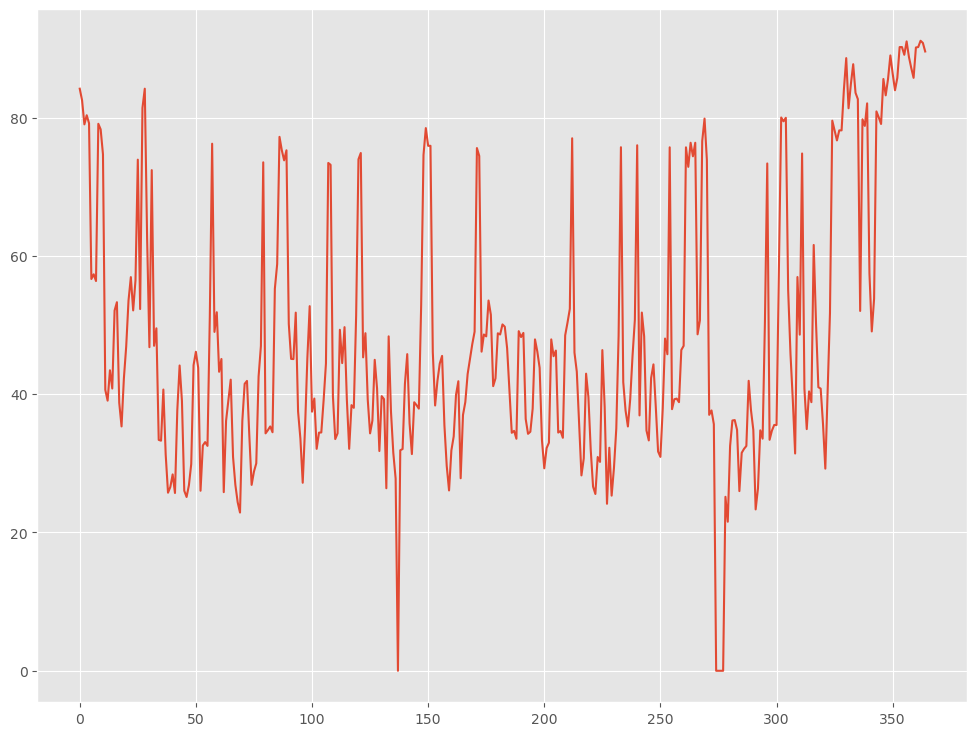

In [175]:
submit = pd.DataFrame({'datetime' : test_data.index, 'pred' : pred_lgb})

print(submit)

# 閉店時の予測値を0に置き換える
for i in test_data2[test_data2['close']==1].index:
    submit['pred'].iloc[i] = 0
    
# 予測値を描画
plt.plot(submit['pred'])

submit.columns = submit.iloc[0]
print(submit)
submit.to_csv('LGBM0909_1.csv', index=False)